# Speech Command Recognition 

This notebook presents an attention model for speech command recognotion. We use Google Speech Commands Dataset to test the Keras generator for sound files and the proposed RNN attention model.


## Download files and load information

Dynamically load speech data from the disk to allow handling big datasets.

First step: download Google Speech Command Dataset and convert all WAV files to numpy arrays for faster load (about 10x faster than loading raw WAV).

In [28]:
useColab=False
if useColab:
    !wget -q https://raw.githubusercontent.com/douglas125/SpeechCmdRecognition/master/SpeechDownloader.py
    !wget -q https://raw.githubusercontent.com/douglas125/SpeechCmdRecognition/master/SpeechGenerator.py
    !wget -q https://raw.githubusercontent.com/douglas125/SpeechCmdRecognition/master/audioUtils.py
    !wget -q https://raw.githubusercontent.com/douglas125/SpeechCmdRecognition/master/SpeechModels.py
    !wget -q https://raw.githubusercontent.com/douglas125/SpeechCmdRecognition/master/requirements.txt
    !pip install -r requirements.txt

In [29]:
%load_ext autoreload
%autoreload 2

import librosa
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

import SpeechDownloader
import SpeechGenerator
import SpeechModels

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
#Download and prepare all data
gscInfo, nCategs = SpeechDownloader.PrepareGoogleSpeechCmd(version=1, task = '35word')

Google Speech commands dataset version 1 already exists. Skipping download.
Converting test set WAVs to numpy files


0it [00:00, ?it/s]


Converting training set WAVs to numpy files


0it [00:00, ?it/s]


Done preparing Google Speech commands dataset version 1


We should have 4 datasets, each with file names 'files' and their categories 'labels' in a dict.

In [31]:
print(gscInfo.keys())
print(gscInfo['train'].keys())
print(len(gscInfo['train']['files']))
print(nCategs)

dict_keys(['train', 'test', 'val', 'testREAL'])
dict_keys(['files', 'labels'])
51094
36


# Speech Data Generator

Use Keras to create a generator that reads files on the fly.

In [32]:
sr=16000 #we know this one for google audios
iLen = 16000
trainGen = SpeechGenerator.SpeechGen(gscInfo['train']['files'], gscInfo['train']['labels'], shuffle=True)
#handle the fact that number of samples in validation may not be multiple of batch_size with shuffle=True
valGen   = SpeechGenerator.SpeechGen(gscInfo['val']['files'], gscInfo['val']['labels'], shuffle=True)

#use batch_size = total number of files to read all test files at once
testGen  = SpeechGenerator.SpeechGen(gscInfo['test']['files'], gscInfo['test']['labels'], shuffle=False, batch_size=len(gscInfo['test']['files']))
testRGen = SpeechGenerator.SpeechGen(gscInfo['testREAL']['files'], gscInfo['testREAL']['labels'], shuffle=False, batch_size=len(gscInfo['testREAL']['files']))
valGen.__len__()

106

In [33]:
audios, classes = valGen.__getitem__(6)
classes

array([15, 24, 14, 18,  7, 11, 31, 32, 23, 15,  1, 31, 12, 12,  1,  5, 29,
       11,  6,  7, 14,  3, 33, 12, 13, 32, 12,  7, 29,  7, 25,  9, 12, 29,
       17, 28, 13,  4,  9, 20, 11,  5, 29, 10, 33,  3,  8, 12, 13,  3,  5,
       20, 15, 18, 22,  8, 10, 17, 16,  1,  1, 32, 22, 15])

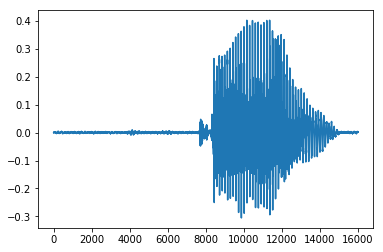

In [34]:
librosa.output.write_wav('file.wav', audios[5], sr, norm=False)
_= plt.plot(audios[5])

In [35]:
from keras.models import Sequential
from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.utils import Normalization2D

melspecModel = Sequential()

melspecModel.add(Melspectrogram(n_dft=1024, n_hop=128, input_shape=(1, iLen),
                         padding='same', sr=sr, n_mels=80,
                         fmin=40.0, fmax=sr/2, power_melgram=1.0,
                         return_decibel_melgram=True, trainable_fb=False,
                         trainable_kernel=False,
                         name='mel_stft') )

melspecModel.add(Normalization2D(int_axis=0))

melspecModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mel_stft (Melspectrogram)    (None, 80, 125, 1)        1091664   
_________________________________________________________________
normalization2d_3 (Normaliza (None, 80, 125, 1)        0         
Total params: 1,091,664
Trainable params: 0
Non-trainable params: 1,091,664
_________________________________________________________________


In [36]:
melspec = melspecModel.predict( audios.reshape((-1,1,iLen)) )
melspec.shape

(64, 80, 125, 1)

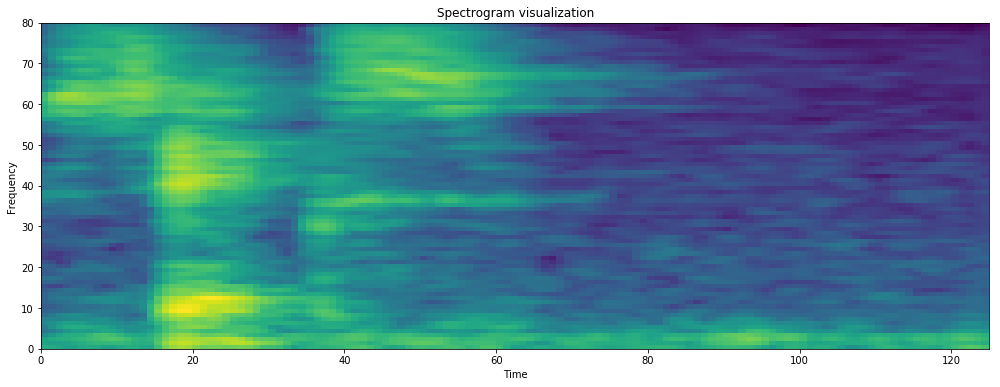

In [37]:
plt.figure(figsize=(17,6))
plt.pcolormesh(melspec[3,:,:,0])

plt.title('Spectrogram visualization')
plt.ylabel('Frequency')
plt.xlabel('Time')

plt.show()

(array([1.6000e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 1.0000e+00, 1.3000e+01, 1.6000e+01,
        3.1000e+01, 2.4000e+01, 1.2000e+01, 1.2000e+01, 2.8000e+01,
        3.9000e+01, 9.0000e+01, 1.3700e+02, 1.1700e+02, 1.9700e+02,
        2.2700e+02, 2.2400e+02, 2.0300e+02, 3.1300e+02, 1.9230e+03,
        5.5700e+02, 6.8600e+02, 7.9100e+02, 2.7940e+03, 3.2280e+03,
        1.3890e+03, 1.9780e+03, 3.0180e+03, 4.3340e+03, 6.5910e+03,
        1.0281e+04, 1.8139e+04, 1.7403e+04, 2.0379e+04, 2.4076e+04,
        2.6468e+04, 2.7430e+04, 2.6887e+04, 2.6514e+04, 2.5525e+04,
        2.4173e+04, 2.2671e+04, 2.1271e+04, 2.0093e+04, 1.9404e+04,
        1.7903e+04, 1.7426e+04, 1.7579e+04, 1.8524e+04, 1.7590e+04,
        1.5658e+04, 1.4268e+04, 1.2973e+04, 1.2511e+04, 1.1953e+04,
        1.0996e+04, 1.0493e+04, 9.8560e+03, 9.1740e+03, 8.4700e+03,
        7.7270e+03, 7.3500e+03, 6.7900e+03, 6.4560e+03, 5.8910e+03,
        5.4650e+03, 5.1660e+03, 4.5490e+03, 4.04

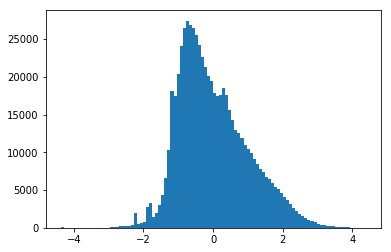

In [38]:
plt.hist(melspec.flatten(), bins=100)

# Models

Create Keras models to see if the generators are working properly

In [39]:
from keras.models import Model, load_model

from keras.layers import Input, Activation, Concatenate, Permute, Reshape, Flatten, Lambda, Dot, Softmax
from keras.layers import Add, Dropout, BatchNormalization, Conv2D, Reshape, MaxPooling2D, Dense, CuDNNLSTM, Bidirectional
from keras import backend as K
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras import optimizers

from kapre.time_frequency import Melspectrogram, Spectrogram

In [13]:
#self-attention LSTM
from My_RNN_Emp.My_RNN_Emp_1 import  AttRNNSpeechModel

model =  AttRNNSpeechModel(nCategs, samplingrate = sr, inputLength = iLen)

model.compile(optimizer='adam', loss=['sparse_categorical_crossentropy'], metrics=['sparse_categorical_accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16000)        0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 1, 16000)     0           input_1[0][0]                    
__________________________________________________________________________________________________
mel_stft (Melspectrogram)       (None, 80, 125, 1)   1091664     reshape_1[0][0]                  
__________________________________________________________________________________________________
normalization2d_2 (Normalizatio (None, 80, 125, 1)   0           mel_stft[0][0]                   
__________________________________________________________________________________________________
permute_1 

In [62]:
import math
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.4
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop,  
            math.floor((1+epoch)/epochs_drop))
    
    if (lrate < 4e-5):
        lrate = 4e-5
      
    print('Changing learning rate to {}'.format(lrate))
    return lrate
lrate = LearningRateScheduler(step_decay)

GPU configuration

In [63]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13491847413250855627
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1460525465
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2917655077724766186
physical_device_desc: "device: 0, name: GeForce GTX 950M, pci bus id: 0000:01:00.0, compute capability: 5.0"
]


In [64]:
from keras import backend as K
import keras
import tensorflow as tf
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [65]:
config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 56} ) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

In [66]:
earlystopper = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=10, verbose=1)
checkpointer = ModelCheckpoint('My_RNN_Emp5_Avg/weights-RNN_Emp5_Avg.h5', monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True,
                               save_weights_only= True)
results = model.fit_generator(trainGen, validation_data = valGen, epochs = 40, use_multiprocessing=True, workers=4, 
                    callbacks=[earlystopper, checkpointer, lrate])

Epoch 1/40
Changing learning rate to 0.001


127/798 [===>..........................] - ETA: 9:52:43 - loss: 3.5872 - sparse_categorical_accuracy: 0.03 - ETA: 5:04:00 - loss: 3.5901 - sparse_categorical_accuracy: 0.03 - ETA: 3:27:50 - loss: 3.5916 - sparse_categorical_accuracy: 0.02 - ETA: 2:40:10 - loss: 3.5877 - sparse_categorical_accuracy: 0.03 - ETA: 2:12:02 - loss: 3.5867 - sparse_categorical_accuracy: 0.03 - ETA: 1:53:14 - loss: 3.5867 - sparse_categorical_accuracy: 0.03 - ETA: 1:39:27 - loss: 3.5870 - sparse_categorical_accuracy: 0.02 - ETA: 1:29:23 - loss: 3.5843 - sparse_categorical_accuracy: 0.03 - ETA: 1:21:29 - loss: 3.5816 - sparse_categorical_accuracy: 0.03 - ETA: 1:14:52 - loss: 3.5781 - sparse_categorical_accuracy: 0.03 - ETA: 1:09:31 - loss: 3.5743 - sparse_categorical_accuracy: 0.04 - ETA: 1:05:01 - loss: 3.5717 - sparse_categorical_accuracy: 0.04 - ETA: 1:01:10 - loss: 3.5692 - sparse_categorical_accuracy: 0.04 - ETA: 57:55 - loss: 3.5649 - sparse_categorical_accuracy: 0.0480 - ETA: 55:11 - loss: 3.5609 - spars

639/798 [=======================>......] - ETA: 7:10 - loss: 1.1208 - sparse_categorical_accuracy: 0.682 - ETA: 7:08 - loss: 1.1196 - sparse_categorical_accuracy: 0.683 - ETA: 7:06 - loss: 1.1187 - sparse_categorical_accuracy: 0.683 - ETA: 7:05 - loss: 1.1172 - sparse_categorical_accuracy: 0.683 - ETA: 7:03 - loss: 1.1156 - sparse_categorical_accuracy: 0.684 - ETA: 7:02 - loss: 1.1142 - sparse_categorical_accuracy: 0.684 - ETA: 7:00 - loss: 1.1125 - sparse_categorical_accuracy: 0.685 - ETA: 6:58 - loss: 1.1117 - sparse_categorical_accuracy: 0.685 - ETA: 6:57 - loss: 1.1101 - sparse_categorical_accuracy: 0.685 - ETA: 6:56 - loss: 1.1094 - sparse_categorical_accuracy: 0.686 - ETA: 6:54 - loss: 1.1084 - sparse_categorical_accuracy: 0.686 - ETA: 6:52 - loss: 1.1075 - sparse_categorical_accuracy: 0.686 - ETA: 6:51 - loss: 1.1072 - sparse_categorical_accuracy: 0.686 - ETA: 6:49 - loss: 1.1057 - sparse_categorical_accuracy: 0.687 - ETA: 6:48 - loss: 1.1042 - sparse_categorical_accuracy: 0.687

767/798 [===========================>..] - ETA: 3:53 - loss: 0.9837 - sparse_categorical_accuracy: 0.721 - ETA: 3:52 - loss: 0.9825 - sparse_categorical_accuracy: 0.722 - ETA: 3:50 - loss: 0.9816 - sparse_categorical_accuracy: 0.722 - ETA: 3:49 - loss: 0.9806 - sparse_categorical_accuracy: 0.722 - ETA: 3:47 - loss: 0.9794 - sparse_categorical_accuracy: 0.723 - ETA: 3:46 - loss: 0.9784 - sparse_categorical_accuracy: 0.723 - ETA: 3:44 - loss: 0.9777 - sparse_categorical_accuracy: 0.723 - ETA: 3:43 - loss: 0.9766 - sparse_categorical_accuracy: 0.723 - ETA: 3:41 - loss: 0.9758 - sparse_categorical_accuracy: 0.724 - ETA: 3:40 - loss: 0.9748 - sparse_categorical_accuracy: 0.724 - ETA: 3:38 - loss: 0.9736 - sparse_categorical_accuracy: 0.724 - ETA: 3:37 - loss: 0.9731 - sparse_categorical_accuracy: 0.724 - ETA: 3:35 - loss: 0.9723 - sparse_categorical_accuracy: 0.725 - ETA: 3:33 - loss: 0.9711 - sparse_categorical_accuracy: 0.725 - ETA: 3:32 - loss: 0.9702 - sparse_categorical_accuracy: 0.725

798/798 [==============================] - ETA: 43s - loss: 0.8798 - sparse_categorical_accuracy: 0.75 - ETA: 42s - loss: 0.8790 - sparse_categorical_accuracy: 0.75 - ETA: 40s - loss: 0.8784 - sparse_categorical_accuracy: 0.75 - ETA: 39s - loss: 0.8778 - sparse_categorical_accuracy: 0.75 - ETA: 37s - loss: 0.8773 - sparse_categorical_accuracy: 0.75 - ETA: 36s - loss: 0.8768 - sparse_categorical_accuracy: 0.75 - ETA: 34s - loss: 0.8762 - sparse_categorical_accuracy: 0.75 - ETA: 33s - loss: 0.8756 - sparse_categorical_accuracy: 0.75 - ETA: 32s - loss: 0.8747 - sparse_categorical_accuracy: 0.75 - ETA: 30s - loss: 0.8739 - sparse_categorical_accuracy: 0.75 - ETA: 29s - loss: 0.8729 - sparse_categorical_accuracy: 0.75 - ETA: 27s - loss: 0.8721 - sparse_categorical_accuracy: 0.75 - ETA: 26s - loss: 0.8713 - sparse_categorical_accuracy: 0.75 - ETA: 24s - loss: 0.8709 - sparse_categorical_accuracy: 0.75 - ETA: 23s - loss: 0.8703 - sparse_categorical_accuracy: 0.75 - ETA: 21s - loss: 0.8698 - s

128/798 [===>..........................] - ETA: 18:37 - loss: 0.2204 - sparse_categorical_accuracy: 0.90 - ETA: 18:33 - loss: 0.2335 - sparse_categorical_accuracy: 0.91 - ETA: 18:24 - loss: 0.3276 - sparse_categorical_accuracy: 0.89 - ETA: 18:39 - loss: 0.3212 - sparse_categorical_accuracy: 0.90 - ETA: 18:37 - loss: 0.2937 - sparse_categorical_accuracy: 0.90 - ETA: 18:32 - loss: 0.2945 - sparse_categorical_accuracy: 0.90 - ETA: 18:21 - loss: 0.2895 - sparse_categorical_accuracy: 0.91 - ETA: 18:27 - loss: 0.2703 - sparse_categorical_accuracy: 0.91 - ETA: 18:24 - loss: 0.2657 - sparse_categorical_accuracy: 0.92 - ETA: 18:27 - loss: 0.2718 - sparse_categorical_accuracy: 0.92 - ETA: 18:25 - loss: 0.2619 - sparse_categorical_accuracy: 0.92 - ETA: 18:28 - loss: 0.2607 - sparse_categorical_accuracy: 0.92 - ETA: 18:35 - loss: 0.2652 - sparse_categorical_accuracy: 0.92 - ETA: 18:12 - loss: 0.2673 - sparse_categorical_accuracy: 0.92 - ETA: 17:51 - loss: 0.2820 - sparse_categorical_accuracy: 0.92

640/798 [=======================>......] - ETA: 4:58 - loss: 0.2832 - sparse_categorical_accuracy: 0.919 - ETA: 4:57 - loss: 0.2830 - sparse_categorical_accuracy: 0.919 - ETA: 4:56 - loss: 0.2829 - sparse_categorical_accuracy: 0.919 - ETA: 4:55 - loss: 0.2827 - sparse_categorical_accuracy: 0.919 - ETA: 4:54 - loss: 0.2827 - sparse_categorical_accuracy: 0.919 - ETA: 4:52 - loss: 0.2829 - sparse_categorical_accuracy: 0.919 - ETA: 4:51 - loss: 0.2829 - sparse_categorical_accuracy: 0.919 - ETA: 4:50 - loss: 0.2828 - sparse_categorical_accuracy: 0.919 - ETA: 4:49 - loss: 0.2830 - sparse_categorical_accuracy: 0.919 - ETA: 4:48 - loss: 0.2829 - sparse_categorical_accuracy: 0.919 - ETA: 4:47 - loss: 0.2829 - sparse_categorical_accuracy: 0.919 - ETA: 4:46 - loss: 0.2826 - sparse_categorical_accuracy: 0.919 - ETA: 4:45 - loss: 0.2829 - sparse_categorical_accuracy: 0.919 - ETA: 4:44 - loss: 0.2825 - sparse_categorical_accuracy: 0.919 - ETA: 4:43 - loss: 0.2824 - sparse_categorical_accuracy: 0.919

769/798 [===========================>..] - ETA: 2:45 - loss: 0.2770 - sparse_categorical_accuracy: 0.921 - ETA: 2:44 - loss: 0.2770 - sparse_categorical_accuracy: 0.921 - ETA: 2:43 - loss: 0.2770 - sparse_categorical_accuracy: 0.921 - ETA: 2:42 - loss: 0.2770 - sparse_categorical_accuracy: 0.921 - ETA: 2:41 - loss: 0.2769 - sparse_categorical_accuracy: 0.921 - ETA: 2:40 - loss: 0.2767 - sparse_categorical_accuracy: 0.921 - ETA: 2:38 - loss: 0.2765 - sparse_categorical_accuracy: 0.921 - ETA: 2:37 - loss: 0.2767 - sparse_categorical_accuracy: 0.921 - ETA: 2:36 - loss: 0.2764 - sparse_categorical_accuracy: 0.921 - ETA: 2:35 - loss: 0.2764 - sparse_categorical_accuracy: 0.921 - ETA: 2:34 - loss: 0.2762 - sparse_categorical_accuracy: 0.921 - ETA: 2:33 - loss: 0.2765 - sparse_categorical_accuracy: 0.921 - ETA: 2:32 - loss: 0.2765 - sparse_categorical_accuracy: 0.921 - ETA: 2:31 - loss: 0.2766 - sparse_categorical_accuracy: 0.921 - ETA: 2:30 - loss: 0.2763 - sparse_categorical_accuracy: 0.921

798/798 [==============================] - ETA: 29s - loss: 0.2728 - sparse_categorical_accuracy: 0.92 - ETA: 28s - loss: 0.2727 - sparse_categorical_accuracy: 0.92 - ETA: 27s - loss: 0.2726 - sparse_categorical_accuracy: 0.92 - ETA: 26s - loss: 0.2725 - sparse_categorical_accuracy: 0.92 - ETA: 25s - loss: 0.2725 - sparse_categorical_accuracy: 0.92 - ETA: 24s - loss: 0.2726 - sparse_categorical_accuracy: 0.92 - ETA: 23s - loss: 0.2727 - sparse_categorical_accuracy: 0.92 - ETA: 22s - loss: 0.2726 - sparse_categorical_accuracy: 0.92 - ETA: 21s - loss: 0.2724 - sparse_categorical_accuracy: 0.92 - ETA: 19s - loss: 0.2725 - sparse_categorical_accuracy: 0.92 - ETA: 18s - loss: 0.2724 - sparse_categorical_accuracy: 0.92 - ETA: 17s - loss: 0.2724 - sparse_categorical_accuracy: 0.92 - ETA: 16s - loss: 0.2722 - sparse_categorical_accuracy: 0.92 - ETA: 15s - loss: 0.2720 - sparse_categorical_accuracy: 0.92 - ETA: 14s - loss: 0.2721 - sparse_categorical_accuracy: 0.92 - ETA: 13s - loss: 0.2720 - s

128/798 [===>..........................] - ETA: 18:08 - loss: 0.1703 - sparse_categorical_accuracy: 0.96 - ETA: 18:04 - loss: 0.2021 - sparse_categorical_accuracy: 0.92 - ETA: 18:52 - loss: 0.1627 - sparse_categorical_accuracy: 0.94 - ETA: 19:05 - loss: 0.1931 - sparse_categorical_accuracy: 0.93 - ETA: 19:28 - loss: 0.1911 - sparse_categorical_accuracy: 0.93 - ETA: 19:14 - loss: 0.1837 - sparse_categorical_accuracy: 0.94 - ETA: 19:12 - loss: 0.1846 - sparse_categorical_accuracy: 0.94 - ETA: 19:11 - loss: 0.1944 - sparse_categorical_accuracy: 0.94 - ETA: 19:12 - loss: 0.2001 - sparse_categorical_accuracy: 0.93 - ETA: 19:08 - loss: 0.1993 - sparse_categorical_accuracy: 0.94 - ETA: 19:09 - loss: 0.1886 - sparse_categorical_accuracy: 0.94 - ETA: 19:03 - loss: 0.1847 - sparse_categorical_accuracy: 0.94 - ETA: 18:59 - loss: 0.1801 - sparse_categorical_accuracy: 0.94 - ETA: 18:54 - loss: 0.1785 - sparse_categorical_accuracy: 0.94 - ETA: 18:55 - loss: 0.1746 - sparse_categorical_accuracy: 0.94

640/798 [=======================>......] - ETA: 5:00 - loss: 0.1934 - sparse_categorical_accuracy: 0.945 - ETA: 4:59 - loss: 0.1931 - sparse_categorical_accuracy: 0.945 - ETA: 4:58 - loss: 0.1938 - sparse_categorical_accuracy: 0.945 - ETA: 4:57 - loss: 0.1937 - sparse_categorical_accuracy: 0.945 - ETA: 4:56 - loss: 0.1938 - sparse_categorical_accuracy: 0.945 - ETA: 4:55 - loss: 0.1936 - sparse_categorical_accuracy: 0.945 - ETA: 4:53 - loss: 0.1938 - sparse_categorical_accuracy: 0.945 - ETA: 4:52 - loss: 0.1940 - sparse_categorical_accuracy: 0.945 - ETA: 4:51 - loss: 0.1938 - sparse_categorical_accuracy: 0.945 - ETA: 4:50 - loss: 0.1937 - sparse_categorical_accuracy: 0.945 - ETA: 4:49 - loss: 0.1939 - sparse_categorical_accuracy: 0.945 - ETA: 4:48 - loss: 0.1943 - sparse_categorical_accuracy: 0.945 - ETA: 4:47 - loss: 0.1942 - sparse_categorical_accuracy: 0.945 - ETA: 4:46 - loss: 0.1945 - sparse_categorical_accuracy: 0.945 - ETA: 4:45 - loss: 0.1944 - sparse_categorical_accuracy: 0.945

769/798 [===========================>..] - ETA: 2:44 - loss: 0.1939 - sparse_categorical_accuracy: 0.945 - ETA: 2:43 - loss: 0.1939 - sparse_categorical_accuracy: 0.945 - ETA: 2:42 - loss: 0.1939 - sparse_categorical_accuracy: 0.945 - ETA: 2:41 - loss: 0.1938 - sparse_categorical_accuracy: 0.945 - ETA: 2:40 - loss: 0.1937 - sparse_categorical_accuracy: 0.945 - ETA: 2:39 - loss: 0.1937 - sparse_categorical_accuracy: 0.945 - ETA: 2:38 - loss: 0.1940 - sparse_categorical_accuracy: 0.945 - ETA: 2:37 - loss: 0.1938 - sparse_categorical_accuracy: 0.945 - ETA: 2:36 - loss: 0.1940 - sparse_categorical_accuracy: 0.945 - ETA: 2:35 - loss: 0.1939 - sparse_categorical_accuracy: 0.945 - ETA: 2:34 - loss: 0.1939 - sparse_categorical_accuracy: 0.945 - ETA: 2:33 - loss: 0.1937 - sparse_categorical_accuracy: 0.945 - ETA: 2:32 - loss: 0.1937 - sparse_categorical_accuracy: 0.945 - ETA: 2:31 - loss: 0.1938 - sparse_categorical_accuracy: 0.945 - ETA: 2:30 - loss: 0.1940 - sparse_categorical_accuracy: 0.945

798/798 [==============================] - ETA: 29s - loss: 0.1941 - sparse_categorical_accuracy: 0.94 - ETA: 28s - loss: 0.1940 - sparse_categorical_accuracy: 0.94 - ETA: 27s - loss: 0.1940 - sparse_categorical_accuracy: 0.94 - ETA: 26s - loss: 0.1939 - sparse_categorical_accuracy: 0.94 - ETA: 25s - loss: 0.1941 - sparse_categorical_accuracy: 0.94 - ETA: 24s - loss: 0.1941 - sparse_categorical_accuracy: 0.94 - ETA: 23s - loss: 0.1944 - sparse_categorical_accuracy: 0.94 - ETA: 21s - loss: 0.1945 - sparse_categorical_accuracy: 0.94 - ETA: 20s - loss: 0.1947 - sparse_categorical_accuracy: 0.94 - ETA: 19s - loss: 0.1949 - sparse_categorical_accuracy: 0.94 - ETA: 18s - loss: 0.1950 - sparse_categorical_accuracy: 0.94 - ETA: 17s - loss: 0.1948 - sparse_categorical_accuracy: 0.94 - ETA: 16s - loss: 0.1949 - sparse_categorical_accuracy: 0.94 - ETA: 15s - loss: 0.1949 - sparse_categorical_accuracy: 0.94 - ETA: 14s - loss: 0.1949 - sparse_categorical_accuracy: 0.94 - ETA: 13s - loss: 0.1950 - s

128/798 [===>..........................] - ETA: 19:09 - loss: 0.1291 - sparse_categorical_accuracy: 0.93 - ETA: 18:41 - loss: 0.1966 - sparse_categorical_accuracy: 0.92 - ETA: 18:23 - loss: 0.1835 - sparse_categorical_accuracy: 0.93 - ETA: 18:37 - loss: 0.1750 - sparse_categorical_accuracy: 0.93 - ETA: 18:33 - loss: 0.1741 - sparse_categorical_accuracy: 0.94 - ETA: 18:30 - loss: 0.1656 - sparse_categorical_accuracy: 0.94 - ETA: 18:39 - loss: 0.1550 - sparse_categorical_accuracy: 0.94 - ETA: 18:40 - loss: 0.1400 - sparse_categorical_accuracy: 0.95 - ETA: 19:04 - loss: 0.1312 - sparse_categorical_accuracy: 0.95 - ETA: 19:09 - loss: 0.1361 - sparse_categorical_accuracy: 0.95 - ETA: 19:09 - loss: 0.1443 - sparse_categorical_accuracy: 0.95 - ETA: 19:12 - loss: 0.1426 - sparse_categorical_accuracy: 0.95 - ETA: 19:05 - loss: 0.1378 - sparse_categorical_accuracy: 0.95 - ETA: 18:56 - loss: 0.1388 - sparse_categorical_accuracy: 0.95 - ETA: 19:01 - loss: 0.1310 - sparse_categorical_accuracy: 0.96

640/798 [=======================>......] - ETA: 5:00 - loss: 0.1554 - sparse_categorical_accuracy: 0.955 - ETA: 4:59 - loss: 0.1555 - sparse_categorical_accuracy: 0.955 - ETA: 4:58 - loss: 0.1554 - sparse_categorical_accuracy: 0.955 - ETA: 4:57 - loss: 0.1556 - sparse_categorical_accuracy: 0.955 - ETA: 4:56 - loss: 0.1559 - sparse_categorical_accuracy: 0.955 - ETA: 4:55 - loss: 0.1559 - sparse_categorical_accuracy: 0.955 - ETA: 4:54 - loss: 0.1559 - sparse_categorical_accuracy: 0.955 - ETA: 4:53 - loss: 0.1563 - sparse_categorical_accuracy: 0.955 - ETA: 4:52 - loss: 0.1564 - sparse_categorical_accuracy: 0.955 - ETA: 4:51 - loss: 0.1564 - sparse_categorical_accuracy: 0.955 - ETA: 4:50 - loss: 0.1563 - sparse_categorical_accuracy: 0.955 - ETA: 4:49 - loss: 0.1566 - sparse_categorical_accuracy: 0.955 - ETA: 4:48 - loss: 0.1566 - sparse_categorical_accuracy: 0.955 - ETA: 4:47 - loss: 0.1564 - sparse_categorical_accuracy: 0.955 - ETA: 4:46 - loss: 0.1562 - sparse_categorical_accuracy: 0.955

769/798 [===========================>..] - ETA: 2:45 - loss: 0.1566 - sparse_categorical_accuracy: 0.955 - ETA: 2:44 - loss: 0.1569 - sparse_categorical_accuracy: 0.955 - ETA: 2:43 - loss: 0.1568 - sparse_categorical_accuracy: 0.955 - ETA: 2:42 - loss: 0.1568 - sparse_categorical_accuracy: 0.955 - ETA: 2:41 - loss: 0.1566 - sparse_categorical_accuracy: 0.955 - ETA: 2:39 - loss: 0.1569 - sparse_categorical_accuracy: 0.955 - ETA: 2:38 - loss: 0.1569 - sparse_categorical_accuracy: 0.955 - ETA: 2:37 - loss: 0.1571 - sparse_categorical_accuracy: 0.955 - ETA: 2:36 - loss: 0.1573 - sparse_categorical_accuracy: 0.955 - ETA: 2:35 - loss: 0.1572 - sparse_categorical_accuracy: 0.955 - ETA: 2:34 - loss: 0.1573 - sparse_categorical_accuracy: 0.955 - ETA: 2:33 - loss: 0.1573 - sparse_categorical_accuracy: 0.955 - ETA: 2:32 - loss: 0.1573 - sparse_categorical_accuracy: 0.955 - ETA: 2:31 - loss: 0.1573 - sparse_categorical_accuracy: 0.955 - ETA: 2:30 - loss: 0.1573 - sparse_categorical_accuracy: 0.955

798/798 [==============================] - ETA: 29s - loss: 0.1595 - sparse_categorical_accuracy: 0.95 - ETA: 28s - loss: 0.1593 - sparse_categorical_accuracy: 0.95 - ETA: 27s - loss: 0.1595 - sparse_categorical_accuracy: 0.95 - ETA: 26s - loss: 0.1598 - sparse_categorical_accuracy: 0.95 - ETA: 25s - loss: 0.1599 - sparse_categorical_accuracy: 0.95 - ETA: 24s - loss: 0.1599 - sparse_categorical_accuracy: 0.95 - ETA: 23s - loss: 0.1598 - sparse_categorical_accuracy: 0.95 - ETA: 22s - loss: 0.1598 - sparse_categorical_accuracy: 0.95 - ETA: 20s - loss: 0.1598 - sparse_categorical_accuracy: 0.95 - ETA: 19s - loss: 0.1599 - sparse_categorical_accuracy: 0.95 - ETA: 18s - loss: 0.1599 - sparse_categorical_accuracy: 0.95 - ETA: 17s - loss: 0.1600 - sparse_categorical_accuracy: 0.95 - ETA: 16s - loss: 0.1601 - sparse_categorical_accuracy: 0.95 - ETA: 15s - loss: 0.1600 - sparse_categorical_accuracy: 0.95 - ETA: 14s - loss: 0.1602 - sparse_categorical_accuracy: 0.95 - ETA: 13s - loss: 0.1600 - s

128/798 [===>..........................] - ETA: 18:58 - loss: 0.1576 - sparse_categorical_accuracy: 0.93 - ETA: 18:42 - loss: 0.1250 - sparse_categorical_accuracy: 0.94 - ETA: 18:35 - loss: 0.0982 - sparse_categorical_accuracy: 0.96 - ETA: 18:53 - loss: 0.0939 - sparse_categorical_accuracy: 0.96 - ETA: 18:42 - loss: 0.1097 - sparse_categorical_accuracy: 0.96 - ETA: 18:28 - loss: 0.1223 - sparse_categorical_accuracy: 0.96 - ETA: 18:33 - loss: 0.1173 - sparse_categorical_accuracy: 0.96 - ETA: 18:36 - loss: 0.1069 - sparse_categorical_accuracy: 0.96 - ETA: 18:35 - loss: 0.1154 - sparse_categorical_accuracy: 0.96 - ETA: 18:28 - loss: 0.1098 - sparse_categorical_accuracy: 0.96 - ETA: 18:32 - loss: 0.1140 - sparse_categorical_accuracy: 0.96 - ETA: 18:36 - loss: 0.1187 - sparse_categorical_accuracy: 0.96 - ETA: 18:38 - loss: 0.1140 - sparse_categorical_accuracy: 0.96 - ETA: 18:34 - loss: 0.1174 - sparse_categorical_accuracy: 0.96 - ETA: 18:45 - loss: 0.1143 - sparse_categorical_accuracy: 0.96

640/798 [=======================>......] - ETA: 4:59 - loss: 0.1226 - sparse_categorical_accuracy: 0.964 - ETA: 4:57 - loss: 0.1227 - sparse_categorical_accuracy: 0.964 - ETA: 4:56 - loss: 0.1227 - sparse_categorical_accuracy: 0.964 - ETA: 4:55 - loss: 0.1227 - sparse_categorical_accuracy: 0.964 - ETA: 4:54 - loss: 0.1227 - sparse_categorical_accuracy: 0.964 - ETA: 4:53 - loss: 0.1228 - sparse_categorical_accuracy: 0.964 - ETA: 4:52 - loss: 0.1232 - sparse_categorical_accuracy: 0.964 - ETA: 4:51 - loss: 0.1233 - sparse_categorical_accuracy: 0.964 - ETA: 4:50 - loss: 0.1233 - sparse_categorical_accuracy: 0.964 - ETA: 4:49 - loss: 0.1233 - sparse_categorical_accuracy: 0.964 - ETA: 4:48 - loss: 0.1234 - sparse_categorical_accuracy: 0.964 - ETA: 4:47 - loss: 0.1233 - sparse_categorical_accuracy: 0.964 - ETA: 4:46 - loss: 0.1234 - sparse_categorical_accuracy: 0.964 - ETA: 4:45 - loss: 0.1233 - sparse_categorical_accuracy: 0.964 - ETA: 4:44 - loss: 0.1231 - sparse_categorical_accuracy: 0.964

769/798 [===========================>..] - ETA: 2:44 - loss: 0.1274 - sparse_categorical_accuracy: 0.963 - ETA: 2:43 - loss: 0.1275 - sparse_categorical_accuracy: 0.963 - ETA: 2:42 - loss: 0.1274 - sparse_categorical_accuracy: 0.963 - ETA: 2:41 - loss: 0.1275 - sparse_categorical_accuracy: 0.963 - ETA: 2:40 - loss: 0.1275 - sparse_categorical_accuracy: 0.963 - ETA: 2:39 - loss: 0.1275 - sparse_categorical_accuracy: 0.963 - ETA: 2:38 - loss: 0.1274 - sparse_categorical_accuracy: 0.963 - ETA: 2:37 - loss: 0.1274 - sparse_categorical_accuracy: 0.963 - ETA: 2:36 - loss: 0.1275 - sparse_categorical_accuracy: 0.963 - ETA: 2:34 - loss: 0.1277 - sparse_categorical_accuracy: 0.963 - ETA: 2:33 - loss: 0.1276 - sparse_categorical_accuracy: 0.963 - ETA: 2:32 - loss: 0.1275 - sparse_categorical_accuracy: 0.963 - ETA: 2:31 - loss: 0.1276 - sparse_categorical_accuracy: 0.963 - ETA: 2:30 - loss: 0.1275 - sparse_categorical_accuracy: 0.963 - ETA: 2:29 - loss: 0.1275 - sparse_categorical_accuracy: 0.963

798/798 [==============================] - ETA: 29s - loss: 0.1278 - sparse_categorical_accuracy: 0.96 - ETA: 28s - loss: 0.1277 - sparse_categorical_accuracy: 0.96 - ETA: 27s - loss: 0.1277 - sparse_categorical_accuracy: 0.96 - ETA: 26s - loss: 0.1278 - sparse_categorical_accuracy: 0.96 - ETA: 25s - loss: 0.1280 - sparse_categorical_accuracy: 0.96 - ETA: 24s - loss: 0.1280 - sparse_categorical_accuracy: 0.96 - ETA: 23s - loss: 0.1279 - sparse_categorical_accuracy: 0.96 - ETA: 21s - loss: 0.1279 - sparse_categorical_accuracy: 0.96 - ETA: 20s - loss: 0.1279 - sparse_categorical_accuracy: 0.96 - ETA: 19s - loss: 0.1280 - sparse_categorical_accuracy: 0.96 - ETA: 18s - loss: 0.1280 - sparse_categorical_accuracy: 0.96 - ETA: 17s - loss: 0.1282 - sparse_categorical_accuracy: 0.96 - ETA: 16s - loss: 0.1281 - sparse_categorical_accuracy: 0.96 - ETA: 15s - loss: 0.1282 - sparse_categorical_accuracy: 0.96 - ETA: 14s - loss: 0.1283 - sparse_categorical_accuracy: 0.96 - ETA: 13s - loss: 0.1283 - s

128/798 [===>..........................] - ETA: 19:20 - loss: 0.2113 - sparse_categorical_accuracy: 0.92 - ETA: 18:50 - loss: 0.2220 - sparse_categorical_accuracy: 0.92 - ETA: 18:55 - loss: 0.1885 - sparse_categorical_accuracy: 0.93 - ETA: 19:11 - loss: 0.1608 - sparse_categorical_accuracy: 0.94 - ETA: 19:00 - loss: 0.1680 - sparse_categorical_accuracy: 0.95 - ETA: 18:44 - loss: 0.1447 - sparse_categorical_accuracy: 0.95 - ETA: 18:42 - loss: 0.1380 - sparse_categorical_accuracy: 0.95 - ETA: 18:46 - loss: 0.1275 - sparse_categorical_accuracy: 0.96 - ETA: 18:43 - loss: 0.1381 - sparse_categorical_accuracy: 0.95 - ETA: 18:36 - loss: 0.1346 - sparse_categorical_accuracy: 0.95 - ETA: 18:39 - loss: 0.1315 - sparse_categorical_accuracy: 0.95 - ETA: 18:40 - loss: 0.1447 - sparse_categorical_accuracy: 0.95 - ETA: 18:41 - loss: 0.1450 - sparse_categorical_accuracy: 0.95 - ETA: 18:39 - loss: 0.1515 - sparse_categorical_accuracy: 0.95 - ETA: 18:39 - loss: 0.1449 - sparse_categorical_accuracy: 0.95

640/798 [=======================>......] - ETA: 4:58 - loss: 0.1207 - sparse_categorical_accuracy: 0.964 - ETA: 4:57 - loss: 0.1205 - sparse_categorical_accuracy: 0.964 - ETA: 4:56 - loss: 0.1205 - sparse_categorical_accuracy: 0.964 - ETA: 4:55 - loss: 0.1204 - sparse_categorical_accuracy: 0.964 - ETA: 4:54 - loss: 0.1203 - sparse_categorical_accuracy: 0.964 - ETA: 4:53 - loss: 0.1203 - sparse_categorical_accuracy: 0.964 - ETA: 4:52 - loss: 0.1204 - sparse_categorical_accuracy: 0.964 - ETA: 4:51 - loss: 0.1205 - sparse_categorical_accuracy: 0.964 - ETA: 4:50 - loss: 0.1204 - sparse_categorical_accuracy: 0.964 - ETA: 4:49 - loss: 0.1204 - sparse_categorical_accuracy: 0.964 - ETA: 4:48 - loss: 0.1204 - sparse_categorical_accuracy: 0.964 - ETA: 4:47 - loss: 0.1202 - sparse_categorical_accuracy: 0.964 - ETA: 4:46 - loss: 0.1201 - sparse_categorical_accuracy: 0.964 - ETA: 4:45 - loss: 0.1205 - sparse_categorical_accuracy: 0.964 - ETA: 4:44 - loss: 0.1206 - sparse_categorical_accuracy: 0.964

769/798 [===========================>..] - ETA: 2:44 - loss: 0.1174 - sparse_categorical_accuracy: 0.965 - ETA: 2:43 - loss: 0.1173 - sparse_categorical_accuracy: 0.965 - ETA: 2:42 - loss: 0.1172 - sparse_categorical_accuracy: 0.965 - ETA: 2:41 - loss: 0.1172 - sparse_categorical_accuracy: 0.966 - ETA: 2:40 - loss: 0.1170 - sparse_categorical_accuracy: 0.966 - ETA: 2:39 - loss: 0.1169 - sparse_categorical_accuracy: 0.966 - ETA: 2:38 - loss: 0.1170 - sparse_categorical_accuracy: 0.966 - ETA: 2:37 - loss: 0.1171 - sparse_categorical_accuracy: 0.966 - ETA: 2:35 - loss: 0.1172 - sparse_categorical_accuracy: 0.966 - ETA: 2:34 - loss: 0.1173 - sparse_categorical_accuracy: 0.966 - ETA: 2:33 - loss: 0.1172 - sparse_categorical_accuracy: 0.966 - ETA: 2:32 - loss: 0.1171 - sparse_categorical_accuracy: 0.966 - ETA: 2:31 - loss: 0.1170 - sparse_categorical_accuracy: 0.966 - ETA: 2:30 - loss: 0.1172 - sparse_categorical_accuracy: 0.966 - ETA: 2:29 - loss: 0.1172 - sparse_categorical_accuracy: 0.966

798/798 [==============================] - ETA: 29s - loss: 0.1205 - sparse_categorical_accuracy: 0.96 - ETA: 28s - loss: 0.1204 - sparse_categorical_accuracy: 0.96 - ETA: 27s - loss: 0.1203 - sparse_categorical_accuracy: 0.96 - ETA: 26s - loss: 0.1203 - sparse_categorical_accuracy: 0.96 - ETA: 25s - loss: 0.1203 - sparse_categorical_accuracy: 0.96 - ETA: 24s - loss: 0.1203 - sparse_categorical_accuracy: 0.96 - ETA: 22s - loss: 0.1203 - sparse_categorical_accuracy: 0.96 - ETA: 21s - loss: 0.1204 - sparse_categorical_accuracy: 0.96 - ETA: 20s - loss: 0.1204 - sparse_categorical_accuracy: 0.96 - ETA: 19s - loss: 0.1204 - sparse_categorical_accuracy: 0.96 - ETA: 18s - loss: 0.1205 - sparse_categorical_accuracy: 0.96 - ETA: 17s - loss: 0.1204 - sparse_categorical_accuracy: 0.96 - ETA: 16s - loss: 0.1205 - sparse_categorical_accuracy: 0.96 - ETA: 15s - loss: 0.1203 - sparse_categorical_accuracy: 0.96 - ETA: 14s - loss: 0.1203 - sparse_categorical_accuracy: 0.96 - ETA: 13s - loss: 0.1204 - s

128/798 [===>..........................] - ETA: 19:05 - loss: 0.1299 - sparse_categorical_accuracy: 0.96 - ETA: 18:27 - loss: 0.1347 - sparse_categorical_accuracy: 0.96 - ETA: 18:42 - loss: 0.1714 - sparse_categorical_accuracy: 0.95 - ETA: 18:52 - loss: 0.1585 - sparse_categorical_accuracy: 0.95 - ETA: 18:52 - loss: 0.1491 - sparse_categorical_accuracy: 0.95 - ETA: 18:50 - loss: 0.1378 - sparse_categorical_accuracy: 0.96 - ETA: 19:02 - loss: 0.1399 - sparse_categorical_accuracy: 0.96 - ETA: 19:00 - loss: 0.1298 - sparse_categorical_accuracy: 0.96 - ETA: 18:56 - loss: 0.1232 - sparse_categorical_accuracy: 0.96 - ETA: 18:44 - loss: 0.1305 - sparse_categorical_accuracy: 0.96 - ETA: 18:44 - loss: 0.1253 - sparse_categorical_accuracy: 0.96 - ETA: 18:39 - loss: 0.1247 - sparse_categorical_accuracy: 0.96 - ETA: 18:37 - loss: 0.1277 - sparse_categorical_accuracy: 0.96 - ETA: 18:33 - loss: 0.1351 - sparse_categorical_accuracy: 0.96 - ETA: 18:38 - loss: 0.1285 - sparse_categorical_accuracy: 0.96

640/798 [=======================>......] - ETA: 4:59 - loss: 0.1004 - sparse_categorical_accuracy: 0.970 - ETA: 4:58 - loss: 0.1005 - sparse_categorical_accuracy: 0.970 - ETA: 4:57 - loss: 0.1004 - sparse_categorical_accuracy: 0.970 - ETA: 4:55 - loss: 0.1004 - sparse_categorical_accuracy: 0.970 - ETA: 4:54 - loss: 0.1006 - sparse_categorical_accuracy: 0.970 - ETA: 4:53 - loss: 0.1006 - sparse_categorical_accuracy: 0.970 - ETA: 4:52 - loss: 0.1004 - sparse_categorical_accuracy: 0.970 - ETA: 4:51 - loss: 0.1005 - sparse_categorical_accuracy: 0.970 - ETA: 4:50 - loss: 0.1006 - sparse_categorical_accuracy: 0.970 - ETA: 4:49 - loss: 0.1005 - sparse_categorical_accuracy: 0.970 - ETA: 4:48 - loss: 0.1005 - sparse_categorical_accuracy: 0.970 - ETA: 4:47 - loss: 0.1004 - sparse_categorical_accuracy: 0.970 - ETA: 4:46 - loss: 0.1003 - sparse_categorical_accuracy: 0.970 - ETA: 4:45 - loss: 0.1002 - sparse_categorical_accuracy: 0.970 - ETA: 4:44 - loss: 0.1002 - sparse_categorical_accuracy: 0.970

769/798 [===========================>..] - ETA: 2:44 - loss: 0.1012 - sparse_categorical_accuracy: 0.970 - ETA: 2:43 - loss: 0.1011 - sparse_categorical_accuracy: 0.970 - ETA: 2:42 - loss: 0.1012 - sparse_categorical_accuracy: 0.970 - ETA: 2:41 - loss: 0.1013 - sparse_categorical_accuracy: 0.970 - ETA: 2:40 - loss: 0.1012 - sparse_categorical_accuracy: 0.970 - ETA: 2:39 - loss: 0.1013 - sparse_categorical_accuracy: 0.970 - ETA: 2:38 - loss: 0.1012 - sparse_categorical_accuracy: 0.970 - ETA: 2:36 - loss: 0.1014 - sparse_categorical_accuracy: 0.970 - ETA: 2:35 - loss: 0.1016 - sparse_categorical_accuracy: 0.970 - ETA: 2:34 - loss: 0.1017 - sparse_categorical_accuracy: 0.970 - ETA: 2:33 - loss: 0.1018 - sparse_categorical_accuracy: 0.970 - ETA: 2:32 - loss: 0.1017 - sparse_categorical_accuracy: 0.970 - ETA: 2:31 - loss: 0.1016 - sparse_categorical_accuracy: 0.970 - ETA: 2:30 - loss: 0.1017 - sparse_categorical_accuracy: 0.970 - ETA: 2:29 - loss: 0.1015 - sparse_categorical_accuracy: 0.970

798/798 [==============================] - ETA: 29s - loss: 0.1029 - sparse_categorical_accuracy: 0.96 - ETA: 28s - loss: 0.1028 - sparse_categorical_accuracy: 0.96 - ETA: 27s - loss: 0.1028 - sparse_categorical_accuracy: 0.96 - ETA: 26s - loss: 0.1027 - sparse_categorical_accuracy: 0.96 - ETA: 25s - loss: 0.1027 - sparse_categorical_accuracy: 0.96 - ETA: 24s - loss: 0.1027 - sparse_categorical_accuracy: 0.96 - ETA: 22s - loss: 0.1029 - sparse_categorical_accuracy: 0.96 - ETA: 21s - loss: 0.1030 - sparse_categorical_accuracy: 0.96 - ETA: 20s - loss: 0.1029 - sparse_categorical_accuracy: 0.96 - ETA: 19s - loss: 0.1029 - sparse_categorical_accuracy: 0.96 - ETA: 18s - loss: 0.1028 - sparse_categorical_accuracy: 0.96 - ETA: 17s - loss: 0.1029 - sparse_categorical_accuracy: 0.96 - ETA: 16s - loss: 0.1028 - sparse_categorical_accuracy: 0.96 - ETA: 15s - loss: 0.1028 - sparse_categorical_accuracy: 0.96 - ETA: 14s - loss: 0.1026 - sparse_categorical_accuracy: 0.96 - ETA: 13s - loss: 0.1027 - s

128/798 [===>..........................] - ETA: 17:29 - loss: 0.1456 - sparse_categorical_accuracy: 0.96 - ETA: 17:51 - loss: 0.1714 - sparse_categorical_accuracy: 0.95 - ETA: 18:01 - loss: 0.1902 - sparse_categorical_accuracy: 0.94 - ETA: 18:21 - loss: 0.1678 - sparse_categorical_accuracy: 0.95 - ETA: 18:20 - loss: 0.1617 - sparse_categorical_accuracy: 0.95 - ETA: 18:21 - loss: 0.1567 - sparse_categorical_accuracy: 0.95 - ETA: 18:27 - loss: 0.1652 - sparse_categorical_accuracy: 0.95 - ETA: 18:25 - loss: 0.1462 - sparse_categorical_accuracy: 0.95 - ETA: 18:20 - loss: 0.1354 - sparse_categorical_accuracy: 0.96 - ETA: 18:13 - loss: 0.1298 - sparse_categorical_accuracy: 0.96 - ETA: 18:15 - loss: 0.1189 - sparse_categorical_accuracy: 0.96 - ETA: 18:16 - loss: 0.1142 - sparse_categorical_accuracy: 0.96 - ETA: 18:13 - loss: 0.1079 - sparse_categorical_accuracy: 0.96 - ETA: 18:13 - loss: 0.1031 - sparse_categorical_accuracy: 0.96 - ETA: 18:16 - loss: 0.1043 - sparse_categorical_accuracy: 0.96

640/798 [=======================>......] - ETA: 5:00 - loss: 0.0830 - sparse_categorical_accuracy: 0.976 - ETA: 4:59 - loss: 0.0831 - sparse_categorical_accuracy: 0.976 - ETA: 4:58 - loss: 0.0833 - sparse_categorical_accuracy: 0.976 - ETA: 4:57 - loss: 0.0833 - sparse_categorical_accuracy: 0.976 - ETA: 4:56 - loss: 0.0833 - sparse_categorical_accuracy: 0.976 - ETA: 4:55 - loss: 0.0834 - sparse_categorical_accuracy: 0.976 - ETA: 4:54 - loss: 0.0835 - sparse_categorical_accuracy: 0.976 - ETA: 4:53 - loss: 0.0838 - sparse_categorical_accuracy: 0.975 - ETA: 4:52 - loss: 0.0837 - sparse_categorical_accuracy: 0.976 - ETA: 4:51 - loss: 0.0837 - sparse_categorical_accuracy: 0.976 - ETA: 4:50 - loss: 0.0837 - sparse_categorical_accuracy: 0.976 - ETA: 4:49 - loss: 0.0839 - sparse_categorical_accuracy: 0.975 - ETA: 4:47 - loss: 0.0840 - sparse_categorical_accuracy: 0.975 - ETA: 4:46 - loss: 0.0840 - sparse_categorical_accuracy: 0.975 - ETA: 4:45 - loss: 0.0839 - sparse_categorical_accuracy: 0.975

769/798 [===========================>..] - ETA: 2:45 - loss: 0.0851 - sparse_categorical_accuracy: 0.975 - ETA: 2:44 - loss: 0.0851 - sparse_categorical_accuracy: 0.975 - ETA: 2:43 - loss: 0.0851 - sparse_categorical_accuracy: 0.975 - ETA: 2:42 - loss: 0.0851 - sparse_categorical_accuracy: 0.975 - ETA: 2:41 - loss: 0.0853 - sparse_categorical_accuracy: 0.975 - ETA: 2:39 - loss: 0.0853 - sparse_categorical_accuracy: 0.975 - ETA: 2:38 - loss: 0.0852 - sparse_categorical_accuracy: 0.975 - ETA: 2:37 - loss: 0.0851 - sparse_categorical_accuracy: 0.975 - ETA: 2:36 - loss: 0.0853 - sparse_categorical_accuracy: 0.975 - ETA: 2:35 - loss: 0.0852 - sparse_categorical_accuracy: 0.975 - ETA: 2:34 - loss: 0.0852 - sparse_categorical_accuracy: 0.975 - ETA: 2:33 - loss: 0.0852 - sparse_categorical_accuracy: 0.975 - ETA: 2:32 - loss: 0.0852 - sparse_categorical_accuracy: 0.975 - ETA: 2:31 - loss: 0.0851 - sparse_categorical_accuracy: 0.975 - ETA: 2:30 - loss: 0.0851 - sparse_categorical_accuracy: 0.975

798/798 [==============================] - ETA: 29s - loss: 0.0854 - sparse_categorical_accuracy: 0.97 - ETA: 28s - loss: 0.0856 - sparse_categorical_accuracy: 0.97 - ETA: 27s - loss: 0.0857 - sparse_categorical_accuracy: 0.97 - ETA: 26s - loss: 0.0856 - sparse_categorical_accuracy: 0.97 - ETA: 25s - loss: 0.0857 - sparse_categorical_accuracy: 0.97 - ETA: 24s - loss: 0.0856 - sparse_categorical_accuracy: 0.97 - ETA: 23s - loss: 0.0855 - sparse_categorical_accuracy: 0.97 - ETA: 22s - loss: 0.0855 - sparse_categorical_accuracy: 0.97 - ETA: 20s - loss: 0.0855 - sparse_categorical_accuracy: 0.97 - ETA: 19s - loss: 0.0854 - sparse_categorical_accuracy: 0.97 - ETA: 18s - loss: 0.0854 - sparse_categorical_accuracy: 0.97 - ETA: 17s - loss: 0.0854 - sparse_categorical_accuracy: 0.97 - ETA: 16s - loss: 0.0856 - sparse_categorical_accuracy: 0.97 - ETA: 15s - loss: 0.0855 - sparse_categorical_accuracy: 0.97 - ETA: 14s - loss: 0.0855 - sparse_categorical_accuracy: 0.97 - ETA: 13s - loss: 0.0855 - s

128/798 [===>..........................] - ETA: 17:52 - loss: 0.0498 - sparse_categorical_accuracy: 0.98 - ETA: 17:56 - loss: 0.0380 - sparse_categorical_accuracy: 0.98 - ETA: 18:09 - loss: 0.0581 - sparse_categorical_accuracy: 0.97 - ETA: 18:35 - loss: 0.0830 - sparse_categorical_accuracy: 0.97 - ETA: 18:32 - loss: 0.0939 - sparse_categorical_accuracy: 0.97 - ETA: 18:30 - loss: 0.0970 - sparse_categorical_accuracy: 0.97 - ETA: 18:29 - loss: 0.0973 - sparse_categorical_accuracy: 0.97 - ETA: 18:27 - loss: 0.0885 - sparse_categorical_accuracy: 0.97 - ETA: 18:36 - loss: 0.0963 - sparse_categorical_accuracy: 0.97 - ETA: 18:36 - loss: 0.0869 - sparse_categorical_accuracy: 0.97 - ETA: 18:39 - loss: 0.0835 - sparse_categorical_accuracy: 0.97 - ETA: 18:35 - loss: 0.0833 - sparse_categorical_accuracy: 0.97 - ETA: 18:29 - loss: 0.0838 - sparse_categorical_accuracy: 0.97 - ETA: 18:26 - loss: 0.0783 - sparse_categorical_accuracy: 0.97 - ETA: 18:26 - loss: 0.0748 - sparse_categorical_accuracy: 0.97

640/798 [=======================>......] - ETA: 4:58 - loss: 0.0851 - sparse_categorical_accuracy: 0.974 - ETA: 4:57 - loss: 0.0853 - sparse_categorical_accuracy: 0.974 - ETA: 4:56 - loss: 0.0851 - sparse_categorical_accuracy: 0.974 - ETA: 4:55 - loss: 0.0851 - sparse_categorical_accuracy: 0.974 - ETA: 4:53 - loss: 0.0851 - sparse_categorical_accuracy: 0.974 - ETA: 4:52 - loss: 0.0851 - sparse_categorical_accuracy: 0.974 - ETA: 4:51 - loss: 0.0852 - sparse_categorical_accuracy: 0.974 - ETA: 4:50 - loss: 0.0852 - sparse_categorical_accuracy: 0.974 - ETA: 4:49 - loss: 0.0851 - sparse_categorical_accuracy: 0.974 - ETA: 4:48 - loss: 0.0851 - sparse_categorical_accuracy: 0.974 - ETA: 4:47 - loss: 0.0850 - sparse_categorical_accuracy: 0.974 - ETA: 4:46 - loss: 0.0850 - sparse_categorical_accuracy: 0.974 - ETA: 4:45 - loss: 0.0851 - sparse_categorical_accuracy: 0.974 - ETA: 4:44 - loss: 0.0850 - sparse_categorical_accuracy: 0.974 - ETA: 4:43 - loss: 0.0850 - sparse_categorical_accuracy: 0.974

769/798 [===========================>..] - ETA: 2:43 - loss: 0.0846 - sparse_categorical_accuracy: 0.975 - ETA: 2:42 - loss: 0.0848 - sparse_categorical_accuracy: 0.975 - ETA: 2:41 - loss: 0.0849 - sparse_categorical_accuracy: 0.975 - ETA: 2:40 - loss: 0.0847 - sparse_categorical_accuracy: 0.975 - ETA: 2:39 - loss: 0.0846 - sparse_categorical_accuracy: 0.975 - ETA: 2:38 - loss: 0.0848 - sparse_categorical_accuracy: 0.975 - ETA: 2:37 - loss: 0.0847 - sparse_categorical_accuracy: 0.975 - ETA: 2:36 - loss: 0.0847 - sparse_categorical_accuracy: 0.975 - ETA: 2:35 - loss: 0.0846 - sparse_categorical_accuracy: 0.975 - ETA: 2:34 - loss: 0.0845 - sparse_categorical_accuracy: 0.975 - ETA: 2:33 - loss: 0.0845 - sparse_categorical_accuracy: 0.975 - ETA: 2:32 - loss: 0.0846 - sparse_categorical_accuracy: 0.975 - ETA: 2:31 - loss: 0.0845 - sparse_categorical_accuracy: 0.975 - ETA: 2:30 - loss: 0.0845 - sparse_categorical_accuracy: 0.975 - ETA: 2:29 - loss: 0.0844 - sparse_categorical_accuracy: 0.975

798/798 [==============================] - ETA: 29s - loss: 0.0839 - sparse_categorical_accuracy: 0.97 - ETA: 28s - loss: 0.0839 - sparse_categorical_accuracy: 0.97 - ETA: 27s - loss: 0.0839 - sparse_categorical_accuracy: 0.97 - ETA: 26s - loss: 0.0839 - sparse_categorical_accuracy: 0.97 - ETA: 24s - loss: 0.0839 - sparse_categorical_accuracy: 0.97 - ETA: 23s - loss: 0.0838 - sparse_categorical_accuracy: 0.97 - ETA: 22s - loss: 0.0838 - sparse_categorical_accuracy: 0.97 - ETA: 21s - loss: 0.0837 - sparse_categorical_accuracy: 0.97 - ETA: 20s - loss: 0.0836 - sparse_categorical_accuracy: 0.97 - ETA: 19s - loss: 0.0836 - sparse_categorical_accuracy: 0.97 - ETA: 18s - loss: 0.0837 - sparse_categorical_accuracy: 0.97 - ETA: 17s - loss: 0.0837 - sparse_categorical_accuracy: 0.97 - ETA: 16s - loss: 0.0837 - sparse_categorical_accuracy: 0.97 - ETA: 15s - loss: 0.0836 - sparse_categorical_accuracy: 0.97 - ETA: 14s - loss: 0.0836 - sparse_categorical_accuracy: 0.97 - ETA: 13s - loss: 0.0837 - s

128/798 [===>..........................] - ETA: 18:24 - loss: 0.1418 - sparse_categorical_accuracy: 0.93 - ETA: 17:58 - loss: 0.0937 - sparse_categorical_accuracy: 0.96 - ETA: 18:18 - loss: 0.1133 - sparse_categorical_accuracy: 0.95 - ETA: 18:38 - loss: 0.0987 - sparse_categorical_accuracy: 0.96 - ETA: 18:31 - loss: 0.0972 - sparse_categorical_accuracy: 0.96 - ETA: 18:28 - loss: 0.0843 - sparse_categorical_accuracy: 0.97 - ETA: 18:36 - loss: 0.0852 - sparse_categorical_accuracy: 0.97 - ETA: 18:44 - loss: 0.0819 - sparse_categorical_accuracy: 0.97 - ETA: 18:46 - loss: 0.0746 - sparse_categorical_accuracy: 0.97 - ETA: 18:44 - loss: 0.0739 - sparse_categorical_accuracy: 0.97 - ETA: 18:45 - loss: 0.0871 - sparse_categorical_accuracy: 0.97 - ETA: 18:41 - loss: 0.0807 - sparse_categorical_accuracy: 0.97 - ETA: 18:34 - loss: 0.0755 - sparse_categorical_accuracy: 0.98 - ETA: 18:28 - loss: 0.0733 - sparse_categorical_accuracy: 0.98 - ETA: 18:30 - loss: 0.0743 - sparse_categorical_accuracy: 0.98

640/798 [=======================>......] - ETA: 4:57 - loss: 0.0520 - sparse_categorical_accuracy: 0.985 - ETA: 4:56 - loss: 0.0521 - sparse_categorical_accuracy: 0.985 - ETA: 4:55 - loss: 0.0520 - sparse_categorical_accuracy: 0.985 - ETA: 4:54 - loss: 0.0522 - sparse_categorical_accuracy: 0.985 - ETA: 4:53 - loss: 0.0521 - sparse_categorical_accuracy: 0.985 - ETA: 4:52 - loss: 0.0521 - sparse_categorical_accuracy: 0.985 - ETA: 4:51 - loss: 0.0520 - sparse_categorical_accuracy: 0.985 - ETA: 4:50 - loss: 0.0520 - sparse_categorical_accuracy: 0.985 - ETA: 4:49 - loss: 0.0519 - sparse_categorical_accuracy: 0.985 - ETA: 4:48 - loss: 0.0519 - sparse_categorical_accuracy: 0.985 - ETA: 4:47 - loss: 0.0518 - sparse_categorical_accuracy: 0.985 - ETA: 4:46 - loss: 0.0517 - sparse_categorical_accuracy: 0.985 - ETA: 4:45 - loss: 0.0516 - sparse_categorical_accuracy: 0.985 - ETA: 4:44 - loss: 0.0517 - sparse_categorical_accuracy: 0.985 - ETA: 4:43 - loss: 0.0517 - sparse_categorical_accuracy: 0.985

769/798 [===========================>..] - ETA: 2:43 - loss: 0.0501 - sparse_categorical_accuracy: 0.986 - ETA: 2:42 - loss: 0.0501 - sparse_categorical_accuracy: 0.986 - ETA: 2:41 - loss: 0.0501 - sparse_categorical_accuracy: 0.986 - ETA: 2:40 - loss: 0.0500 - sparse_categorical_accuracy: 0.986 - ETA: 2:39 - loss: 0.0500 - sparse_categorical_accuracy: 0.986 - ETA: 2:38 - loss: 0.0500 - sparse_categorical_accuracy: 0.986 - ETA: 2:37 - loss: 0.0499 - sparse_categorical_accuracy: 0.986 - ETA: 2:36 - loss: 0.0499 - sparse_categorical_accuracy: 0.986 - ETA: 2:35 - loss: 0.0499 - sparse_categorical_accuracy: 0.986 - ETA: 2:34 - loss: 0.0498 - sparse_categorical_accuracy: 0.986 - ETA: 2:33 - loss: 0.0498 - sparse_categorical_accuracy: 0.986 - ETA: 2:32 - loss: 0.0498 - sparse_categorical_accuracy: 0.986 - ETA: 2:31 - loss: 0.0499 - sparse_categorical_accuracy: 0.986 - ETA: 2:30 - loss: 0.0498 - sparse_categorical_accuracy: 0.986 - ETA: 2:29 - loss: 0.0498 - sparse_categorical_accuracy: 0.986

798/798 [==============================] - ETA: 29s - loss: 0.0496 - sparse_categorical_accuracy: 0.98 - ETA: 28s - loss: 0.0496 - sparse_categorical_accuracy: 0.98 - ETA: 27s - loss: 0.0495 - sparse_categorical_accuracy: 0.98 - ETA: 26s - loss: 0.0495 - sparse_categorical_accuracy: 0.98 - ETA: 24s - loss: 0.0495 - sparse_categorical_accuracy: 0.98 - ETA: 23s - loss: 0.0494 - sparse_categorical_accuracy: 0.98 - ETA: 22s - loss: 0.0493 - sparse_categorical_accuracy: 0.98 - ETA: 21s - loss: 0.0493 - sparse_categorical_accuracy: 0.98 - ETA: 20s - loss: 0.0493 - sparse_categorical_accuracy: 0.98 - ETA: 19s - loss: 0.0492 - sparse_categorical_accuracy: 0.98 - ETA: 18s - loss: 0.0492 - sparse_categorical_accuracy: 0.98 - ETA: 17s - loss: 0.0492 - sparse_categorical_accuracy: 0.98 - ETA: 16s - loss: 0.0492 - sparse_categorical_accuracy: 0.98 - ETA: 15s - loss: 0.0492 - sparse_categorical_accuracy: 0.98 - ETA: 14s - loss: 0.0492 - sparse_categorical_accuracy: 0.98 - ETA: 13s - loss: 0.0493 - s

128/798 [===>..........................] - ETA: 18:15 - loss: 0.0065 - sparse_categorical_accuracy: 1.00 - ETA: 17:43 - loss: 0.0346 - sparse_categorical_accuracy: 1.00 - ETA: 17:52 - loss: 0.0246 - sparse_categorical_accuracy: 1.00 - ETA: 18:24 - loss: 0.0395 - sparse_categorical_accuracy: 0.99 - ETA: 18:20 - loss: 0.0334 - sparse_categorical_accuracy: 0.99 - ETA: 18:13 - loss: 0.0308 - sparse_categorical_accuracy: 0.99 - ETA: 18:14 - loss: 0.0289 - sparse_categorical_accuracy: 0.99 - ETA: 18:24 - loss: 0.0356 - sparse_categorical_accuracy: 0.99 - ETA: 18:25 - loss: 0.0358 - sparse_categorical_accuracy: 0.99 - ETA: 18:23 - loss: 0.0331 - sparse_categorical_accuracy: 0.99 - ETA: 18:23 - loss: 0.0364 - sparse_categorical_accuracy: 0.99 - ETA: 18:24 - loss: 0.0339 - sparse_categorical_accuracy: 0.99 - ETA: 18:21 - loss: 0.0343 - sparse_categorical_accuracy: 0.99 - ETA: 18:15 - loss: 0.0319 - sparse_categorical_accuracy: 0.99 - ETA: 18:21 - loss: 0.0300 - sparse_categorical_accuracy: 0.99

640/798 [=======================>......] - ETA: 4:58 - loss: 0.0343 - sparse_categorical_accuracy: 0.991 - ETA: 4:57 - loss: 0.0343 - sparse_categorical_accuracy: 0.991 - ETA: 4:56 - loss: 0.0343 - sparse_categorical_accuracy: 0.991 - ETA: 4:55 - loss: 0.0343 - sparse_categorical_accuracy: 0.991 - ETA: 4:54 - loss: 0.0343 - sparse_categorical_accuracy: 0.991 - ETA: 4:53 - loss: 0.0342 - sparse_categorical_accuracy: 0.991 - ETA: 4:52 - loss: 0.0342 - sparse_categorical_accuracy: 0.991 - ETA: 4:51 - loss: 0.0342 - sparse_categorical_accuracy: 0.991 - ETA: 4:50 - loss: 0.0342 - sparse_categorical_accuracy: 0.991 - ETA: 4:49 - loss: 0.0341 - sparse_categorical_accuracy: 0.991 - ETA: 4:48 - loss: 0.0342 - sparse_categorical_accuracy: 0.991 - ETA: 4:47 - loss: 0.0341 - sparse_categorical_accuracy: 0.991 - ETA: 4:46 - loss: 0.0341 - sparse_categorical_accuracy: 0.991 - ETA: 4:44 - loss: 0.0340 - sparse_categorical_accuracy: 0.991 - ETA: 4:43 - loss: 0.0340 - sparse_categorical_accuracy: 0.991

769/798 [===========================>..] - ETA: 2:44 - loss: 0.0337 - sparse_categorical_accuracy: 0.991 - ETA: 2:43 - loss: 0.0336 - sparse_categorical_accuracy: 0.991 - ETA: 2:42 - loss: 0.0336 - sparse_categorical_accuracy: 0.991 - ETA: 2:41 - loss: 0.0336 - sparse_categorical_accuracy: 0.991 - ETA: 2:40 - loss: 0.0336 - sparse_categorical_accuracy: 0.991 - ETA: 2:38 - loss: 0.0335 - sparse_categorical_accuracy: 0.991 - ETA: 2:37 - loss: 0.0336 - sparse_categorical_accuracy: 0.991 - ETA: 2:36 - loss: 0.0335 - sparse_categorical_accuracy: 0.991 - ETA: 2:35 - loss: 0.0335 - sparse_categorical_accuracy: 0.991 - ETA: 2:34 - loss: 0.0335 - sparse_categorical_accuracy: 0.991 - ETA: 2:33 - loss: 0.0334 - sparse_categorical_accuracy: 0.991 - ETA: 2:32 - loss: 0.0334 - sparse_categorical_accuracy: 0.991 - ETA: 2:31 - loss: 0.0334 - sparse_categorical_accuracy: 0.991 - ETA: 2:30 - loss: 0.0335 - sparse_categorical_accuracy: 0.991 - ETA: 2:29 - loss: 0.0334 - sparse_categorical_accuracy: 0.991

798/798 [==============================] - ETA: 29s - loss: 0.0339 - sparse_categorical_accuracy: 0.99 - ETA: 28s - loss: 0.0339 - sparse_categorical_accuracy: 0.99 - ETA: 27s - loss: 0.0340 - sparse_categorical_accuracy: 0.99 - ETA: 26s - loss: 0.0339 - sparse_categorical_accuracy: 0.99 - ETA: 25s - loss: 0.0340 - sparse_categorical_accuracy: 0.99 - ETA: 24s - loss: 0.0340 - sparse_categorical_accuracy: 0.99 - ETA: 22s - loss: 0.0339 - sparse_categorical_accuracy: 0.99 - ETA: 21s - loss: 0.0339 - sparse_categorical_accuracy: 0.99 - ETA: 20s - loss: 0.0339 - sparse_categorical_accuracy: 0.99 - ETA: 19s - loss: 0.0339 - sparse_categorical_accuracy: 0.99 - ETA: 18s - loss: 0.0338 - sparse_categorical_accuracy: 0.99 - ETA: 17s - loss: 0.0340 - sparse_categorical_accuracy: 0.99 - ETA: 16s - loss: 0.0341 - sparse_categorical_accuracy: 0.99 - ETA: 15s - loss: 0.0341 - sparse_categorical_accuracy: 0.99 - ETA: 14s - loss: 0.0340 - sparse_categorical_accuracy: 0.99 - ETA: 13s - loss: 0.0340 - s

128/798 [===>..........................] - ETA: 18:41 - loss: 4.9577e-04 - sparse_categorical_accuracy: 1.00 - ETA: 18:33 - loss: 0.0185 - sparse_categorical_accuracy: 0.9922   - ETA: 18:21 - loss: 0.0127 - sparse_categorical_accuracy: 0.99 - ETA: 18:44 - loss: 0.0097 - sparse_categorical_accuracy: 0.99 - ETA: 18:40 - loss: 0.0107 - sparse_categorical_accuracy: 0.99 - ETA: 18:45 - loss: 0.0116 - sparse_categorical_accuracy: 0.99 - ETA: 18:52 - loss: 0.0100 - sparse_categorical_accuracy: 0.99 - ETA: 18:47 - loss: 0.0101 - sparse_categorical_accuracy: 0.99 - ETA: 18:40 - loss: 0.0158 - sparse_categorical_accuracy: 0.99 - ETA: 18:32 - loss: 0.0157 - sparse_categorical_accuracy: 0.99 - ETA: 18:37 - loss: 0.0145 - sparse_categorical_accuracy: 0.99 - ETA: 18:37 - loss: 0.0222 - sparse_categorical_accuracy: 0.99 - ETA: 18:29 - loss: 0.0228 - sparse_categorical_accuracy: 0.99 - ETA: 18:25 - loss: 0.0212 - sparse_categorical_accuracy: 0.99 - ETA: 18:24 - loss: 0.0204 - sparse_categorical_accura

640/798 [=======================>......] - ETA: 5:00 - loss: 0.0265 - sparse_categorical_accuracy: 0.992 - ETA: 4:59 - loss: 0.0265 - sparse_categorical_accuracy: 0.992 - ETA: 4:57 - loss: 0.0265 - sparse_categorical_accuracy: 0.992 - ETA: 4:56 - loss: 0.0265 - sparse_categorical_accuracy: 0.992 - ETA: 4:55 - loss: 0.0265 - sparse_categorical_accuracy: 0.992 - ETA: 4:54 - loss: 0.0265 - sparse_categorical_accuracy: 0.992 - ETA: 4:53 - loss: 0.0264 - sparse_categorical_accuracy: 0.992 - ETA: 4:52 - loss: 0.0264 - sparse_categorical_accuracy: 0.992 - ETA: 4:51 - loss: 0.0264 - sparse_categorical_accuracy: 0.992 - ETA: 4:50 - loss: 0.0263 - sparse_categorical_accuracy: 0.992 - ETA: 4:49 - loss: 0.0263 - sparse_categorical_accuracy: 0.992 - ETA: 4:48 - loss: 0.0263 - sparse_categorical_accuracy: 0.993 - ETA: 4:47 - loss: 0.0263 - sparse_categorical_accuracy: 0.993 - ETA: 4:46 - loss: 0.0263 - sparse_categorical_accuracy: 0.993 - ETA: 4:45 - loss: 0.0263 - sparse_categorical_accuracy: 0.993

769/798 [===========================>..] - ETA: 2:44 - loss: 0.0257 - sparse_categorical_accuracy: 0.993 - ETA: 2:43 - loss: 0.0257 - sparse_categorical_accuracy: 0.993 - ETA: 2:42 - loss: 0.0257 - sparse_categorical_accuracy: 0.993 - ETA: 2:41 - loss: 0.0258 - sparse_categorical_accuracy: 0.993 - ETA: 2:40 - loss: 0.0258 - sparse_categorical_accuracy: 0.993 - ETA: 2:39 - loss: 0.0257 - sparse_categorical_accuracy: 0.993 - ETA: 2:38 - loss: 0.0258 - sparse_categorical_accuracy: 0.993 - ETA: 2:37 - loss: 0.0258 - sparse_categorical_accuracy: 0.993 - ETA: 2:36 - loss: 0.0258 - sparse_categorical_accuracy: 0.993 - ETA: 2:35 - loss: 0.0258 - sparse_categorical_accuracy: 0.993 - ETA: 2:33 - loss: 0.0259 - sparse_categorical_accuracy: 0.993 - ETA: 2:32 - loss: 0.0259 - sparse_categorical_accuracy: 0.993 - ETA: 2:31 - loss: 0.0259 - sparse_categorical_accuracy: 0.993 - ETA: 2:30 - loss: 0.0259 - sparse_categorical_accuracy: 0.993 - ETA: 2:29 - loss: 0.0259 - sparse_categorical_accuracy: 0.993

798/798 [==============================] - ETA: 29s - loss: 0.0269 - sparse_categorical_accuracy: 0.99 - ETA: 28s - loss: 0.0269 - sparse_categorical_accuracy: 0.99 - ETA: 27s - loss: 0.0269 - sparse_categorical_accuracy: 0.99 - ETA: 26s - loss: 0.0269 - sparse_categorical_accuracy: 0.99 - ETA: 25s - loss: 0.0269 - sparse_categorical_accuracy: 0.99 - ETA: 24s - loss: 0.0269 - sparse_categorical_accuracy: 0.99 - ETA: 23s - loss: 0.0268 - sparse_categorical_accuracy: 0.99 - ETA: 21s - loss: 0.0268 - sparse_categorical_accuracy: 0.99 - ETA: 20s - loss: 0.0268 - sparse_categorical_accuracy: 0.99 - ETA: 19s - loss: 0.0268 - sparse_categorical_accuracy: 0.99 - ETA: 18s - loss: 0.0268 - sparse_categorical_accuracy: 0.99 - ETA: 17s - loss: 0.0268 - sparse_categorical_accuracy: 0.99 - ETA: 16s - loss: 0.0268 - sparse_categorical_accuracy: 0.99 - ETA: 15s - loss: 0.0268 - sparse_categorical_accuracy: 0.99 - ETA: 14s - loss: 0.0268 - sparse_categorical_accuracy: 0.99 - ETA: 13s - loss: 0.0268 - s

128/798 [===>..........................] - ETA: 18:24 - loss: 0.0272 - sparse_categorical_accuracy: 0.98 - ETA: 18:25 - loss: 0.0152 - sparse_categorical_accuracy: 0.99 - ETA: 18:20 - loss: 0.0109 - sparse_categorical_accuracy: 0.99 - ETA: 18:44 - loss: 0.0086 - sparse_categorical_accuracy: 0.99 - ETA: 18:34 - loss: 0.0115 - sparse_categorical_accuracy: 0.99 - ETA: 18:25 - loss: 0.0152 - sparse_categorical_accuracy: 0.99 - ETA: 18:24 - loss: 0.0131 - sparse_categorical_accuracy: 0.99 - ETA: 18:32 - loss: 0.0116 - sparse_categorical_accuracy: 0.99 - ETA: 18:31 - loss: 0.0105 - sparse_categorical_accuracy: 0.99 - ETA: 18:25 - loss: 0.0095 - sparse_categorical_accuracy: 0.99 - ETA: 18:24 - loss: 0.0088 - sparse_categorical_accuracy: 0.99 - ETA: 18:24 - loss: 0.0097 - sparse_categorical_accuracy: 0.99 - ETA: 18:21 - loss: 0.0093 - sparse_categorical_accuracy: 0.99 - ETA: 18:21 - loss: 0.0112 - sparse_categorical_accuracy: 0.99 - ETA: 18:24 - loss: 0.0117 - sparse_categorical_accuracy: 0.99

640/798 [=======================>......] - ETA: 4:58 - loss: 0.0251 - sparse_categorical_accuracy: 0.993 - ETA: 4:57 - loss: 0.0251 - sparse_categorical_accuracy: 0.993 - ETA: 4:56 - loss: 0.0251 - sparse_categorical_accuracy: 0.993 - ETA: 4:55 - loss: 0.0250 - sparse_categorical_accuracy: 0.993 - ETA: 4:53 - loss: 0.0250 - sparse_categorical_accuracy: 0.993 - ETA: 4:52 - loss: 0.0251 - sparse_categorical_accuracy: 0.993 - ETA: 4:51 - loss: 0.0251 - sparse_categorical_accuracy: 0.993 - ETA: 4:50 - loss: 0.0250 - sparse_categorical_accuracy: 0.993 - ETA: 4:49 - loss: 0.0251 - sparse_categorical_accuracy: 0.993 - ETA: 4:48 - loss: 0.0250 - sparse_categorical_accuracy: 0.993 - ETA: 4:47 - loss: 0.0251 - sparse_categorical_accuracy: 0.993 - ETA: 4:46 - loss: 0.0250 - sparse_categorical_accuracy: 0.993 - ETA: 4:45 - loss: 0.0250 - sparse_categorical_accuracy: 0.993 - ETA: 4:44 - loss: 0.0250 - sparse_categorical_accuracy: 0.993 - ETA: 4:43 - loss: 0.0250 - sparse_categorical_accuracy: 0.993

769/798 [===========================>..] - ETA: 2:43 - loss: 0.0254 - sparse_categorical_accuracy: 0.993 - ETA: 2:42 - loss: 0.0254 - sparse_categorical_accuracy: 0.993 - ETA: 2:41 - loss: 0.0255 - sparse_categorical_accuracy: 0.993 - ETA: 2:40 - loss: 0.0254 - sparse_categorical_accuracy: 0.993 - ETA: 2:39 - loss: 0.0254 - sparse_categorical_accuracy: 0.993 - ETA: 2:38 - loss: 0.0255 - sparse_categorical_accuracy: 0.993 - ETA: 2:37 - loss: 0.0255 - sparse_categorical_accuracy: 0.993 - ETA: 2:36 - loss: 0.0255 - sparse_categorical_accuracy: 0.993 - ETA: 2:35 - loss: 0.0254 - sparse_categorical_accuracy: 0.993 - ETA: 2:34 - loss: 0.0254 - sparse_categorical_accuracy: 0.993 - ETA: 2:33 - loss: 0.0254 - sparse_categorical_accuracy: 0.993 - ETA: 2:32 - loss: 0.0254 - sparse_categorical_accuracy: 0.993 - ETA: 2:31 - loss: 0.0254 - sparse_categorical_accuracy: 0.993 - ETA: 2:30 - loss: 0.0255 - sparse_categorical_accuracy: 0.993 - ETA: 2:29 - loss: 0.0254 - sparse_categorical_accuracy: 0.993

798/798 [==============================] - ETA: 29s - loss: 0.0263 - sparse_categorical_accuracy: 0.99 - ETA: 28s - loss: 0.0263 - sparse_categorical_accuracy: 0.99 - ETA: 27s - loss: 0.0262 - sparse_categorical_accuracy: 0.99 - ETA: 26s - loss: 0.0264 - sparse_categorical_accuracy: 0.99 - ETA: 25s - loss: 0.0263 - sparse_categorical_accuracy: 0.99 - ETA: 23s - loss: 0.0263 - sparse_categorical_accuracy: 0.99 - ETA: 22s - loss: 0.0263 - sparse_categorical_accuracy: 0.99 - ETA: 21s - loss: 0.0263 - sparse_categorical_accuracy: 0.99 - ETA: 20s - loss: 0.0263 - sparse_categorical_accuracy: 0.99 - ETA: 19s - loss: 0.0263 - sparse_categorical_accuracy: 0.99 - ETA: 18s - loss: 0.0262 - sparse_categorical_accuracy: 0.99 - ETA: 17s - loss: 0.0262 - sparse_categorical_accuracy: 0.99 - ETA: 16s - loss: 0.0263 - sparse_categorical_accuracy: 0.99 - ETA: 15s - loss: 0.0263 - sparse_categorical_accuracy: 0.99 - ETA: 14s - loss: 0.0263 - sparse_categorical_accuracy: 0.99 - ETA: 13s - loss: 0.0264 - s

128/798 [===>..........................] - ETA: 18:52 - loss: 0.0032 - sparse_categorical_accuracy: 1.00 - ETA: 18:14 - loss: 0.0166 - sparse_categorical_accuracy: 1.00 - ETA: 18:13 - loss: 0.0306 - sparse_categorical_accuracy: 0.99 - ETA: 18:31 - loss: 0.0279 - sparse_categorical_accuracy: 0.99 - ETA: 18:25 - loss: 0.0226 - sparse_categorical_accuracy: 0.99 - ETA: 18:13 - loss: 0.0301 - sparse_categorical_accuracy: 0.99 - ETA: 18:16 - loss: 0.0269 - sparse_categorical_accuracy: 0.99 - ETA: 18:24 - loss: 0.0240 - sparse_categorical_accuracy: 0.99 - ETA: 18:26 - loss: 0.0215 - sparse_categorical_accuracy: 0.99 - ETA: 18:23 - loss: 0.0195 - sparse_categorical_accuracy: 0.99 - ETA: 18:23 - loss: 0.0181 - sparse_categorical_accuracy: 0.99 - ETA: 18:26 - loss: 0.0218 - sparse_categorical_accuracy: 0.99 - ETA: 18:24 - loss: 0.0204 - sparse_categorical_accuracy: 0.99 - ETA: 18:18 - loss: 0.0194 - sparse_categorical_accuracy: 0.99 - ETA: 18:18 - loss: 0.0183 - sparse_categorical_accuracy: 0.99

640/798 [=======================>......] - ETA: 4:58 - loss: 0.0259 - sparse_categorical_accuracy: 0.993 - ETA: 4:57 - loss: 0.0259 - sparse_categorical_accuracy: 0.993 - ETA: 4:55 - loss: 0.0259 - sparse_categorical_accuracy: 0.993 - ETA: 4:54 - loss: 0.0259 - sparse_categorical_accuracy: 0.993 - ETA: 4:53 - loss: 0.0259 - sparse_categorical_accuracy: 0.993 - ETA: 4:52 - loss: 0.0259 - sparse_categorical_accuracy: 0.993 - ETA: 4:51 - loss: 0.0258 - sparse_categorical_accuracy: 0.993 - ETA: 4:50 - loss: 0.0259 - sparse_categorical_accuracy: 0.993 - ETA: 4:49 - loss: 0.0261 - sparse_categorical_accuracy: 0.993 - ETA: 4:48 - loss: 0.0262 - sparse_categorical_accuracy: 0.993 - ETA: 4:47 - loss: 0.0262 - sparse_categorical_accuracy: 0.993 - ETA: 4:46 - loss: 0.0262 - sparse_categorical_accuracy: 0.993 - ETA: 4:45 - loss: 0.0262 - sparse_categorical_accuracy: 0.993 - ETA: 4:44 - loss: 0.0261 - sparse_categorical_accuracy: 0.993 - ETA: 4:43 - loss: 0.0261 - sparse_categorical_accuracy: 0.993

769/798 [===========================>..] - ETA: 2:44 - loss: 0.0274 - sparse_categorical_accuracy: 0.992 - ETA: 2:43 - loss: 0.0274 - sparse_categorical_accuracy: 0.992 - ETA: 2:42 - loss: 0.0275 - sparse_categorical_accuracy: 0.992 - ETA: 2:41 - loss: 0.0279 - sparse_categorical_accuracy: 0.992 - ETA: 2:39 - loss: 0.0278 - sparse_categorical_accuracy: 0.992 - ETA: 2:38 - loss: 0.0279 - sparse_categorical_accuracy: 0.992 - ETA: 2:37 - loss: 0.0279 - sparse_categorical_accuracy: 0.992 - ETA: 2:36 - loss: 0.0278 - sparse_categorical_accuracy: 0.992 - ETA: 2:35 - loss: 0.0280 - sparse_categorical_accuracy: 0.992 - ETA: 2:34 - loss: 0.0280 - sparse_categorical_accuracy: 0.992 - ETA: 2:33 - loss: 0.0280 - sparse_categorical_accuracy: 0.992 - ETA: 2:32 - loss: 0.0280 - sparse_categorical_accuracy: 0.992 - ETA: 2:31 - loss: 0.0280 - sparse_categorical_accuracy: 0.992 - ETA: 2:30 - loss: 0.0280 - sparse_categorical_accuracy: 0.992 - ETA: 2:29 - loss: 0.0280 - sparse_categorical_accuracy: 0.992

798/798 [==============================] - ETA: 29s - loss: 0.0286 - sparse_categorical_accuracy: 0.99 - ETA: 28s - loss: 0.0287 - sparse_categorical_accuracy: 0.99 - ETA: 27s - loss: 0.0286 - sparse_categorical_accuracy: 0.99 - ETA: 26s - loss: 0.0286 - sparse_categorical_accuracy: 0.99 - ETA: 25s - loss: 0.0286 - sparse_categorical_accuracy: 0.99 - ETA: 24s - loss: 0.0287 - sparse_categorical_accuracy: 0.99 - ETA: 22s - loss: 0.0286 - sparse_categorical_accuracy: 0.99 - ETA: 21s - loss: 0.0286 - sparse_categorical_accuracy: 0.99 - ETA: 20s - loss: 0.0286 - sparse_categorical_accuracy: 0.99 - ETA: 19s - loss: 0.0286 - sparse_categorical_accuracy: 0.99 - ETA: 18s - loss: 0.0286 - sparse_categorical_accuracy: 0.99 - ETA: 17s - loss: 0.0287 - sparse_categorical_accuracy: 0.99 - ETA: 16s - loss: 0.0288 - sparse_categorical_accuracy: 0.99 - ETA: 15s - loss: 0.0288 - sparse_categorical_accuracy: 0.99 - ETA: 14s - loss: 0.0288 - sparse_categorical_accuracy: 0.99 - ETA: 13s - loss: 0.0287 - s

128/798 [===>..........................] - ETA: 18:37 - loss: 0.0388 - sparse_categorical_accuracy: 0.98 - ETA: 18:44 - loss: 0.0197 - sparse_categorical_accuracy: 0.99 - ETA: 18:49 - loss: 0.0133 - sparse_categorical_accuracy: 0.99 - ETA: 19:03 - loss: 0.0169 - sparse_categorical_accuracy: 0.99 - ETA: 18:51 - loss: 0.0220 - sparse_categorical_accuracy: 0.99 - ETA: 18:37 - loss: 0.0291 - sparse_categorical_accuracy: 0.98 - ETA: 18:49 - loss: 0.0255 - sparse_categorical_accuracy: 0.98 - ETA: 18:49 - loss: 0.0225 - sparse_categorical_accuracy: 0.99 - ETA: 18:41 - loss: 0.0217 - sparse_categorical_accuracy: 0.99 - ETA: 18:31 - loss: 0.0212 - sparse_categorical_accuracy: 0.99 - ETA: 18:31 - loss: 0.0202 - sparse_categorical_accuracy: 0.99 - ETA: 18:27 - loss: 0.0245 - sparse_categorical_accuracy: 0.99 - ETA: 18:20 - loss: 0.0233 - sparse_categorical_accuracy: 0.99 - ETA: 18:17 - loss: 0.0220 - sparse_categorical_accuracy: 0.99 - ETA: 18:18 - loss: 0.0212 - sparse_categorical_accuracy: 0.99

640/798 [=======================>......] - ETA: 4:58 - loss: 0.0187 - sparse_categorical_accuracy: 0.995 - ETA: 4:57 - loss: 0.0186 - sparse_categorical_accuracy: 0.995 - ETA: 4:56 - loss: 0.0186 - sparse_categorical_accuracy: 0.995 - ETA: 4:54 - loss: 0.0186 - sparse_categorical_accuracy: 0.995 - ETA: 4:53 - loss: 0.0185 - sparse_categorical_accuracy: 0.995 - ETA: 4:52 - loss: 0.0185 - sparse_categorical_accuracy: 0.995 - ETA: 4:51 - loss: 0.0185 - sparse_categorical_accuracy: 0.995 - ETA: 4:50 - loss: 0.0185 - sparse_categorical_accuracy: 0.995 - ETA: 4:49 - loss: 0.0184 - sparse_categorical_accuracy: 0.995 - ETA: 4:48 - loss: 0.0186 - sparse_categorical_accuracy: 0.995 - ETA: 4:47 - loss: 0.0185 - sparse_categorical_accuracy: 0.995 - ETA: 4:46 - loss: 0.0186 - sparse_categorical_accuracy: 0.995 - ETA: 4:45 - loss: 0.0186 - sparse_categorical_accuracy: 0.995 - ETA: 4:44 - loss: 0.0187 - sparse_categorical_accuracy: 0.995 - ETA: 4:43 - loss: 0.0186 - sparse_categorical_accuracy: 0.995

769/798 [===========================>..] - ETA: 2:43 - loss: 0.0187 - sparse_categorical_accuracy: 0.995 - ETA: 2:42 - loss: 0.0187 - sparse_categorical_accuracy: 0.995 - ETA: 2:41 - loss: 0.0187 - sparse_categorical_accuracy: 0.995 - ETA: 2:40 - loss: 0.0187 - sparse_categorical_accuracy: 0.995 - ETA: 2:39 - loss: 0.0187 - sparse_categorical_accuracy: 0.995 - ETA: 2:38 - loss: 0.0187 - sparse_categorical_accuracy: 0.995 - ETA: 2:37 - loss: 0.0187 - sparse_categorical_accuracy: 0.995 - ETA: 2:36 - loss: 0.0187 - sparse_categorical_accuracy: 0.995 - ETA: 2:35 - loss: 0.0187 - sparse_categorical_accuracy: 0.995 - ETA: 2:34 - loss: 0.0186 - sparse_categorical_accuracy: 0.995 - ETA: 2:33 - loss: 0.0186 - sparse_categorical_accuracy: 0.995 - ETA: 2:32 - loss: 0.0186 - sparse_categorical_accuracy: 0.995 - ETA: 2:31 - loss: 0.0186 - sparse_categorical_accuracy: 0.995 - ETA: 2:30 - loss: 0.0186 - sparse_categorical_accuracy: 0.995 - ETA: 2:29 - loss: 0.0187 - sparse_categorical_accuracy: 0.995

798/798 [==============================] - ETA: 29s - loss: 0.0192 - sparse_categorical_accuracy: 0.99 - ETA: 28s - loss: 0.0193 - sparse_categorical_accuracy: 0.99 - ETA: 27s - loss: 0.0192 - sparse_categorical_accuracy: 0.99 - ETA: 26s - loss: 0.0192 - sparse_categorical_accuracy: 0.99 - ETA: 25s - loss: 0.0193 - sparse_categorical_accuracy: 0.99 - ETA: 23s - loss: 0.0193 - sparse_categorical_accuracy: 0.99 - ETA: 22s - loss: 0.0193 - sparse_categorical_accuracy: 0.99 - ETA: 21s - loss: 0.0193 - sparse_categorical_accuracy: 0.99 - ETA: 20s - loss: 0.0193 - sparse_categorical_accuracy: 0.99 - ETA: 19s - loss: 0.0193 - sparse_categorical_accuracy: 0.99 - ETA: 18s - loss: 0.0193 - sparse_categorical_accuracy: 0.99 - ETA: 17s - loss: 0.0193 - sparse_categorical_accuracy: 0.99 - ETA: 16s - loss: 0.0193 - sparse_categorical_accuracy: 0.99 - ETA: 15s - loss: 0.0193 - sparse_categorical_accuracy: 0.99 - ETA: 14s - loss: 0.0193 - sparse_categorical_accuracy: 0.99 - ETA: 13s - loss: 0.0193 - s

128/798 [===>..........................] - ETA: 19:07 - loss: 1.8773e-04 - sparse_categorical_accuracy: 1.00 - ETA: 18:24 - loss: 8.5271e-04 - sparse_categorical_accuracy: 1.00 - ETA: 18:37 - loss: 0.0011 - sparse_categorical_accuracy: 1.0000   - ETA: 18:48 - loss: 9.8641e-04 - sparse_categorical_accuracy: 1.00 - ETA: 18:35 - loss: 0.0085 - sparse_categorical_accuracy: 0.9969   - ETA: 18:19 - loss: 0.0073 - sparse_categorical_accuracy: 0.99 - ETA: 18:23 - loss: 0.0076 - sparse_categorical_accuracy: 0.99 - ETA: 18:29 - loss: 0.0071 - sparse_categorical_accuracy: 0.99 - ETA: 18:35 - loss: 0.0064 - sparse_categorical_accuracy: 0.99 - ETA: 18:31 - loss: 0.0065 - sparse_categorical_accuracy: 0.99 - ETA: 18:31 - loss: 0.0072 - sparse_categorical_accuracy: 0.99 - ETA: 18:27 - loss: 0.0067 - sparse_categorical_accuracy: 0.99 - ETA: 18:20 - loss: 0.0080 - sparse_categorical_accuracy: 0.99 - ETA: 18:16 - loss: 0.0084 - sparse_categorical_accuracy: 0.99 - ETA: 18:25 - loss: 0.0134 - sparse_catego

640/798 [=======================>......] - ETA: 4:59 - loss: 0.0154 - sparse_categorical_accuracy: 0.996 - ETA: 4:58 - loss: 0.0154 - sparse_categorical_accuracy: 0.996 - ETA: 4:57 - loss: 0.0153 - sparse_categorical_accuracy: 0.996 - ETA: 4:56 - loss: 0.0154 - sparse_categorical_accuracy: 0.996 - ETA: 4:55 - loss: 0.0154 - sparse_categorical_accuracy: 0.996 - ETA: 4:54 - loss: 0.0153 - sparse_categorical_accuracy: 0.996 - ETA: 4:53 - loss: 0.0153 - sparse_categorical_accuracy: 0.996 - ETA: 4:52 - loss: 0.0153 - sparse_categorical_accuracy: 0.996 - ETA: 4:51 - loss: 0.0153 - sparse_categorical_accuracy: 0.996 - ETA: 4:50 - loss: 0.0153 - sparse_categorical_accuracy: 0.996 - ETA: 4:49 - loss: 0.0152 - sparse_categorical_accuracy: 0.996 - ETA: 4:48 - loss: 0.0152 - sparse_categorical_accuracy: 0.996 - ETA: 4:46 - loss: 0.0152 - sparse_categorical_accuracy: 0.996 - ETA: 4:45 - loss: 0.0152 - sparse_categorical_accuracy: 0.996 - ETA: 4:44 - loss: 0.0152 - sparse_categorical_accuracy: 0.996

769/798 [===========================>..] - ETA: 2:44 - loss: 0.0152 - sparse_categorical_accuracy: 0.996 - ETA: 2:43 - loss: 0.0152 - sparse_categorical_accuracy: 0.996 - ETA: 2:42 - loss: 0.0152 - sparse_categorical_accuracy: 0.996 - ETA: 2:41 - loss: 0.0152 - sparse_categorical_accuracy: 0.996 - ETA: 2:40 - loss: 0.0152 - sparse_categorical_accuracy: 0.996 - ETA: 2:39 - loss: 0.0152 - sparse_categorical_accuracy: 0.996 - ETA: 2:38 - loss: 0.0153 - sparse_categorical_accuracy: 0.996 - ETA: 2:37 - loss: 0.0152 - sparse_categorical_accuracy: 0.996 - ETA: 2:36 - loss: 0.0152 - sparse_categorical_accuracy: 0.996 - ETA: 2:35 - loss: 0.0152 - sparse_categorical_accuracy: 0.996 - ETA: 2:33 - loss: 0.0152 - sparse_categorical_accuracy: 0.996 - ETA: 2:32 - loss: 0.0152 - sparse_categorical_accuracy: 0.996 - ETA: 2:31 - loss: 0.0152 - sparse_categorical_accuracy: 0.996 - ETA: 2:30 - loss: 0.0152 - sparse_categorical_accuracy: 0.996 - ETA: 2:29 - loss: 0.0151 - sparse_categorical_accuracy: 0.996

798/798 [==============================] - ETA: 29s - loss: 0.0151 - sparse_categorical_accuracy: 0.99 - ETA: 28s - loss: 0.0151 - sparse_categorical_accuracy: 0.99 - ETA: 27s - loss: 0.0152 - sparse_categorical_accuracy: 0.99 - ETA: 26s - loss: 0.0152 - sparse_categorical_accuracy: 0.99 - ETA: 25s - loss: 0.0152 - sparse_categorical_accuracy: 0.99 - ETA: 24s - loss: 0.0152 - sparse_categorical_accuracy: 0.99 - ETA: 22s - loss: 0.0151 - sparse_categorical_accuracy: 0.99 - ETA: 21s - loss: 0.0151 - sparse_categorical_accuracy: 0.99 - ETA: 20s - loss: 0.0151 - sparse_categorical_accuracy: 0.99 - ETA: 19s - loss: 0.0151 - sparse_categorical_accuracy: 0.99 - ETA: 18s - loss: 0.0151 - sparse_categorical_accuracy: 0.99 - ETA: 17s - loss: 0.0151 - sparse_categorical_accuracy: 0.99 - ETA: 16s - loss: 0.0151 - sparse_categorical_accuracy: 0.99 - ETA: 15s - loss: 0.0151 - sparse_categorical_accuracy: 0.99 - ETA: 14s - loss: 0.0151 - sparse_categorical_accuracy: 0.99 - ETA: 13s - loss: 0.0151 - s

128/798 [===>..........................] - ETA: 17:16 - loss: 0.0024 - sparse_categorical_accuracy: 1.00 - ETA: 17:19 - loss: 0.0042 - sparse_categorical_accuracy: 1.00 - ETA: 17:44 - loss: 0.0029 - sparse_categorical_accuracy: 1.00 - ETA: 18:12 - loss: 0.0023 - sparse_categorical_accuracy: 1.00 - ETA: 18:08 - loss: 0.0021 - sparse_categorical_accuracy: 1.00 - ETA: 18:03 - loss: 0.0051 - sparse_categorical_accuracy: 1.00 - ETA: 18:07 - loss: 0.0046 - sparse_categorical_accuracy: 1.00 - ETA: 18:13 - loss: 0.0053 - sparse_categorical_accuracy: 1.00 - ETA: 18:07 - loss: 0.0048 - sparse_categorical_accuracy: 1.00 - ETA: 18:00 - loss: 0.0050 - sparse_categorical_accuracy: 1.00 - ETA: 17:57 - loss: 0.0046 - sparse_categorical_accuracy: 1.00 - ETA: 17:58 - loss: 0.0043 - sparse_categorical_accuracy: 1.00 - ETA: 17:56 - loss: 0.0040 - sparse_categorical_accuracy: 1.00 - ETA: 17:55 - loss: 0.0038 - sparse_categorical_accuracy: 1.00 - ETA: 17:57 - loss: 0.0037 - sparse_categorical_accuracy: 1.00

640/798 [=======================>......] - ETA: 4:57 - loss: 0.0096 - sparse_categorical_accuracy: 0.997 - ETA: 4:56 - loss: 0.0096 - sparse_categorical_accuracy: 0.997 - ETA: 4:55 - loss: 0.0096 - sparse_categorical_accuracy: 0.997 - ETA: 4:54 - loss: 0.0096 - sparse_categorical_accuracy: 0.997 - ETA: 4:53 - loss: 0.0096 - sparse_categorical_accuracy: 0.997 - ETA: 4:52 - loss: 0.0096 - sparse_categorical_accuracy: 0.997 - ETA: 4:51 - loss: 0.0096 - sparse_categorical_accuracy: 0.997 - ETA: 4:50 - loss: 0.0097 - sparse_categorical_accuracy: 0.997 - ETA: 4:49 - loss: 0.0098 - sparse_categorical_accuracy: 0.997 - ETA: 4:48 - loss: 0.0098 - sparse_categorical_accuracy: 0.997 - ETA: 4:47 - loss: 0.0099 - sparse_categorical_accuracy: 0.997 - ETA: 4:46 - loss: 0.0099 - sparse_categorical_accuracy: 0.997 - ETA: 4:45 - loss: 0.0099 - sparse_categorical_accuracy: 0.997 - ETA: 4:44 - loss: 0.0099 - sparse_categorical_accuracy: 0.997 - ETA: 4:43 - loss: 0.0099 - sparse_categorical_accuracy: 0.997

769/798 [===========================>..] - ETA: 2:43 - loss: 0.0105 - sparse_categorical_accuracy: 0.997 - ETA: 2:42 - loss: 0.0105 - sparse_categorical_accuracy: 0.997 - ETA: 2:41 - loss: 0.0105 - sparse_categorical_accuracy: 0.997 - ETA: 2:40 - loss: 0.0105 - sparse_categorical_accuracy: 0.997 - ETA: 2:39 - loss: 0.0105 - sparse_categorical_accuracy: 0.997 - ETA: 2:38 - loss: 0.0105 - sparse_categorical_accuracy: 0.997 - ETA: 2:37 - loss: 0.0105 - sparse_categorical_accuracy: 0.997 - ETA: 2:36 - loss: 0.0105 - sparse_categorical_accuracy: 0.997 - ETA: 2:35 - loss: 0.0105 - sparse_categorical_accuracy: 0.997 - ETA: 2:34 - loss: 0.0104 - sparse_categorical_accuracy: 0.997 - ETA: 2:33 - loss: 0.0105 - sparse_categorical_accuracy: 0.997 - ETA: 2:32 - loss: 0.0105 - sparse_categorical_accuracy: 0.997 - ETA: 2:31 - loss: 0.0105 - sparse_categorical_accuracy: 0.997 - ETA: 2:30 - loss: 0.0105 - sparse_categorical_accuracy: 0.997 - ETA: 2:28 - loss: 0.0105 - sparse_categorical_accuracy: 0.997

798/798 [==============================] - ETA: 29s - loss: 0.0116 - sparse_categorical_accuracy: 0.99 - ETA: 28s - loss: 0.0117 - sparse_categorical_accuracy: 0.99 - ETA: 27s - loss: 0.0117 - sparse_categorical_accuracy: 0.99 - ETA: 26s - loss: 0.0117 - sparse_categorical_accuracy: 0.99 - ETA: 24s - loss: 0.0117 - sparse_categorical_accuracy: 0.99 - ETA: 23s - loss: 0.0117 - sparse_categorical_accuracy: 0.99 - ETA: 22s - loss: 0.0116 - sparse_categorical_accuracy: 0.99 - ETA: 21s - loss: 0.0116 - sparse_categorical_accuracy: 0.99 - ETA: 20s - loss: 0.0117 - sparse_categorical_accuracy: 0.99 - ETA: 19s - loss: 0.0117 - sparse_categorical_accuracy: 0.99 - ETA: 18s - loss: 0.0117 - sparse_categorical_accuracy: 0.99 - ETA: 17s - loss: 0.0117 - sparse_categorical_accuracy: 0.99 - ETA: 16s - loss: 0.0117 - sparse_categorical_accuracy: 0.99 - ETA: 15s - loss: 0.0118 - sparse_categorical_accuracy: 0.99 - ETA: 14s - loss: 0.0117 - sparse_categorical_accuracy: 0.99 - ETA: 13s - loss: 0.0117 - s

128/798 [===>..........................] - ETA: 18:42 - loss: 0.0014 - sparse_categorical_accuracy: 1.00 - ETA: 18:30 - loss: 0.0019 - sparse_categorical_accuracy: 1.00 - ETA: 18:29 - loss: 0.0026 - sparse_categorical_accuracy: 1.00 - ETA: 18:51 - loss: 0.0025 - sparse_categorical_accuracy: 1.00 - ETA: 18:47 - loss: 0.0031 - sparse_categorical_accuracy: 1.00 - ETA: 18:35 - loss: 0.0026 - sparse_categorical_accuracy: 1.00 - ETA: 18:35 - loss: 0.0081 - sparse_categorical_accuracy: 0.99 - ETA: 18:37 - loss: 0.0187 - sparse_categorical_accuracy: 0.99 - ETA: 18:33 - loss: 0.0167 - sparse_categorical_accuracy: 0.99 - ETA: 18:25 - loss: 0.0159 - sparse_categorical_accuracy: 0.99 - ETA: 18:25 - loss: 0.0145 - sparse_categorical_accuracy: 0.99 - ETA: 18:27 - loss: 0.0141 - sparse_categorical_accuracy: 0.99 - ETA: 18:22 - loss: 0.0148 - sparse_categorical_accuracy: 0.99 - ETA: 18:18 - loss: 0.0186 - sparse_categorical_accuracy: 0.99 - ETA: 18:18 - loss: 0.0186 - sparse_categorical_accuracy: 0.99

640/798 [=======================>......] - ETA: 4:57 - loss: 0.0202 - sparse_categorical_accuracy: 0.994 - ETA: 4:56 - loss: 0.0204 - sparse_categorical_accuracy: 0.994 - ETA: 4:55 - loss: 0.0204 - sparse_categorical_accuracy: 0.994 - ETA: 4:54 - loss: 0.0203 - sparse_categorical_accuracy: 0.994 - ETA: 4:53 - loss: 0.0204 - sparse_categorical_accuracy: 0.994 - ETA: 4:52 - loss: 0.0204 - sparse_categorical_accuracy: 0.994 - ETA: 4:51 - loss: 0.0204 - sparse_categorical_accuracy: 0.994 - ETA: 4:50 - loss: 0.0204 - sparse_categorical_accuracy: 0.994 - ETA: 4:49 - loss: 0.0205 - sparse_categorical_accuracy: 0.994 - ETA: 4:48 - loss: 0.0205 - sparse_categorical_accuracy: 0.994 - ETA: 4:46 - loss: 0.0206 - sparse_categorical_accuracy: 0.994 - ETA: 4:45 - loss: 0.0205 - sparse_categorical_accuracy: 0.994 - ETA: 4:44 - loss: 0.0205 - sparse_categorical_accuracy: 0.994 - ETA: 4:43 - loss: 0.0205 - sparse_categorical_accuracy: 0.994 - ETA: 4:42 - loss: 0.0205 - sparse_categorical_accuracy: 0.994

769/798 [===========================>..] - ETA: 2:43 - loss: 0.0203 - sparse_categorical_accuracy: 0.994 - ETA: 2:42 - loss: 0.0203 - sparse_categorical_accuracy: 0.994 - ETA: 2:41 - loss: 0.0202 - sparse_categorical_accuracy: 0.994 - ETA: 2:40 - loss: 0.0202 - sparse_categorical_accuracy: 0.994 - ETA: 2:39 - loss: 0.0202 - sparse_categorical_accuracy: 0.994 - ETA: 2:38 - loss: 0.0202 - sparse_categorical_accuracy: 0.994 - ETA: 2:37 - loss: 0.0201 - sparse_categorical_accuracy: 0.994 - ETA: 2:36 - loss: 0.0201 - sparse_categorical_accuracy: 0.994 - ETA: 2:35 - loss: 0.0201 - sparse_categorical_accuracy: 0.994 - ETA: 2:34 - loss: 0.0201 - sparse_categorical_accuracy: 0.994 - ETA: 2:33 - loss: 0.0202 - sparse_categorical_accuracy: 0.994 - ETA: 2:32 - loss: 0.0203 - sparse_categorical_accuracy: 0.994 - ETA: 2:31 - loss: 0.0203 - sparse_categorical_accuracy: 0.994 - ETA: 2:29 - loss: 0.0203 - sparse_categorical_accuracy: 0.994 - ETA: 2:28 - loss: 0.0203 - sparse_categorical_accuracy: 0.994

798/798 [==============================] - ETA: 29s - loss: 0.0204 - sparse_categorical_accuracy: 0.99 - ETA: 28s - loss: 0.0204 - sparse_categorical_accuracy: 0.99 - ETA: 27s - loss: 0.0203 - sparse_categorical_accuracy: 0.99 - ETA: 25s - loss: 0.0203 - sparse_categorical_accuracy: 0.99 - ETA: 24s - loss: 0.0203 - sparse_categorical_accuracy: 0.99 - ETA: 23s - loss: 0.0203 - sparse_categorical_accuracy: 0.99 - ETA: 22s - loss: 0.0203 - sparse_categorical_accuracy: 0.99 - ETA: 21s - loss: 0.0203 - sparse_categorical_accuracy: 0.99 - ETA: 20s - loss: 0.0203 - sparse_categorical_accuracy: 0.99 - ETA: 19s - loss: 0.0204 - sparse_categorical_accuracy: 0.99 - ETA: 18s - loss: 0.0203 - sparse_categorical_accuracy: 0.99 - ETA: 17s - loss: 0.0203 - sparse_categorical_accuracy: 0.99 - ETA: 16s - loss: 0.0203 - sparse_categorical_accuracy: 0.99 - ETA: 15s - loss: 0.0203 - sparse_categorical_accuracy: 0.99 - ETA: 14s - loss: 0.0203 - sparse_categorical_accuracy: 0.99 - ETA: 13s - loss: 0.0203 - s

128/798 [===>..........................] - ETA: 18:10 - loss: 0.0855 - sparse_categorical_accuracy: 0.96 - ETA: 18:04 - loss: 0.0522 - sparse_categorical_accuracy: 0.98 - ETA: 18:10 - loss: 0.0388 - sparse_categorical_accuracy: 0.98 - ETA: 18:22 - loss: 0.0293 - sparse_categorical_accuracy: 0.99 - ETA: 18:14 - loss: 0.0259 - sparse_categorical_accuracy: 0.99 - ETA: 18:07 - loss: 0.0220 - sparse_categorical_accuracy: 0.99 - ETA: 18:10 - loss: 0.0190 - sparse_categorical_accuracy: 0.99 - ETA: 18:25 - loss: 0.0192 - sparse_categorical_accuracy: 0.99 - ETA: 18:30 - loss: 0.0172 - sparse_categorical_accuracy: 0.99 - ETA: 18:22 - loss: 0.0156 - sparse_categorical_accuracy: 0.99 - ETA: 18:17 - loss: 0.0145 - sparse_categorical_accuracy: 0.99 - ETA: 18:19 - loss: 0.0135 - sparse_categorical_accuracy: 0.99 - ETA: 18:16 - loss: 0.0147 - sparse_categorical_accuracy: 0.99 - ETA: 18:11 - loss: 0.0140 - sparse_categorical_accuracy: 0.99 - ETA: 18:09 - loss: 0.0135 - sparse_categorical_accuracy: 0.99

640/798 [=======================>......] - ETA: 4:57 - loss: 0.0131 - sparse_categorical_accuracy: 0.996 - ETA: 4:56 - loss: 0.0131 - sparse_categorical_accuracy: 0.996 - ETA: 4:55 - loss: 0.0133 - sparse_categorical_accuracy: 0.996 - ETA: 4:54 - loss: 0.0133 - sparse_categorical_accuracy: 0.996 - ETA: 4:53 - loss: 0.0133 - sparse_categorical_accuracy: 0.996 - ETA: 4:52 - loss: 0.0132 - sparse_categorical_accuracy: 0.996 - ETA: 4:51 - loss: 0.0132 - sparse_categorical_accuracy: 0.996 - ETA: 4:49 - loss: 0.0132 - sparse_categorical_accuracy: 0.996 - ETA: 4:48 - loss: 0.0132 - sparse_categorical_accuracy: 0.996 - ETA: 4:47 - loss: 0.0132 - sparse_categorical_accuracy: 0.996 - ETA: 4:46 - loss: 0.0132 - sparse_categorical_accuracy: 0.996 - ETA: 4:45 - loss: 0.0132 - sparse_categorical_accuracy: 0.996 - ETA: 4:44 - loss: 0.0132 - sparse_categorical_accuracy: 0.996 - ETA: 4:43 - loss: 0.0131 - sparse_categorical_accuracy: 0.996 - ETA: 4:42 - loss: 0.0132 - sparse_categorical_accuracy: 0.996

769/798 [===========================>..] - ETA: 2:43 - loss: 0.0129 - sparse_categorical_accuracy: 0.996 - ETA: 2:42 - loss: 0.0129 - sparse_categorical_accuracy: 0.996 - ETA: 2:41 - loss: 0.0129 - sparse_categorical_accuracy: 0.996 - ETA: 2:40 - loss: 0.0129 - sparse_categorical_accuracy: 0.996 - ETA: 2:39 - loss: 0.0128 - sparse_categorical_accuracy: 0.996 - ETA: 2:38 - loss: 0.0128 - sparse_categorical_accuracy: 0.996 - ETA: 2:37 - loss: 0.0128 - sparse_categorical_accuracy: 0.996 - ETA: 2:36 - loss: 0.0129 - sparse_categorical_accuracy: 0.996 - ETA: 2:35 - loss: 0.0129 - sparse_categorical_accuracy: 0.996 - ETA: 2:34 - loss: 0.0129 - sparse_categorical_accuracy: 0.996 - ETA: 2:33 - loss: 0.0129 - sparse_categorical_accuracy: 0.996 - ETA: 2:32 - loss: 0.0129 - sparse_categorical_accuracy: 0.996 - ETA: 2:31 - loss: 0.0129 - sparse_categorical_accuracy: 0.996 - ETA: 2:30 - loss: 0.0129 - sparse_categorical_accuracy: 0.996 - ETA: 2:29 - loss: 0.0128 - sparse_categorical_accuracy: 0.996

798/798 [==============================] - ETA: 29s - loss: 0.0147 - sparse_categorical_accuracy: 0.99 - ETA: 28s - loss: 0.0147 - sparse_categorical_accuracy: 0.99 - ETA: 27s - loss: 0.0147 - sparse_categorical_accuracy: 0.99 - ETA: 26s - loss: 0.0147 - sparse_categorical_accuracy: 0.99 - ETA: 24s - loss: 0.0147 - sparse_categorical_accuracy: 0.99 - ETA: 23s - loss: 0.0147 - sparse_categorical_accuracy: 0.99 - ETA: 22s - loss: 0.0147 - sparse_categorical_accuracy: 0.99 - ETA: 21s - loss: 0.0147 - sparse_categorical_accuracy: 0.99 - ETA: 20s - loss: 0.0147 - sparse_categorical_accuracy: 0.99 - ETA: 19s - loss: 0.0147 - sparse_categorical_accuracy: 0.99 - ETA: 18s - loss: 0.0147 - sparse_categorical_accuracy: 0.99 - ETA: 17s - loss: 0.0147 - sparse_categorical_accuracy: 0.99 - ETA: 16s - loss: 0.0149 - sparse_categorical_accuracy: 0.99 - ETA: 15s - loss: 0.0149 - sparse_categorical_accuracy: 0.99 - ETA: 14s - loss: 0.0149 - sparse_categorical_accuracy: 0.99 - ETA: 13s - loss: 0.0149 - s

128/798 [===>..........................] - ETA: 18:42 - loss: 0.0229 - sparse_categorical_accuracy: 1.00 - ETA: 18:46 - loss: 0.0120 - sparse_categorical_accuracy: 1.00 - ETA: 18:34 - loss: 0.0103 - sparse_categorical_accuracy: 1.00 - ETA: 18:55 - loss: 0.0084 - sparse_categorical_accuracy: 1.00 - ETA: 18:52 - loss: 0.0069 - sparse_categorical_accuracy: 1.00 - ETA: 18:49 - loss: 0.0061 - sparse_categorical_accuracy: 1.00 - ETA: 18:44 - loss: 0.0097 - sparse_categorical_accuracy: 0.99 - ETA: 18:44 - loss: 0.0096 - sparse_categorical_accuracy: 0.99 - ETA: 18:37 - loss: 0.0106 - sparse_categorical_accuracy: 0.99 - ETA: 18:34 - loss: 0.0096 - sparse_categorical_accuracy: 0.99 - ETA: 18:35 - loss: 0.0091 - sparse_categorical_accuracy: 0.99 - ETA: 18:30 - loss: 0.0091 - sparse_categorical_accuracy: 0.99 - ETA: 18:24 - loss: 0.0115 - sparse_categorical_accuracy: 0.99 - ETA: 18:21 - loss: 0.0108 - sparse_categorical_accuracy: 0.99 - ETA: 18:22 - loss: 0.0103 - sparse_categorical_accuracy: 0.99

640/798 [=======================>......] - ETA: 4:57 - loss: 0.0085 - sparse_categorical_accuracy: 0.997 - ETA: 4:56 - loss: 0.0085 - sparse_categorical_accuracy: 0.997 - ETA: 4:55 - loss: 0.0085 - sparse_categorical_accuracy: 0.997 - ETA: 4:54 - loss: 0.0085 - sparse_categorical_accuracy: 0.997 - ETA: 4:53 - loss: 0.0085 - sparse_categorical_accuracy: 0.997 - ETA: 4:52 - loss: 0.0085 - sparse_categorical_accuracy: 0.997 - ETA: 4:51 - loss: 0.0085 - sparse_categorical_accuracy: 0.997 - ETA: 4:50 - loss: 0.0085 - sparse_categorical_accuracy: 0.997 - ETA: 4:49 - loss: 0.0084 - sparse_categorical_accuracy: 0.997 - ETA: 4:48 - loss: 0.0084 - sparse_categorical_accuracy: 0.997 - ETA: 4:47 - loss: 0.0084 - sparse_categorical_accuracy: 0.997 - ETA: 4:46 - loss: 0.0084 - sparse_categorical_accuracy: 0.997 - ETA: 4:45 - loss: 0.0084 - sparse_categorical_accuracy: 0.997 - ETA: 4:44 - loss: 0.0084 - sparse_categorical_accuracy: 0.997 - ETA: 4:43 - loss: 0.0085 - sparse_categorical_accuracy: 0.997

769/798 [===========================>..] - ETA: 2:44 - loss: 0.0081 - sparse_categorical_accuracy: 0.998 - ETA: 2:43 - loss: 0.0081 - sparse_categorical_accuracy: 0.998 - ETA: 2:42 - loss: 0.0081 - sparse_categorical_accuracy: 0.998 - ETA: 2:41 - loss: 0.0081 - sparse_categorical_accuracy: 0.998 - ETA: 2:40 - loss: 0.0080 - sparse_categorical_accuracy: 0.998 - ETA: 2:39 - loss: 0.0080 - sparse_categorical_accuracy: 0.998 - ETA: 2:38 - loss: 0.0080 - sparse_categorical_accuracy: 0.998 - ETA: 2:37 - loss: 0.0080 - sparse_categorical_accuracy: 0.998 - ETA: 2:36 - loss: 0.0080 - sparse_categorical_accuracy: 0.998 - ETA: 2:35 - loss: 0.0080 - sparse_categorical_accuracy: 0.998 - ETA: 2:34 - loss: 0.0080 - sparse_categorical_accuracy: 0.998 - ETA: 2:33 - loss: 0.0080 - sparse_categorical_accuracy: 0.998 - ETA: 2:32 - loss: 0.0080 - sparse_categorical_accuracy: 0.998 - ETA: 2:30 - loss: 0.0080 - sparse_categorical_accuracy: 0.998 - ETA: 2:29 - loss: 0.0080 - sparse_categorical_accuracy: 0.998

798/798 [==============================] - ETA: 29s - loss: 0.0079 - sparse_categorical_accuracy: 0.99 - ETA: 28s - loss: 0.0079 - sparse_categorical_accuracy: 0.99 - ETA: 27s - loss: 0.0079 - sparse_categorical_accuracy: 0.99 - ETA: 26s - loss: 0.0079 - sparse_categorical_accuracy: 0.99 - ETA: 25s - loss: 0.0079 - sparse_categorical_accuracy: 0.99 - ETA: 24s - loss: 0.0079 - sparse_categorical_accuracy: 0.99 - ETA: 22s - loss: 0.0079 - sparse_categorical_accuracy: 0.99 - ETA: 21s - loss: 0.0079 - sparse_categorical_accuracy: 0.99 - ETA: 20s - loss: 0.0079 - sparse_categorical_accuracy: 0.99 - ETA: 19s - loss: 0.0079 - sparse_categorical_accuracy: 0.99 - ETA: 18s - loss: 0.0079 - sparse_categorical_accuracy: 0.99 - ETA: 17s - loss: 0.0079 - sparse_categorical_accuracy: 0.99 - ETA: 16s - loss: 0.0079 - sparse_categorical_accuracy: 0.99 - ETA: 15s - loss: 0.0079 - sparse_categorical_accuracy: 0.99 - ETA: 14s - loss: 0.0079 - sparse_categorical_accuracy: 0.99 - ETA: 13s - loss: 0.0079 - s

128/798 [===>..........................] - ETA: 25:33 - loss: 9.2663e-05 - sparse_categorical_accuracy: 1.00 - ETA: 23:26 - loss: 0.0195 - sparse_categorical_accuracy: 0.9922   - ETA: 21:44 - loss: 0.0131 - sparse_categorical_accuracy: 0.99 - ETA: 21:46 - loss: 0.0100 - sparse_categorical_accuracy: 0.99 - ETA: 21:00 - loss: 0.0081 - sparse_categorical_accuracy: 0.99 - ETA: 20:35 - loss: 0.0070 - sparse_categorical_accuracy: 0.99 - ETA: 20:25 - loss: 0.0061 - sparse_categorical_accuracy: 0.99 - ETA: 20:15 - loss: 0.0059 - sparse_categorical_accuracy: 0.99 - ETA: 20:01 - loss: 0.0053 - sparse_categorical_accuracy: 0.99 - ETA: 19:49 - loss: 0.0049 - sparse_categorical_accuracy: 0.99 - ETA: 19:45 - loss: 0.0045 - sparse_categorical_accuracy: 0.99 - ETA: 19:33 - loss: 0.0042 - sparse_categorical_accuracy: 0.99 - ETA: 19:22 - loss: 0.0040 - sparse_categorical_accuracy: 0.99 - ETA: 19:11 - loss: 0.0039 - sparse_categorical_accuracy: 0.99 - ETA: 19:10 - loss: 0.0037 - sparse_categorical_accura

640/798 [=======================>......] - ETA: 4:57 - loss: 0.0039 - sparse_categorical_accuracy: 0.999 - ETA: 4:56 - loss: 0.0039 - sparse_categorical_accuracy: 0.999 - ETA: 4:55 - loss: 0.0039 - sparse_categorical_accuracy: 0.999 - ETA: 4:54 - loss: 0.0039 - sparse_categorical_accuracy: 0.999 - ETA: 4:53 - loss: 0.0039 - sparse_categorical_accuracy: 0.999 - ETA: 4:52 - loss: 0.0039 - sparse_categorical_accuracy: 0.999 - ETA: 4:51 - loss: 0.0039 - sparse_categorical_accuracy: 0.999 - ETA: 4:50 - loss: 0.0039 - sparse_categorical_accuracy: 0.999 - ETA: 4:49 - loss: 0.0039 - sparse_categorical_accuracy: 0.999 - ETA: 4:48 - loss: 0.0039 - sparse_categorical_accuracy: 0.999 - ETA: 4:47 - loss: 0.0039 - sparse_categorical_accuracy: 0.999 - ETA: 4:46 - loss: 0.0039 - sparse_categorical_accuracy: 0.999 - ETA: 4:45 - loss: 0.0039 - sparse_categorical_accuracy: 0.999 - ETA: 4:44 - loss: 0.0039 - sparse_categorical_accuracy: 0.999 - ETA: 4:43 - loss: 0.0039 - sparse_categorical_accuracy: 0.999

769/798 [===========================>..] - ETA: 2:43 - loss: 0.0043 - sparse_categorical_accuracy: 0.999 - ETA: 2:42 - loss: 0.0043 - sparse_categorical_accuracy: 0.999 - ETA: 2:41 - loss: 0.0043 - sparse_categorical_accuracy: 0.999 - ETA: 2:40 - loss: 0.0043 - sparse_categorical_accuracy: 0.999 - ETA: 2:39 - loss: 0.0043 - sparse_categorical_accuracy: 0.999 - ETA: 2:38 - loss: 0.0043 - sparse_categorical_accuracy: 0.999 - ETA: 2:37 - loss: 0.0043 - sparse_categorical_accuracy: 0.999 - ETA: 2:36 - loss: 0.0043 - sparse_categorical_accuracy: 0.999 - ETA: 2:35 - loss: 0.0043 - sparse_categorical_accuracy: 0.999 - ETA: 2:34 - loss: 0.0043 - sparse_categorical_accuracy: 0.999 - ETA: 2:33 - loss: 0.0043 - sparse_categorical_accuracy: 0.999 - ETA: 2:32 - loss: 0.0043 - sparse_categorical_accuracy: 0.999 - ETA: 2:31 - loss: 0.0043 - sparse_categorical_accuracy: 0.999 - ETA: 2:30 - loss: 0.0043 - sparse_categorical_accuracy: 0.999 - ETA: 2:29 - loss: 0.0043 - sparse_categorical_accuracy: 0.999

798/798 [==============================] - ETA: 29s - loss: 0.0040 - sparse_categorical_accuracy: 0.99 - ETA: 28s - loss: 0.0040 - sparse_categorical_accuracy: 0.99 - ETA: 27s - loss: 0.0040 - sparse_categorical_accuracy: 0.99 - ETA: 26s - loss: 0.0040 - sparse_categorical_accuracy: 0.99 - ETA: 25s - loss: 0.0041 - sparse_categorical_accuracy: 0.99 - ETA: 23s - loss: 0.0041 - sparse_categorical_accuracy: 0.99 - ETA: 22s - loss: 0.0041 - sparse_categorical_accuracy: 0.99 - ETA: 21s - loss: 0.0041 - sparse_categorical_accuracy: 0.99 - ETA: 20s - loss: 0.0041 - sparse_categorical_accuracy: 0.99 - ETA: 19s - loss: 0.0041 - sparse_categorical_accuracy: 0.99 - ETA: 18s - loss: 0.0041 - sparse_categorical_accuracy: 0.99 - ETA: 17s - loss: 0.0041 - sparse_categorical_accuracy: 0.99 - ETA: 16s - loss: 0.0041 - sparse_categorical_accuracy: 0.99 - ETA: 15s - loss: 0.0041 - sparse_categorical_accuracy: 0.99 - ETA: 14s - loss: 0.0041 - sparse_categorical_accuracy: 0.99 - ETA: 13s - loss: 0.0041 - s

128/798 [===>..........................] - ETA: 18:47 - loss: 4.1919e-04 - sparse_categorical_accuracy: 1.00 - ETA: 18:30 - loss: 0.0010 - sparse_categorical_accuracy: 1.0000   - ETA: 18:39 - loss: 9.2610e-04 - sparse_categorical_accuracy: 1.00 - ETA: 19:06 - loss: 0.0012 - sparse_categorical_accuracy: 1.0000   - ETA: 18:53 - loss: 0.0014 - sparse_categorical_accuracy: 1.00 - ETA: 18:34 - loss: 0.0012 - sparse_categorical_accuracy: 1.00 - ETA: 18:22 - loss: 0.0018 - sparse_categorical_accuracy: 1.00 - ETA: 18:31 - loss: 0.0023 - sparse_categorical_accuracy: 1.00 - ETA: 18:31 - loss: 0.0020 - sparse_categorical_accuracy: 1.00 - ETA: 18:26 - loss: 0.0019 - sparse_categorical_accuracy: 1.00 - ETA: 18:28 - loss: 0.0017 - sparse_categorical_accuracy: 1.00 - ETA: 18:25 - loss: 0.0016 - sparse_categorical_accuracy: 1.00 - ETA: 18:20 - loss: 0.0024 - sparse_categorical_accuracy: 1.00 - ETA: 18:16 - loss: 0.0027 - sparse_categorical_accuracy: 1.00 - ETA: 18:17 - loss: 0.0029 - sparse_categorica

640/798 [=======================>......] - ETA: 4:57 - loss: 0.0031 - sparse_categorical_accuracy: 0.999 - ETA: 4:56 - loss: 0.0031 - sparse_categorical_accuracy: 0.999 - ETA: 4:55 - loss: 0.0031 - sparse_categorical_accuracy: 0.999 - ETA: 4:54 - loss: 0.0031 - sparse_categorical_accuracy: 0.999 - ETA: 4:53 - loss: 0.0031 - sparse_categorical_accuracy: 0.999 - ETA: 4:52 - loss: 0.0031 - sparse_categorical_accuracy: 0.999 - ETA: 4:51 - loss: 0.0031 - sparse_categorical_accuracy: 0.999 - ETA: 4:50 - loss: 0.0030 - sparse_categorical_accuracy: 0.999 - ETA: 4:49 - loss: 0.0030 - sparse_categorical_accuracy: 0.999 - ETA: 4:48 - loss: 0.0030 - sparse_categorical_accuracy: 0.999 - ETA: 4:47 - loss: 0.0030 - sparse_categorical_accuracy: 0.999 - ETA: 4:46 - loss: 0.0030 - sparse_categorical_accuracy: 0.999 - ETA: 4:45 - loss: 0.0030 - sparse_categorical_accuracy: 0.999 - ETA: 4:44 - loss: 0.0030 - sparse_categorical_accuracy: 0.999 - ETA: 4:43 - loss: 0.0030 - sparse_categorical_accuracy: 0.999

769/798 [===========================>..] - ETA: 2:43 - loss: 0.0029 - sparse_categorical_accuracy: 0.999 - ETA: 2:42 - loss: 0.0029 - sparse_categorical_accuracy: 0.999 - ETA: 2:41 - loss: 0.0029 - sparse_categorical_accuracy: 0.999 - ETA: 2:40 - loss: 0.0029 - sparse_categorical_accuracy: 0.999 - ETA: 2:39 - loss: 0.0029 - sparse_categorical_accuracy: 0.999 - ETA: 2:38 - loss: 0.0029 - sparse_categorical_accuracy: 0.999 - ETA: 2:37 - loss: 0.0029 - sparse_categorical_accuracy: 0.999 - ETA: 2:36 - loss: 0.0029 - sparse_categorical_accuracy: 0.999 - ETA: 2:35 - loss: 0.0029 - sparse_categorical_accuracy: 0.999 - ETA: 2:34 - loss: 0.0029 - sparse_categorical_accuracy: 0.999 - ETA: 2:33 - loss: 0.0029 - sparse_categorical_accuracy: 0.999 - ETA: 2:32 - loss: 0.0029 - sparse_categorical_accuracy: 0.999 - ETA: 2:31 - loss: 0.0029 - sparse_categorical_accuracy: 0.999 - ETA: 2:30 - loss: 0.0029 - sparse_categorical_accuracy: 0.999 - ETA: 2:29 - loss: 0.0029 - sparse_categorical_accuracy: 0.999

798/798 [==============================] - ETA: 29s - loss: 0.0033 - sparse_categorical_accuracy: 0.99 - ETA: 28s - loss: 0.0033 - sparse_categorical_accuracy: 0.99 - ETA: 27s - loss: 0.0033 - sparse_categorical_accuracy: 0.99 - ETA: 26s - loss: 0.0033 - sparse_categorical_accuracy: 0.99 - ETA: 24s - loss: 0.0033 - sparse_categorical_accuracy: 0.99 - ETA: 23s - loss: 0.0033 - sparse_categorical_accuracy: 0.99 - ETA: 22s - loss: 0.0033 - sparse_categorical_accuracy: 0.99 - ETA: 21s - loss: 0.0033 - sparse_categorical_accuracy: 0.99 - ETA: 20s - loss: 0.0033 - sparse_categorical_accuracy: 0.99 - ETA: 19s - loss: 0.0033 - sparse_categorical_accuracy: 0.99 - ETA: 18s - loss: 0.0033 - sparse_categorical_accuracy: 0.99 - ETA: 17s - loss: 0.0033 - sparse_categorical_accuracy: 0.99 - ETA: 16s - loss: 0.0032 - sparse_categorical_accuracy: 0.99 - ETA: 15s - loss: 0.0033 - sparse_categorical_accuracy: 0.99 - ETA: 14s - loss: 0.0032 - sparse_categorical_accuracy: 0.99 - ETA: 13s - loss: 0.0032 - s

128/798 [===>..........................] - ETA: 18:33 - loss: 1.8486e-04 - sparse_categorical_accuracy: 1.00 - ETA: 17:58 - loss: 2.2806e-04 - sparse_categorical_accuracy: 1.00 - ETA: 18:10 - loss: 1.8622e-04 - sparse_categorical_accuracy: 1.00 - ETA: 18:31 - loss: 0.0034 - sparse_categorical_accuracy: 1.0000   - ETA: 18:23 - loss: 0.0028 - sparse_categorical_accuracy: 1.00 - ETA: 18:15 - loss: 0.0023 - sparse_categorical_accuracy: 1.00 - ETA: 18:19 - loss: 0.0021 - sparse_categorical_accuracy: 1.00 - ETA: 18:25 - loss: 0.0019 - sparse_categorical_accuracy: 1.00 - ETA: 18:23 - loss: 0.0017 - sparse_categorical_accuracy: 1.00 - ETA: 18:18 - loss: 0.0016 - sparse_categorical_accuracy: 1.00 - ETA: 18:19 - loss: 0.0015 - sparse_categorical_accuracy: 1.00 - ETA: 18:20 - loss: 0.0014 - sparse_categorical_accuracy: 1.00 - ETA: 18:20 - loss: 0.0013 - sparse_categorical_accuracy: 1.00 - ETA: 18:22 - loss: 0.0013 - sparse_categorical_accuracy: 1.00 - ETA: 18:26 - loss: 0.0012 - sparse_categorica

640/798 [=======================>......] - ETA: 4:58 - loss: 0.0036 - sparse_categorical_accuracy: 0.999 - ETA: 4:57 - loss: 0.0036 - sparse_categorical_accuracy: 0.999 - ETA: 4:56 - loss: 0.0036 - sparse_categorical_accuracy: 0.999 - ETA: 4:55 - loss: 0.0036 - sparse_categorical_accuracy: 0.999 - ETA: 4:53 - loss: 0.0036 - sparse_categorical_accuracy: 0.999 - ETA: 4:52 - loss: 0.0036 - sparse_categorical_accuracy: 0.999 - ETA: 4:51 - loss: 0.0036 - sparse_categorical_accuracy: 0.999 - ETA: 4:50 - loss: 0.0036 - sparse_categorical_accuracy: 0.999 - ETA: 4:49 - loss: 0.0036 - sparse_categorical_accuracy: 0.999 - ETA: 4:48 - loss: 0.0036 - sparse_categorical_accuracy: 0.999 - ETA: 4:47 - loss: 0.0036 - sparse_categorical_accuracy: 0.999 - ETA: 4:46 - loss: 0.0036 - sparse_categorical_accuracy: 0.999 - ETA: 4:45 - loss: 0.0036 - sparse_categorical_accuracy: 0.999 - ETA: 4:44 - loss: 0.0035 - sparse_categorical_accuracy: 0.999 - ETA: 4:43 - loss: 0.0035 - sparse_categorical_accuracy: 0.999

769/798 [===========================>..] - ETA: 2:43 - loss: 0.0032 - sparse_categorical_accuracy: 0.999 - ETA: 2:42 - loss: 0.0032 - sparse_categorical_accuracy: 0.999 - ETA: 2:41 - loss: 0.0032 - sparse_categorical_accuracy: 0.999 - ETA: 2:40 - loss: 0.0032 - sparse_categorical_accuracy: 0.999 - ETA: 2:39 - loss: 0.0032 - sparse_categorical_accuracy: 0.999 - ETA: 2:38 - loss: 0.0032 - sparse_categorical_accuracy: 0.999 - ETA: 2:37 - loss: 0.0032 - sparse_categorical_accuracy: 0.999 - ETA: 2:36 - loss: 0.0032 - sparse_categorical_accuracy: 0.999 - ETA: 2:35 - loss: 0.0032 - sparse_categorical_accuracy: 0.999 - ETA: 2:34 - loss: 0.0032 - sparse_categorical_accuracy: 0.999 - ETA: 2:33 - loss: 0.0032 - sparse_categorical_accuracy: 0.999 - ETA: 2:32 - loss: 0.0032 - sparse_categorical_accuracy: 0.999 - ETA: 2:31 - loss: 0.0032 - sparse_categorical_accuracy: 0.999 - ETA: 2:30 - loss: 0.0032 - sparse_categorical_accuracy: 0.999 - ETA: 2:29 - loss: 0.0032 - sparse_categorical_accuracy: 0.999

798/798 [==============================] - ETA: 29s - loss: 0.0031 - sparse_categorical_accuracy: 0.99 - ETA: 28s - loss: 0.0031 - sparse_categorical_accuracy: 0.99 - ETA: 27s - loss: 0.0031 - sparse_categorical_accuracy: 0.99 - ETA: 26s - loss: 0.0031 - sparse_categorical_accuracy: 0.99 - ETA: 25s - loss: 0.0031 - sparse_categorical_accuracy: 0.99 - ETA: 23s - loss: 0.0031 - sparse_categorical_accuracy: 0.99 - ETA: 22s - loss: 0.0031 - sparse_categorical_accuracy: 0.99 - ETA: 21s - loss: 0.0031 - sparse_categorical_accuracy: 0.99 - ETA: 20s - loss: 0.0031 - sparse_categorical_accuracy: 0.99 - ETA: 19s - loss: 0.0031 - sparse_categorical_accuracy: 0.99 - ETA: 18s - loss: 0.0031 - sparse_categorical_accuracy: 0.99 - ETA: 17s - loss: 0.0031 - sparse_categorical_accuracy: 0.99 - ETA: 16s - loss: 0.0031 - sparse_categorical_accuracy: 0.99 - ETA: 15s - loss: 0.0031 - sparse_categorical_accuracy: 0.99 - ETA: 14s - loss: 0.0031 - sparse_categorical_accuracy: 0.99 - ETA: 13s - loss: 0.0031 - s

128/798 [===>..........................] - ETA: 18:48 - loss: 0.0012 - sparse_categorical_accuracy: 1.00 - ETA: 19:07 - loss: 8.1205e-04 - sparse_categorical_accuracy: 1.00 - ETA: 19:13 - loss: 6.5193e-04 - sparse_categorical_accuracy: 1.00 - ETA: 19:30 - loss: 5.1179e-04 - sparse_categorical_accuracy: 1.00 - ETA: 19:16 - loss: 0.0014 - sparse_categorical_accuracy: 1.0000   - ETA: 19:01 - loss: 0.0012 - sparse_categorical_accuracy: 1.00 - ETA: 18:54 - loss: 0.0014 - sparse_categorical_accuracy: 1.00 - ETA: 18:53 - loss: 0.0012 - sparse_categorical_accuracy: 1.00 - ETA: 18:53 - loss: 0.0012 - sparse_categorical_accuracy: 1.00 - ETA: 18:45 - loss: 0.0040 - sparse_categorical_accuracy: 1.00 - ETA: 18:48 - loss: 0.0036 - sparse_categorical_accuracy: 1.00 - ETA: 18:41 - loss: 0.0034 - sparse_categorical_accuracy: 1.00 - ETA: 18:31 - loss: 0.0032 - sparse_categorical_accuracy: 1.00 - ETA: 18:25 - loss: 0.0029 - sparse_categorical_accuracy: 1.00 - ETA: 18:24 - loss: 0.0028 - sparse_categorica

640/798 [=======================>......] - ETA: 4:57 - loss: 0.0035 - sparse_categorical_accuracy: 0.999 - ETA: 4:56 - loss: 0.0035 - sparse_categorical_accuracy: 0.999 - ETA: 4:55 - loss: 0.0035 - sparse_categorical_accuracy: 0.999 - ETA: 4:54 - loss: 0.0035 - sparse_categorical_accuracy: 0.999 - ETA: 4:53 - loss: 0.0035 - sparse_categorical_accuracy: 0.999 - ETA: 4:52 - loss: 0.0034 - sparse_categorical_accuracy: 0.999 - ETA: 4:51 - loss: 0.0034 - sparse_categorical_accuracy: 0.999 - ETA: 4:50 - loss: 0.0034 - sparse_categorical_accuracy: 0.999 - ETA: 4:49 - loss: 0.0034 - sparse_categorical_accuracy: 0.999 - ETA: 4:48 - loss: 0.0034 - sparse_categorical_accuracy: 0.999 - ETA: 4:47 - loss: 0.0034 - sparse_categorical_accuracy: 0.999 - ETA: 4:46 - loss: 0.0034 - sparse_categorical_accuracy: 0.999 - ETA: 4:45 - loss: 0.0034 - sparse_categorical_accuracy: 0.999 - ETA: 4:44 - loss: 0.0034 - sparse_categorical_accuracy: 0.999 - ETA: 4:42 - loss: 0.0034 - sparse_categorical_accuracy: 0.999

769/798 [===========================>..] - ETA: 2:44 - loss: 0.0030 - sparse_categorical_accuracy: 0.999 - ETA: 2:43 - loss: 0.0030 - sparse_categorical_accuracy: 0.999 - ETA: 2:42 - loss: 0.0030 - sparse_categorical_accuracy: 0.999 - ETA: 2:41 - loss: 0.0030 - sparse_categorical_accuracy: 0.999 - ETA: 2:40 - loss: 0.0030 - sparse_categorical_accuracy: 0.999 - ETA: 2:39 - loss: 0.0030 - sparse_categorical_accuracy: 0.999 - ETA: 2:38 - loss: 0.0030 - sparse_categorical_accuracy: 0.999 - ETA: 2:37 - loss: 0.0030 - sparse_categorical_accuracy: 0.999 - ETA: 2:36 - loss: 0.0030 - sparse_categorical_accuracy: 0.999 - ETA: 2:35 - loss: 0.0030 - sparse_categorical_accuracy: 0.999 - ETA: 2:34 - loss: 0.0030 - sparse_categorical_accuracy: 0.999 - ETA: 2:32 - loss: 0.0030 - sparse_categorical_accuracy: 0.999 - ETA: 2:31 - loss: 0.0030 - sparse_categorical_accuracy: 0.999 - ETA: 2:30 - loss: 0.0030 - sparse_categorical_accuracy: 0.999 - ETA: 2:29 - loss: 0.0030 - sparse_categorical_accuracy: 0.999

798/798 [==============================] - ETA: 29s - loss: 0.0029 - sparse_categorical_accuracy: 0.99 - ETA: 28s - loss: 0.0029 - sparse_categorical_accuracy: 0.99 - ETA: 27s - loss: 0.0029 - sparse_categorical_accuracy: 0.99 - ETA: 26s - loss: 0.0029 - sparse_categorical_accuracy: 0.99 - ETA: 25s - loss: 0.0029 - sparse_categorical_accuracy: 0.99 - ETA: 24s - loss: 0.0029 - sparse_categorical_accuracy: 0.99 - ETA: 22s - loss: 0.0029 - sparse_categorical_accuracy: 0.99 - ETA: 21s - loss: 0.0029 - sparse_categorical_accuracy: 0.99 - ETA: 20s - loss: 0.0029 - sparse_categorical_accuracy: 0.99 - ETA: 19s - loss: 0.0029 - sparse_categorical_accuracy: 0.99 - ETA: 18s - loss: 0.0029 - sparse_categorical_accuracy: 0.99 - ETA: 17s - loss: 0.0029 - sparse_categorical_accuracy: 0.99 - ETA: 16s - loss: 0.0029 - sparse_categorical_accuracy: 0.99 - ETA: 15s - loss: 0.0028 - sparse_categorical_accuracy: 0.99 - ETA: 14s - loss: 0.0028 - sparse_categorical_accuracy: 0.99 - ETA: 13s - loss: 0.0028 - s

127/798 [===>..........................] - ETA: 18:28 - loss: 4.4508e-04 - sparse_categorical_accuracy: 1.00 - ETA: 18:28 - loss: 3.4392e-04 - sparse_categorical_accuracy: 1.00 - ETA: 18:26 - loss: 3.0770e-04 - sparse_categorical_accuracy: 1.00 - ETA: 18:40 - loss: 3.5479e-04 - sparse_categorical_accuracy: 1.00 - ETA: 18:25 - loss: 5.0631e-04 - sparse_categorical_accuracy: 1.00 - ETA: 18:19 - loss: 4.4431e-04 - sparse_categorical_accuracy: 1.00 - ETA: 18:16 - loss: 4.4342e-04 - sparse_categorical_accuracy: 1.00 - ETA: 18:26 - loss: 0.0027 - sparse_categorical_accuracy: 1.0000   - ETA: 18:28 - loss: 0.0058 - sparse_categorical_accuracy: 0.99 - ETA: 18:25 - loss: 0.0052 - sparse_categorical_accuracy: 0.99 - ETA: 18:33 - loss: 0.0048 - sparse_categorical_accuracy: 0.99 - ETA: 18:29 - loss: 0.0049 - sparse_categorical_accuracy: 0.99 - ETA: 18:25 - loss: 0.0046 - sparse_categorical_accuracy: 0.99 - ETA: 18:20 - loss: 0.0045 - sparse_categorical_accuracy: 0.99 - ETA: 18:24 - loss: 0.0043 - s

638/798 [======================>.......] - ETA: 5:00 - loss: 0.0018 - sparse_categorical_accuracy: 0.999 - ETA: 4:59 - loss: 0.0018 - sparse_categorical_accuracy: 0.999 - ETA: 4:58 - loss: 0.0018 - sparse_categorical_accuracy: 0.999 - ETA: 4:57 - loss: 0.0018 - sparse_categorical_accuracy: 0.999 - ETA: 4:56 - loss: 0.0018 - sparse_categorical_accuracy: 0.999 - ETA: 4:55 - loss: 0.0018 - sparse_categorical_accuracy: 0.999 - ETA: 4:54 - loss: 0.0018 - sparse_categorical_accuracy: 0.999 - ETA: 4:53 - loss: 0.0023 - sparse_categorical_accuracy: 0.999 - ETA: 4:52 - loss: 0.0023 - sparse_categorical_accuracy: 0.999 - ETA: 4:51 - loss: 0.0023 - sparse_categorical_accuracy: 0.999 - ETA: 4:50 - loss: 0.0023 - sparse_categorical_accuracy: 0.999 - ETA: 4:49 - loss: 0.0023 - sparse_categorical_accuracy: 0.999 - ETA: 4:48 - loss: 0.0023 - sparse_categorical_accuracy: 0.999 - ETA: 4:47 - loss: 0.0023 - sparse_categorical_accuracy: 0.999 - ETA: 4:46 - loss: 0.0023 - sparse_categorical_accuracy: 0.999

767/798 [===========================>..] - ETA: 2:46 - loss: 0.0020 - sparse_categorical_accuracy: 0.999 - ETA: 2:45 - loss: 0.0020 - sparse_categorical_accuracy: 0.999 - ETA: 2:44 - loss: 0.0020 - sparse_categorical_accuracy: 0.999 - ETA: 2:43 - loss: 0.0020 - sparse_categorical_accuracy: 0.999 - ETA: 2:42 - loss: 0.0020 - sparse_categorical_accuracy: 0.999 - ETA: 2:41 - loss: 0.0020 - sparse_categorical_accuracy: 0.999 - ETA: 2:40 - loss: 0.0020 - sparse_categorical_accuracy: 0.999 - ETA: 2:39 - loss: 0.0020 - sparse_categorical_accuracy: 0.999 - ETA: 2:37 - loss: 0.0020 - sparse_categorical_accuracy: 0.999 - ETA: 2:36 - loss: 0.0020 - sparse_categorical_accuracy: 0.999 - ETA: 2:35 - loss: 0.0020 - sparse_categorical_accuracy: 0.999 - ETA: 2:34 - loss: 0.0020 - sparse_categorical_accuracy: 0.999 - ETA: 2:33 - loss: 0.0020 - sparse_categorical_accuracy: 0.999 - ETA: 2:32 - loss: 0.0020 - sparse_categorical_accuracy: 0.999 - ETA: 2:31 - loss: 0.0020 - sparse_categorical_accuracy: 0.999

798/798 [==============================] - ETA: 31s - loss: 0.0021 - sparse_categorical_accuracy: 0.99 - ETA: 30s - loss: 0.0021 - sparse_categorical_accuracy: 0.99 - ETA: 29s - loss: 0.0021 - sparse_categorical_accuracy: 0.99 - ETA: 28s - loss: 0.0021 - sparse_categorical_accuracy: 0.99 - ETA: 27s - loss: 0.0021 - sparse_categorical_accuracy: 0.99 - ETA: 26s - loss: 0.0021 - sparse_categorical_accuracy: 0.99 - ETA: 25s - loss: 0.0021 - sparse_categorical_accuracy: 0.99 - ETA: 24s - loss: 0.0021 - sparse_categorical_accuracy: 0.99 - ETA: 22s - loss: 0.0021 - sparse_categorical_accuracy: 0.99 - ETA: 21s - loss: 0.0021 - sparse_categorical_accuracy: 0.99 - ETA: 20s - loss: 0.0021 - sparse_categorical_accuracy: 0.99 - ETA: 19s - loss: 0.0021 - sparse_categorical_accuracy: 0.99 - ETA: 18s - loss: 0.0021 - sparse_categorical_accuracy: 0.99 - ETA: 17s - loss: 0.0021 - sparse_categorical_accuracy: 0.99 - ETA: 16s - loss: 0.0021 - sparse_categorical_accuracy: 0.99 - ETA: 15s - loss: 0.0021 - s

125/798 [===>..........................] - ETA: 17:48 - loss: 2.7552e-04 - sparse_categorical_accuracy: 1.00 - ETA: 17:51 - loss: 2.0870e-04 - sparse_categorical_accuracy: 1.00 - ETA: 18:00 - loss: 2.0745e-04 - sparse_categorical_accuracy: 1.00 - ETA: 18:22 - loss: 4.6186e-04 - sparse_categorical_accuracy: 1.00 - ETA: 18:22 - loss: 3.7834e-04 - sparse_categorical_accuracy: 1.00 - ETA: 18:20 - loss: 4.5993e-04 - sparse_categorical_accuracy: 1.00 - ETA: 18:19 - loss: 4.4980e-04 - sparse_categorical_accuracy: 1.00 - ETA: 18:24 - loss: 4.4077e-04 - sparse_categorical_accuracy: 1.00 - ETA: 18:21 - loss: 4.6749e-04 - sparse_categorical_accuracy: 1.00 - ETA: 18:17 - loss: 4.4134e-04 - sparse_categorical_accuracy: 1.00 - ETA: 18:18 - loss: 4.2193e-04 - sparse_categorical_accuracy: 1.00 - ETA: 18:20 - loss: 4.3130e-04 - sparse_categorical_accuracy: 1.00 - ETA: 18:19 - loss: 4.1153e-04 - sparse_categorical_accuracy: 1.00 - ETA: 18:32 - loss: 3.8767e-04 - sparse_categorical_accuracy: 1.00 - ETA: 

637/798 [======================>.......] - ETA: 5:00 - loss: 0.0038 - sparse_categorical_accuracy: 0.999 - ETA: 4:59 - loss: 0.0038 - sparse_categorical_accuracy: 0.999 - ETA: 4:58 - loss: 0.0038 - sparse_categorical_accuracy: 0.999 - ETA: 4:57 - loss: 0.0038 - sparse_categorical_accuracy: 0.999 - ETA: 4:56 - loss: 0.0038 - sparse_categorical_accuracy: 0.999 - ETA: 4:55 - loss: 0.0038 - sparse_categorical_accuracy: 0.999 - ETA: 4:54 - loss: 0.0038 - sparse_categorical_accuracy: 0.999 - ETA: 4:53 - loss: 0.0038 - sparse_categorical_accuracy: 0.999 - ETA: 4:52 - loss: 0.0039 - sparse_categorical_accuracy: 0.999 - ETA: 4:51 - loss: 0.0039 - sparse_categorical_accuracy: 0.999 - ETA: 4:50 - loss: 0.0039 - sparse_categorical_accuracy: 0.999 - ETA: 4:49 - loss: 0.0039 - sparse_categorical_accuracy: 0.999 - ETA: 4:48 - loss: 0.0039 - sparse_categorical_accuracy: 0.999 - ETA: 4:46 - loss: 0.0039 - sparse_categorical_accuracy: 0.999 - ETA: 4:45 - loss: 0.0039 - sparse_categorical_accuracy: 0.999

766/798 [===========================>..] - ETA: 2:46 - loss: 0.0037 - sparse_categorical_accuracy: 0.999 - ETA: 2:45 - loss: 0.0037 - sparse_categorical_accuracy: 0.999 - ETA: 2:44 - loss: 0.0037 - sparse_categorical_accuracy: 0.999 - ETA: 2:43 - loss: 0.0037 - sparse_categorical_accuracy: 0.999 - ETA: 2:42 - loss: 0.0037 - sparse_categorical_accuracy: 0.999 - ETA: 2:41 - loss: 0.0037 - sparse_categorical_accuracy: 0.999 - ETA: 2:40 - loss: 0.0037 - sparse_categorical_accuracy: 0.999 - ETA: 2:39 - loss: 0.0037 - sparse_categorical_accuracy: 0.999 - ETA: 2:38 - loss: 0.0037 - sparse_categorical_accuracy: 0.999 - ETA: 2:37 - loss: 0.0037 - sparse_categorical_accuracy: 0.999 - ETA: 2:36 - loss: 0.0037 - sparse_categorical_accuracy: 0.999 - ETA: 2:35 - loss: 0.0037 - sparse_categorical_accuracy: 0.999 - ETA: 2:34 - loss: 0.0036 - sparse_categorical_accuracy: 0.999 - ETA: 2:33 - loss: 0.0036 - sparse_categorical_accuracy: 0.999 - ETA: 2:31 - loss: 0.0036 - sparse_categorical_accuracy: 0.999

798/798 [==============================] - ETA: 32s - loss: 0.0034 - sparse_categorical_accuracy: 0.99 - ETA: 31s - loss: 0.0034 - sparse_categorical_accuracy: 0.99 - ETA: 30s - loss: 0.0034 - sparse_categorical_accuracy: 0.99 - ETA: 29s - loss: 0.0034 - sparse_categorical_accuracy: 0.99 - ETA: 28s - loss: 0.0034 - sparse_categorical_accuracy: 0.99 - ETA: 27s - loss: 0.0034 - sparse_categorical_accuracy: 0.99 - ETA: 26s - loss: 0.0034 - sparse_categorical_accuracy: 0.99 - ETA: 24s - loss: 0.0034 - sparse_categorical_accuracy: 0.99 - ETA: 23s - loss: 0.0034 - sparse_categorical_accuracy: 0.99 - ETA: 22s - loss: 0.0034 - sparse_categorical_accuracy: 0.99 - ETA: 21s - loss: 0.0034 - sparse_categorical_accuracy: 0.99 - ETA: 20s - loss: 0.0034 - sparse_categorical_accuracy: 0.99 - ETA: 19s - loss: 0.0034 - sparse_categorical_accuracy: 0.99 - ETA: 18s - loss: 0.0034 - sparse_categorical_accuracy: 0.99 - ETA: 17s - loss: 0.0034 - sparse_categorical_accuracy: 0.99 - ETA: 16s - loss: 0.0034 - s

125/798 [===>..........................] - ETA: 18:03 - loss: 2.5338e-04 - sparse_categorical_accuracy: 1.00 - ETA: 18:08 - loss: 2.5015e-04 - sparse_categorical_accuracy: 1.00 - ETA: 18:24 - loss: 2.4059e-04 - sparse_categorical_accuracy: 1.00 - ETA: 18:49 - loss: 6.1914e-04 - sparse_categorical_accuracy: 1.00 - ETA: 18:42 - loss: 5.2554e-04 - sparse_categorical_accuracy: 1.00 - ETA: 18:31 - loss: 6.0650e-04 - sparse_categorical_accuracy: 1.00 - ETA: 18:28 - loss: 5.2971e-04 - sparse_categorical_accuracy: 1.00 - ETA: 18:38 - loss: 5.0504e-04 - sparse_categorical_accuracy: 1.00 - ETA: 18:35 - loss: 5.7864e-04 - sparse_categorical_accuracy: 1.00 - ETA: 18:28 - loss: 5.4035e-04 - sparse_categorical_accuracy: 1.00 - ETA: 18:27 - loss: 5.2038e-04 - sparse_categorical_accuracy: 1.00 - ETA: 18:34 - loss: 5.1685e-04 - sparse_categorical_accuracy: 1.00 - ETA: 18:33 - loss: 5.1946e-04 - sparse_categorical_accuracy: 1.00 - ETA: 18:25 - loss: 6.1053e-04 - sparse_categorical_accuracy: 1.00 - ETA: 

637/798 [======================>.......] - ETA: 5:01 - loss: 0.0024 - sparse_categorical_accuracy: 0.999 - ETA: 5:00 - loss: 0.0024 - sparse_categorical_accuracy: 0.999 - ETA: 4:59 - loss: 0.0024 - sparse_categorical_accuracy: 0.999 - ETA: 4:58 - loss: 0.0024 - sparse_categorical_accuracy: 0.999 - ETA: 4:57 - loss: 0.0024 - sparse_categorical_accuracy: 0.999 - ETA: 4:56 - loss: 0.0029 - sparse_categorical_accuracy: 0.999 - ETA: 4:55 - loss: 0.0029 - sparse_categorical_accuracy: 0.999 - ETA: 4:54 - loss: 0.0029 - sparse_categorical_accuracy: 0.999 - ETA: 4:53 - loss: 0.0029 - sparse_categorical_accuracy: 0.999 - ETA: 4:52 - loss: 0.0029 - sparse_categorical_accuracy: 0.999 - ETA: 4:51 - loss: 0.0029 - sparse_categorical_accuracy: 0.999 - ETA: 4:50 - loss: 0.0029 - sparse_categorical_accuracy: 0.999 - ETA: 4:48 - loss: 0.0029 - sparse_categorical_accuracy: 0.999 - ETA: 4:47 - loss: 0.0029 - sparse_categorical_accuracy: 0.999 - ETA: 4:46 - loss: 0.0029 - sparse_categorical_accuracy: 0.999

766/798 [===========================>..] - ETA: 2:47 - loss: 0.0029 - sparse_categorical_accuracy: 0.999 - ETA: 2:46 - loss: 0.0029 - sparse_categorical_accuracy: 0.999 - ETA: 2:44 - loss: 0.0029 - sparse_categorical_accuracy: 0.999 - ETA: 2:43 - loss: 0.0029 - sparse_categorical_accuracy: 0.999 - ETA: 2:42 - loss: 0.0029 - sparse_categorical_accuracy: 0.999 - ETA: 2:41 - loss: 0.0029 - sparse_categorical_accuracy: 0.999 - ETA: 2:40 - loss: 0.0029 - sparse_categorical_accuracy: 0.999 - ETA: 2:39 - loss: 0.0029 - sparse_categorical_accuracy: 0.999 - ETA: 2:38 - loss: 0.0029 - sparse_categorical_accuracy: 0.999 - ETA: 2:37 - loss: 0.0029 - sparse_categorical_accuracy: 0.999 - ETA: 2:36 - loss: 0.0029 - sparse_categorical_accuracy: 0.999 - ETA: 2:35 - loss: 0.0029 - sparse_categorical_accuracy: 0.999 - ETA: 2:34 - loss: 0.0029 - sparse_categorical_accuracy: 0.999 - ETA: 2:33 - loss: 0.0029 - sparse_categorical_accuracy: 0.999 - ETA: 2:32 - loss: 0.0029 - sparse_categorical_accuracy: 0.999

798/798 [==============================] - ETA: 32s - loss: 0.0029 - sparse_categorical_accuracy: 0.99 - ETA: 31s - loss: 0.0029 - sparse_categorical_accuracy: 0.99 - ETA: 30s - loss: 0.0029 - sparse_categorical_accuracy: 0.99 - ETA: 29s - loss: 0.0029 - sparse_categorical_accuracy: 0.99 - ETA: 28s - loss: 0.0029 - sparse_categorical_accuracy: 0.99 - ETA: 27s - loss: 0.0029 - sparse_categorical_accuracy: 0.99 - ETA: 26s - loss: 0.0029 - sparse_categorical_accuracy: 0.99 - ETA: 25s - loss: 0.0029 - sparse_categorical_accuracy: 0.99 - ETA: 23s - loss: 0.0029 - sparse_categorical_accuracy: 0.99 - ETA: 22s - loss: 0.0029 - sparse_categorical_accuracy: 0.99 - ETA: 21s - loss: 0.0029 - sparse_categorical_accuracy: 0.99 - ETA: 20s - loss: 0.0029 - sparse_categorical_accuracy: 0.99 - ETA: 19s - loss: 0.0029 - sparse_categorical_accuracy: 0.99 - ETA: 18s - loss: 0.0029 - sparse_categorical_accuracy: 0.99 - ETA: 17s - loss: 0.0029 - sparse_categorical_accuracy: 0.99 - ETA: 16s - loss: 0.0029 - s

127/798 [===>..........................] - ETA: 17:49 - loss: 0.0039 - sparse_categorical_accuracy: 1.00 - ETA: 18:19 - loss: 0.0024 - sparse_categorical_accuracy: 1.00 - ETA: 18:28 - loss: 0.0017 - sparse_categorical_accuracy: 1.00 - ETA: 18:54 - loss: 0.0017 - sparse_categorical_accuracy: 1.00 - ETA: 18:51 - loss: 0.0014 - sparse_categorical_accuracy: 1.00 - ETA: 18:43 - loss: 0.0014 - sparse_categorical_accuracy: 1.00 - ETA: 18:46 - loss: 0.0012 - sparse_categorical_accuracy: 1.00 - ETA: 18:42 - loss: 0.0012 - sparse_categorical_accuracy: 1.00 - ETA: 18:34 - loss: 0.0013 - sparse_categorical_accuracy: 1.00 - ETA: 18:26 - loss: 0.0012 - sparse_categorical_accuracy: 1.00 - ETA: 18:27 - loss: 0.0011 - sparse_categorical_accuracy: 1.00 - ETA: 18:25 - loss: 9.7849e-04 - sparse_categorical_accuracy: 1.00 - ETA: 18:20 - loss: 0.0011 - sparse_categorical_accuracy: 1.0000   - ETA: 18:14 - loss: 0.0013 - sparse_categorical_accuracy: 1.00 - ETA: 18:16 - loss: 0.0013 - sparse_categorical_accura

634/798 [======================>.......] - ETA: 5:05 - loss: 0.0016 - sparse_categorical_accuracy: 0.999 - ETA: 5:04 - loss: 0.0016 - sparse_categorical_accuracy: 0.999 - ETA: 5:03 - loss: 0.0016 - sparse_categorical_accuracy: 0.999 - ETA: 5:01 - loss: 0.0016 - sparse_categorical_accuracy: 0.999 - ETA: 5:00 - loss: 0.0016 - sparse_categorical_accuracy: 0.999 - ETA: 4:59 - loss: 0.0016 - sparse_categorical_accuracy: 0.999 - ETA: 4:58 - loss: 0.0016 - sparse_categorical_accuracy: 0.999 - ETA: 4:57 - loss: 0.0016 - sparse_categorical_accuracy: 0.999 - ETA: 4:56 - loss: 0.0016 - sparse_categorical_accuracy: 0.999 - ETA: 4:55 - loss: 0.0016 - sparse_categorical_accuracy: 0.999 - ETA: 4:54 - loss: 0.0016 - sparse_categorical_accuracy: 0.999 - ETA: 4:53 - loss: 0.0016 - sparse_categorical_accuracy: 0.999 - ETA: 4:52 - loss: 0.0016 - sparse_categorical_accuracy: 0.999 - ETA: 4:51 - loss: 0.0016 - sparse_categorical_accuracy: 0.999 - ETA: 4:50 - loss: 0.0017 - sparse_categorical_accuracy: 0.999

763/798 [===========================>..] - ETA: 2:50 - loss: 0.0016 - sparse_categorical_accuracy: 0.999 - ETA: 2:49 - loss: 0.0016 - sparse_categorical_accuracy: 0.999 - ETA: 2:48 - loss: 0.0016 - sparse_categorical_accuracy: 0.999 - ETA: 2:47 - loss: 0.0016 - sparse_categorical_accuracy: 0.999 - ETA: 2:46 - loss: 0.0016 - sparse_categorical_accuracy: 0.999 - ETA: 2:45 - loss: 0.0016 - sparse_categorical_accuracy: 0.999 - ETA: 2:44 - loss: 0.0016 - sparse_categorical_accuracy: 0.999 - ETA: 2:43 - loss: 0.0017 - sparse_categorical_accuracy: 0.999 - ETA: 2:42 - loss: 0.0017 - sparse_categorical_accuracy: 0.999 - ETA: 2:40 - loss: 0.0017 - sparse_categorical_accuracy: 0.999 - ETA: 2:39 - loss: 0.0017 - sparse_categorical_accuracy: 0.999 - ETA: 2:38 - loss: 0.0017 - sparse_categorical_accuracy: 0.999 - ETA: 2:37 - loss: 0.0017 - sparse_categorical_accuracy: 0.999 - ETA: 2:36 - loss: 0.0017 - sparse_categorical_accuracy: 0.999 - ETA: 2:35 - loss: 0.0017 - sparse_categorical_accuracy: 0.999

798/798 [==============================] - ETA: 35s - loss: 0.0016 - sparse_categorical_accuracy: 0.99 - ETA: 34s - loss: 0.0016 - sparse_categorical_accuracy: 0.99 - ETA: 33s - loss: 0.0016 - sparse_categorical_accuracy: 0.99 - ETA: 32s - loss: 0.0016 - sparse_categorical_accuracy: 0.99 - ETA: 31s - loss: 0.0016 - sparse_categorical_accuracy: 0.99 - ETA: 30s - loss: 0.0016 - sparse_categorical_accuracy: 0.99 - ETA: 29s - loss: 0.0016 - sparse_categorical_accuracy: 0.99 - ETA: 28s - loss: 0.0016 - sparse_categorical_accuracy: 0.99 - ETA: 27s - loss: 0.0016 - sparse_categorical_accuracy: 0.99 - ETA: 26s - loss: 0.0016 - sparse_categorical_accuracy: 0.99 - ETA: 25s - loss: 0.0016 - sparse_categorical_accuracy: 0.99 - ETA: 24s - loss: 0.0016 - sparse_categorical_accuracy: 0.99 - ETA: 23s - loss: 0.0016 - sparse_categorical_accuracy: 0.99 - ETA: 22s - loss: 0.0016 - sparse_categorical_accuracy: 0.99 - ETA: 20s - loss: 0.0016 - sparse_categorical_accuracy: 0.99 - ETA: 19s - loss: 0.0016 - s

124/798 [===>..........................] - ETA: 18:14 - loss: 7.0689e-04 - sparse_categorical_accuracy: 1.00 - ETA: 18:12 - loss: 3.7010e-04 - sparse_categorical_accuracy: 1.00 - ETA: 18:28 - loss: 2.5572e-04 - sparse_categorical_accuracy: 1.00 - ETA: 18:48 - loss: 1.9748e-04 - sparse_categorical_accuracy: 1.00 - ETA: 18:36 - loss: 1.7687e-04 - sparse_categorical_accuracy: 1.00 - ETA: 18:24 - loss: 1.5496e-04 - sparse_categorical_accuracy: 1.00 - ETA: 18:28 - loss: 1.6308e-04 - sparse_categorical_accuracy: 1.00 - ETA: 18:52 - loss: 2.0065e-04 - sparse_categorical_accuracy: 1.00 - ETA: 18:52 - loss: 1.9772e-04 - sparse_categorical_accuracy: 1.00 - ETA: 18:43 - loss: 2.0663e-04 - sparse_categorical_accuracy: 1.00 - ETA: 18:46 - loss: 2.0311e-04 - sparse_categorical_accuracy: 1.00 - ETA: 18:46 - loss: 1.9612e-04 - sparse_categorical_accuracy: 1.00 - ETA: 18:40 - loss: 1.9332e-04 - sparse_categorical_accuracy: 1.00 - ETA: 18:35 - loss: 1.8065e-04 - sparse_categorical_accuracy: 1.00 - ETA: 

632/798 [======================>.......] - ETA: 5:06 - loss: 0.0019 - sparse_categorical_accuracy: 0.999 - ETA: 5:05 - loss: 0.0019 - sparse_categorical_accuracy: 0.999 - ETA: 5:04 - loss: 0.0019 - sparse_categorical_accuracy: 0.999 - ETA: 5:03 - loss: 0.0019 - sparse_categorical_accuracy: 0.999 - ETA: 5:02 - loss: 0.0019 - sparse_categorical_accuracy: 0.999 - ETA: 5:01 - loss: 0.0019 - sparse_categorical_accuracy: 0.999 - ETA: 5:00 - loss: 0.0018 - sparse_categorical_accuracy: 0.999 - ETA: 4:59 - loss: 0.0018 - sparse_categorical_accuracy: 0.999 - ETA: 4:58 - loss: 0.0018 - sparse_categorical_accuracy: 0.999 - ETA: 4:57 - loss: 0.0018 - sparse_categorical_accuracy: 0.999 - ETA: 4:56 - loss: 0.0018 - sparse_categorical_accuracy: 0.999 - ETA: 4:55 - loss: 0.0018 - sparse_categorical_accuracy: 0.999 - ETA: 4:53 - loss: 0.0018 - sparse_categorical_accuracy: 0.999 - ETA: 4:52 - loss: 0.0019 - sparse_categorical_accuracy: 0.999 - ETA: 4:51 - loss: 0.0019 - sparse_categorical_accuracy: 0.999

760/798 [===========================>..] - ETA: 2:52 - loss: 0.0029 - sparse_categorical_accuracy: 0.999 - ETA: 2:51 - loss: 0.0029 - sparse_categorical_accuracy: 0.999 - ETA: 2:50 - loss: 0.0029 - sparse_categorical_accuracy: 0.999 - ETA: 2:49 - loss: 0.0029 - sparse_categorical_accuracy: 0.999 - ETA: 2:47 - loss: 0.0029 - sparse_categorical_accuracy: 0.999 - ETA: 2:46 - loss: 0.0029 - sparse_categorical_accuracy: 0.999 - ETA: 2:45 - loss: 0.0029 - sparse_categorical_accuracy: 0.999 - ETA: 2:44 - loss: 0.0029 - sparse_categorical_accuracy: 0.999 - ETA: 2:43 - loss: 0.0028 - sparse_categorical_accuracy: 0.999 - ETA: 2:42 - loss: 0.0028 - sparse_categorical_accuracy: 0.999 - ETA: 2:41 - loss: 0.0028 - sparse_categorical_accuracy: 0.999 - ETA: 2:40 - loss: 0.0029 - sparse_categorical_accuracy: 0.999 - ETA: 2:39 - loss: 0.0028 - sparse_categorical_accuracy: 0.999 - ETA: 2:38 - loss: 0.0029 - sparse_categorical_accuracy: 0.999 - ETA: 2:37 - loss: 0.0028 - sparse_categorical_accuracy: 0.999

798/798 [==============================] - ETA: 38s - loss: 0.0031 - sparse_categorical_accuracy: 0.99 - ETA: 37s - loss: 0.0031 - sparse_categorical_accuracy: 0.99 - ETA: 36s - loss: 0.0031 - sparse_categorical_accuracy: 0.99 - ETA: 35s - loss: 0.0031 - sparse_categorical_accuracy: 0.99 - ETA: 34s - loss: 0.0031 - sparse_categorical_accuracy: 0.99 - ETA: 33s - loss: 0.0031 - sparse_categorical_accuracy: 0.99 - ETA: 32s - loss: 0.0031 - sparse_categorical_accuracy: 0.99 - ETA: 31s - loss: 0.0031 - sparse_categorical_accuracy: 0.99 - ETA: 30s - loss: 0.0031 - sparse_categorical_accuracy: 0.99 - ETA: 29s - loss: 0.0031 - sparse_categorical_accuracy: 0.99 - ETA: 28s - loss: 0.0031 - sparse_categorical_accuracy: 0.99 - ETA: 27s - loss: 0.0031 - sparse_categorical_accuracy: 0.99 - ETA: 26s - loss: 0.0031 - sparse_categorical_accuracy: 0.99 - ETA: 24s - loss: 0.0031 - sparse_categorical_accuracy: 0.99 - ETA: 23s - loss: 0.0031 - sparse_categorical_accuracy: 0.99 - ETA: 22s - loss: 0.0031 - s

128/798 [===>..........................] - ETA: 18:21 - loss: 0.0030 - sparse_categorical_accuracy: 1.00 - ETA: 18:04 - loss: 0.0017 - sparse_categorical_accuracy: 1.00 - ETA: 18:06 - loss: 0.0057 - sparse_categorical_accuracy: 1.00 - ETA: 18:34 - loss: 0.0045 - sparse_categorical_accuracy: 1.00 - ETA: 18:28 - loss: 0.0044 - sparse_categorical_accuracy: 1.00 - ETA: 18:22 - loss: 0.0040 - sparse_categorical_accuracy: 1.00 - ETA: 18:23 - loss: 0.0035 - sparse_categorical_accuracy: 1.00 - ETA: 18:28 - loss: 0.0030 - sparse_categorical_accuracy: 1.00 - ETA: 18:24 - loss: 0.0027 - sparse_categorical_accuracy: 1.00 - ETA: 18:16 - loss: 0.0026 - sparse_categorical_accuracy: 1.00 - ETA: 18:17 - loss: 0.0024 - sparse_categorical_accuracy: 1.00 - ETA: 18:18 - loss: 0.0022 - sparse_categorical_accuracy: 1.00 - ETA: 18:14 - loss: 0.0020 - sparse_categorical_accuracy: 1.00 - ETA: 18:10 - loss: 0.0022 - sparse_categorical_accuracy: 1.00 - ETA: 18:12 - loss: 0.0189 - sparse_categorical_accuracy: 0.99

640/798 [=======================>......] - ETA: 4:57 - loss: 0.0022 - sparse_categorical_accuracy: 0.999 - ETA: 4:56 - loss: 0.0022 - sparse_categorical_accuracy: 0.999 - ETA: 4:55 - loss: 0.0022 - sparse_categorical_accuracy: 0.999 - ETA: 4:54 - loss: 0.0022 - sparse_categorical_accuracy: 0.999 - ETA: 4:53 - loss: 0.0022 - sparse_categorical_accuracy: 0.999 - ETA: 4:52 - loss: 0.0022 - sparse_categorical_accuracy: 0.999 - ETA: 4:51 - loss: 0.0022 - sparse_categorical_accuracy: 0.999 - ETA: 4:50 - loss: 0.0022 - sparse_categorical_accuracy: 0.999 - ETA: 4:49 - loss: 0.0022 - sparse_categorical_accuracy: 0.999 - ETA: 4:48 - loss: 0.0021 - sparse_categorical_accuracy: 0.999 - ETA: 4:47 - loss: 0.0021 - sparse_categorical_accuracy: 0.999 - ETA: 4:46 - loss: 0.0021 - sparse_categorical_accuracy: 0.999 - ETA: 4:45 - loss: 0.0021 - sparse_categorical_accuracy: 0.999 - ETA: 4:44 - loss: 0.0021 - sparse_categorical_accuracy: 0.999 - ETA: 4:42 - loss: 0.0021 - sparse_categorical_accuracy: 0.999

769/798 [===========================>..] - ETA: 2:43 - loss: 0.0019 - sparse_categorical_accuracy: 0.999 - ETA: 2:42 - loss: 0.0019 - sparse_categorical_accuracy: 0.999 - ETA: 2:41 - loss: 0.0019 - sparse_categorical_accuracy: 0.999 - ETA: 2:40 - loss: 0.0019 - sparse_categorical_accuracy: 0.999 - ETA: 2:39 - loss: 0.0019 - sparse_categorical_accuracy: 0.999 - ETA: 2:38 - loss: 0.0019 - sparse_categorical_accuracy: 0.999 - ETA: 2:37 - loss: 0.0019 - sparse_categorical_accuracy: 0.999 - ETA: 2:36 - loss: 0.0019 - sparse_categorical_accuracy: 0.999 - ETA: 2:35 - loss: 0.0019 - sparse_categorical_accuracy: 0.999 - ETA: 2:34 - loss: 0.0019 - sparse_categorical_accuracy: 0.999 - ETA: 2:33 - loss: 0.0018 - sparse_categorical_accuracy: 0.999 - ETA: 2:32 - loss: 0.0018 - sparse_categorical_accuracy: 0.999 - ETA: 2:30 - loss: 0.0018 - sparse_categorical_accuracy: 0.999 - ETA: 2:29 - loss: 0.0018 - sparse_categorical_accuracy: 0.999 - ETA: 2:28 - loss: 0.0019 - sparse_categorical_accuracy: 0.999

798/798 [==============================] - ETA: 29s - loss: 0.0018 - sparse_categorical_accuracy: 0.99 - ETA: 28s - loss: 0.0018 - sparse_categorical_accuracy: 0.99 - ETA: 27s - loss: 0.0018 - sparse_categorical_accuracy: 0.99 - ETA: 25s - loss: 0.0018 - sparse_categorical_accuracy: 0.99 - ETA: 24s - loss: 0.0018 - sparse_categorical_accuracy: 0.99 - ETA: 23s - loss: 0.0018 - sparse_categorical_accuracy: 0.99 - ETA: 22s - loss: 0.0018 - sparse_categorical_accuracy: 0.99 - ETA: 21s - loss: 0.0018 - sparse_categorical_accuracy: 0.99 - ETA: 20s - loss: 0.0018 - sparse_categorical_accuracy: 0.99 - ETA: 19s - loss: 0.0018 - sparse_categorical_accuracy: 0.99 - ETA: 18s - loss: 0.0018 - sparse_categorical_accuracy: 0.99 - ETA: 17s - loss: 0.0018 - sparse_categorical_accuracy: 0.99 - ETA: 16s - loss: 0.0018 - sparse_categorical_accuracy: 0.99 - ETA: 15s - loss: 0.0018 - sparse_categorical_accuracy: 0.99 - ETA: 14s - loss: 0.0018 - sparse_categorical_accuracy: 0.99 - ETA: 13s - loss: 0.0018 - s

126/798 [===>..........................] - ETA: 17:24 - loss: 0.0018 - sparse_categorical_accuracy: 1.00 - ETA: 17:31 - loss: 0.0010 - sparse_categorical_accuracy: 1.00 - ETA: 18:01 - loss: 0.0140 - sparse_categorical_accuracy: 0.99 - ETA: 18:21 - loss: 0.0105 - sparse_categorical_accuracy: 0.99 - ETA: 18:15 - loss: 0.0085 - sparse_categorical_accuracy: 0.99 - ETA: 18:17 - loss: 0.0072 - sparse_categorical_accuracy: 0.99 - ETA: 18:14 - loss: 0.0062 - sparse_categorical_accuracy: 0.99 - ETA: 18:20 - loss: 0.0054 - sparse_categorical_accuracy: 0.99 - ETA: 18:20 - loss: 0.0048 - sparse_categorical_accuracy: 0.99 - ETA: 18:12 - loss: 0.0044 - sparse_categorical_accuracy: 0.99 - ETA: 18:10 - loss: 0.0040 - sparse_categorical_accuracy: 0.99 - ETA: 18:16 - loss: 0.0037 - sparse_categorical_accuracy: 0.99 - ETA: 18:14 - loss: 0.0034 - sparse_categorical_accuracy: 0.99 - ETA: 18:05 - loss: 0.0032 - sparse_categorical_accuracy: 0.99 - ETA: 18:08 - loss: 0.0030 - sparse_categorical_accuracy: 0.99

636/798 [======================>.......] - ETA: 5:03 - loss: 0.0017 - sparse_categorical_accuracy: 0.999 - ETA: 5:02 - loss: 0.0017 - sparse_categorical_accuracy: 0.999 - ETA: 5:01 - loss: 0.0017 - sparse_categorical_accuracy: 0.999 - ETA: 5:00 - loss: 0.0017 - sparse_categorical_accuracy: 0.999 - ETA: 4:59 - loss: 0.0017 - sparse_categorical_accuracy: 0.999 - ETA: 4:58 - loss: 0.0017 - sparse_categorical_accuracy: 0.999 - ETA: 4:57 - loss: 0.0017 - sparse_categorical_accuracy: 0.999 - ETA: 4:56 - loss: 0.0017 - sparse_categorical_accuracy: 0.999 - ETA: 4:55 - loss: 0.0017 - sparse_categorical_accuracy: 0.999 - ETA: 4:54 - loss: 0.0017 - sparse_categorical_accuracy: 0.999 - ETA: 4:53 - loss: 0.0017 - sparse_categorical_accuracy: 0.999 - ETA: 4:52 - loss: 0.0017 - sparse_categorical_accuracy: 0.999 - ETA: 4:51 - loss: 0.0017 - sparse_categorical_accuracy: 0.999 - ETA: 4:50 - loss: 0.0017 - sparse_categorical_accuracy: 0.999 - ETA: 4:49 - loss: 0.0016 - sparse_categorical_accuracy: 0.999

765/798 [===========================>..] - ETA: 2:48 - loss: 0.0015 - sparse_categorical_accuracy: 0.999 - ETA: 2:47 - loss: 0.0015 - sparse_categorical_accuracy: 0.999 - ETA: 2:46 - loss: 0.0015 - sparse_categorical_accuracy: 0.999 - ETA: 2:45 - loss: 0.0015 - sparse_categorical_accuracy: 0.999 - ETA: 2:44 - loss: 0.0015 - sparse_categorical_accuracy: 0.999 - ETA: 2:43 - loss: 0.0015 - sparse_categorical_accuracy: 0.999 - ETA: 2:42 - loss: 0.0015 - sparse_categorical_accuracy: 0.999 - ETA: 2:41 - loss: 0.0015 - sparse_categorical_accuracy: 0.999 - ETA: 2:40 - loss: 0.0015 - sparse_categorical_accuracy: 0.999 - ETA: 2:39 - loss: 0.0015 - sparse_categorical_accuracy: 0.999 - ETA: 2:38 - loss: 0.0015 - sparse_categorical_accuracy: 0.999 - ETA: 2:37 - loss: 0.0015 - sparse_categorical_accuracy: 0.999 - ETA: 2:36 - loss: 0.0015 - sparse_categorical_accuracy: 0.999 - ETA: 2:35 - loss: 0.0015 - sparse_categorical_accuracy: 0.999 - ETA: 2:34 - loss: 0.0015 - sparse_categorical_accuracy: 0.999

798/798 [==============================] - ETA: 33s - loss: 0.0014 - sparse_categorical_accuracy: 0.99 - ETA: 32s - loss: 0.0014 - sparse_categorical_accuracy: 0.99 - ETA: 31s - loss: 0.0014 - sparse_categorical_accuracy: 0.99 - ETA: 30s - loss: 0.0014 - sparse_categorical_accuracy: 0.99 - ETA: 29s - loss: 0.0014 - sparse_categorical_accuracy: 0.99 - ETA: 28s - loss: 0.0014 - sparse_categorical_accuracy: 0.99 - ETA: 27s - loss: 0.0014 - sparse_categorical_accuracy: 0.99 - ETA: 26s - loss: 0.0014 - sparse_categorical_accuracy: 0.99 - ETA: 25s - loss: 0.0014 - sparse_categorical_accuracy: 0.99 - ETA: 24s - loss: 0.0014 - sparse_categorical_accuracy: 0.99 - ETA: 23s - loss: 0.0014 - sparse_categorical_accuracy: 0.99 - ETA: 21s - loss: 0.0014 - sparse_categorical_accuracy: 0.99 - ETA: 20s - loss: 0.0014 - sparse_categorical_accuracy: 0.99 - ETA: 19s - loss: 0.0014 - sparse_categorical_accuracy: 0.99 - ETA: 18s - loss: 0.0014 - sparse_categorical_accuracy: 0.99 - ETA: 17s - loss: 0.0014 - s

In [80]:
# to load model.load_weights('My_LSTM_Avg/AttLSTM_Avg_weights.h5', by_name=True)

In [40]:
# save results with the model, to compare them with other models' ones
import json
with open('My_RNN_Emp5_Avg/RNN_Emp5_Avg_train_results.json', 'w') as file :
    json.dump(results.history, file)

NameError: name 'results' is not defined

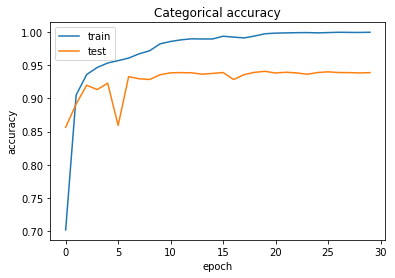

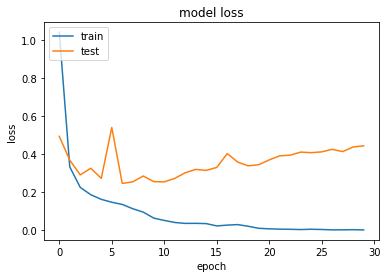

In [43]:
import json
with open('My_RNN_Emp4/RNN_Emp4_train_results.json') as file :
    s = file.read()
r = json.loads(s)

# summarize history for categorical accuracy
plt.plot(r['sparse_categorical_accuracy'])
plt.plot(r['val_sparse_categorical_accuracy'])
plt.title('Categorical accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(r['loss'])
plt.plot(r['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [44]:
# summarize history for categorical accuracy
plt.plot(results.history['sparse_categorical_accuracy'])
plt.plot(results.history['val_sparse_categorical_accuracy'])
plt.title('Categorical accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: name 'results' is not defined

In [84]:
results.history

{'loss': [0.8525141807539123,
  0.29991806319034786,
  0.21938733793888474,
  0.17379031749675633,
  0.1539717637688706,
  0.13503858028738328,
  0.11589008583372137,
  0.11036717402573704,
  0.09435029452716824,
  0.054131668537474684,
  0.0383390514625557,
  0.030936752425540157,
  0.03162108992792743,
  0.030244485730638513,
  0.022891412713941458,
  0.020492736257027785,
  0.021453388676735057,
  0.01754314116664874,
  0.013228839971225969,
  0.007662755121117399,
  0.005221084747601803,
  0.004394163428615025,
  0.003128157847222701,
  0.0038572341557353085,
  0.0046156186110721436,
  0.002381967259974713,
  0.0021300216831503776,
  0.0023324137611876053,
  0.0023907872286176904,
  0.001633775277142356],
 'sparse_categorical_accuracy': [0.7599271616541353,
  0.9139450187969925,
  0.9360119047619048,
  0.9491306390977443,
  0.9549459586466166,
  0.9602130325814536,
  0.9662241541353384,
  0.9672423245614035,
  0.9717457706766918,
  0.9850407268170426,
  0.9899161967418546,
  0.9920

In [45]:
#load best model according to cross-validation - model-attRNN
# model = load_model('model-attRNN.h5', custom_objects={'Melspectrogram': Melspectrogram, 'Normalization2D': Normalization2D })
# or in case of weights saved


model.load_weights('My_RNN_Emp4/weights-RNN_Emp4.h5')

ValueError: You are trying to load a weight file containing 16 layers into a model with 13 layers.

In [70]:
#read all test data
x_test, y_test = testGen.__getitem__(0)

In [71]:
valEval = model.evaluate_generator(valGen, use_multiprocessing=True, workers=4,verbose=1)
trainEval = model.evaluate_generator(trainGen, use_multiprocessing=True, workers=4,verbose=1)
testEval = model.evaluate(x_test, y_test, verbose=1)
print('Evaluation scores: \nMetrics: {} \nTrain: {} \nValidation: {} \nTest: {}'.format(model.metrics_names, trainEval, valEval, testEval) )

798/798 [==============================] - ETA: 2:34:4 - ETA: 1:20:1 - ETA: 55:27  - ETA: 43:0 - ETA: 35:3 - ETA: 30:3 - ETA: 27:0 - ETA: 24:2 - ETA: 22:1 - ETA: 20:3 - ETA: 19:1 - ETA: 18:0 - ETA: 17:0 - ETA: 16:1 - ETA: 15:3 - ETA: 14:5 - ETA: 14:2 - ETA: 13:5 - ETA: 13:2 - ETA: 13:0 - ETA: 12:4 - ETA: 12:2 - ETA: 12:0 - ETA: 11:4 - ETA: 11:3 - ETA: 11:1 - ETA: 11:0 - ETA: 10:5 - ETA: 10:3 - ETA: 10:2 - ETA: 10:1 - ETA: 10:0 - ETA: 9:5 - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6

6835/6835 [==============================] - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 59s - ETA: 59 - ETA: 58 - ETA: 58 - ETA: 58 - ETA: 57 - ETA: 57 - ETA: 56 - ETA: 56 - ETA: 56 - ETA: 55 - ETA: 55 - ETA: 54 - ETA: 54 - ETA: 54 - ETA: 53 - ETA: 53 - ETA: 52 - ETA: 52 - ETA: 52 - ETA: 51 - ETA: 51 - ETA: 50 - ETA: 50 - ETA: 50 - ETA: 49 - ETA: 49 - ETA: 48 - ETA: 48 - ETA:

In [72]:
# save results from testing evaluation
import json
with open('My_RNN_Emp5_Avg/RNN_Emp5_Avg_test_results.json', 'w') as file :
    test_res = {'valEval' : dict(zip(['loss', 'accuracy'], valEval)), 
                'trainEval' : dict(zip(['loss', 'accuracy'], trainEval)), 
                'testEval' : dict(zip(['loss', 'accuracy'], testEval))}
    json.dump(test_res, file)

In [ ]:
#only for the Kaggle competition, 12-cmd
x_testR, y_testR = testRGen.__getitem__(0)
testREval = model.evaluate(x_testR, y_testR, verbose=1)
testREval

In [ ]:
testREval = model.evaluate_generator(testRGen, use_multiprocessing=True, workers=4,verbose=1)
testREval

# Evaluation and Attention Plots

In [73]:
attSpeechModel = Model(inputs=model.input,
                                 outputs=[model.get_layer('output').output, 
                                          model.get_layer('attSoftmax').output,
                                          model.get_layer('mel_stft').output])


In [50]:
audios, classes = valGen.__getitem__(3)
classes

array([19,  4, 17, 19, 15, 35, 20, 23,  8, 32,  3,  5, 22,  3, 25,  7,  3,
        4, 14,  6,  3, 10, 12, 10, 14, 11, 15,  9,  2, 19, 35, 10, 15, 17,
        2,  9,  3, 18,  1, 35,  4,  9,  2, 12, 23, 28,  9, 15, 16, 24, 16,
        5,  9, 20,  2, 28, 17, 12,  4, 18, 10, 10, 24, 11])

In [51]:
#8 - on, 13 - one, 7 - right
idAudio = 8
classes[idAudio]

8

In [74]:
outs, attW, specs = attSpeechModel.predict( audios )

In [75]:
np.argmax(outs,axis=1)

array([19,  4, 17, 19, 15, 35, 20, 23,  8, 32,  3,  5, 22,  1, 25,  7,  3,
        4, 14,  6,  3, 10, 12, 10, 14, 11, 15,  9,  6, 19, 35, 10, 15, 17,
        3,  9,  3, 18,  1, 35,  4,  4,  2, 12, 23, 28,  9, 15, 16, 24, 16,
        5,  9, 20,  2, 28, 17, 12,  4, 18, 10,  4, 24, 11], dtype=int64)

In [54]:
specs.shape

(64, 80, 125, 1)

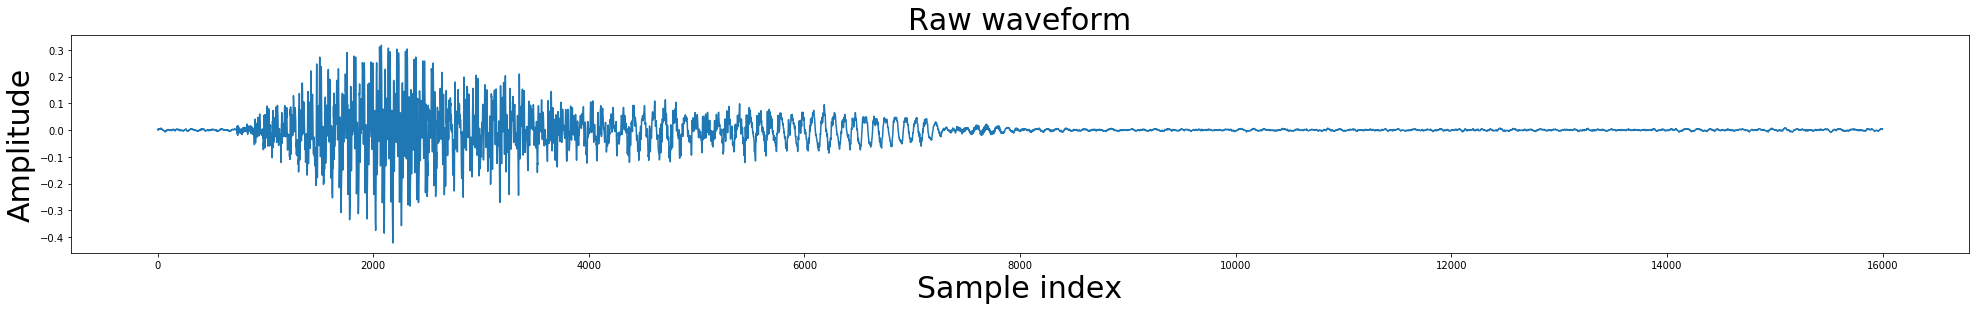

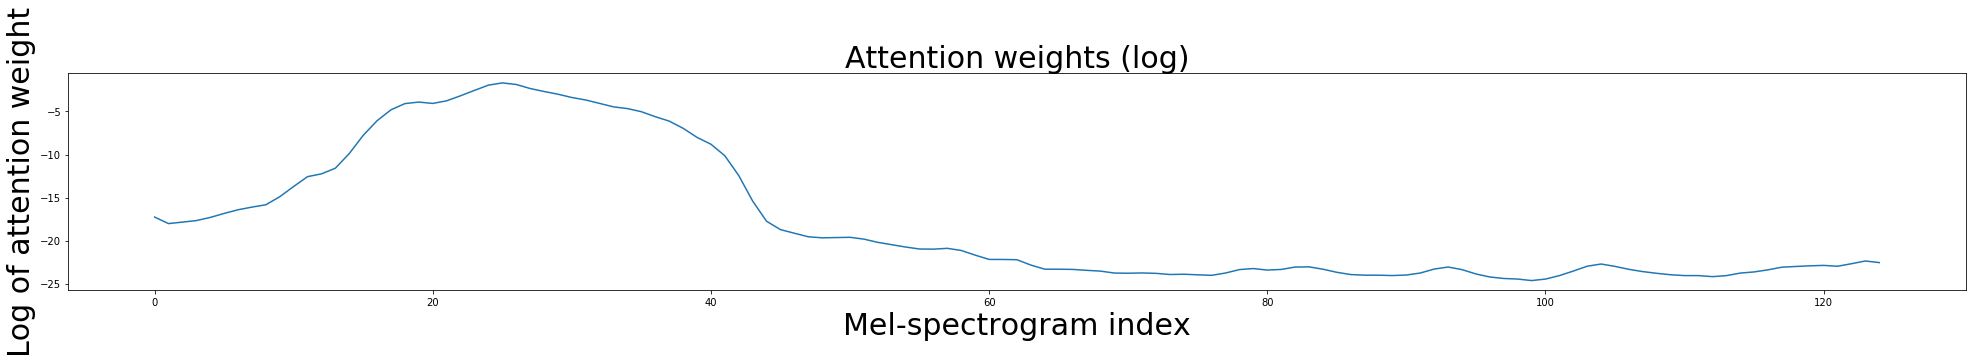

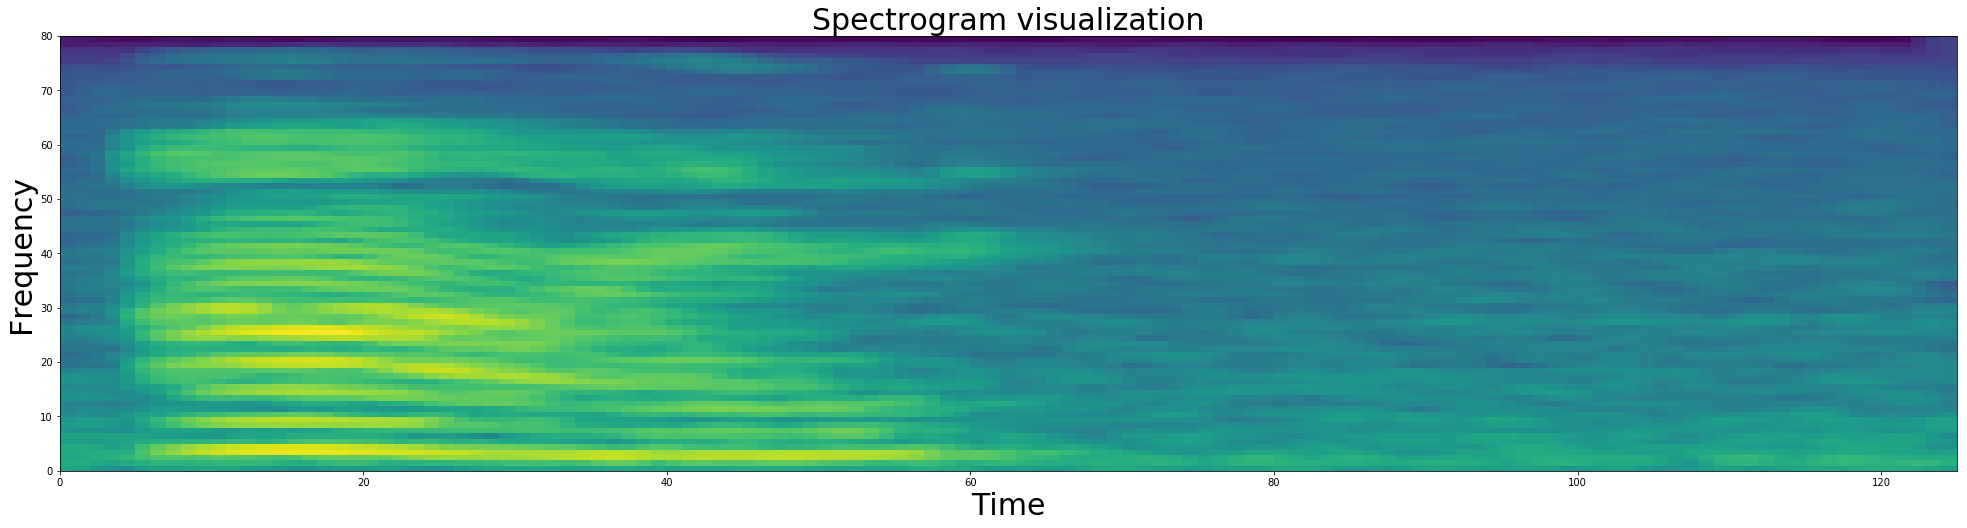

In [76]:

imgHeight = 2*2

plt.figure(figsize=(17*2,imgHeight))
plt.title('Raw waveform', fontsize=30)
plt.ylabel('Amplitude', fontsize=30)
plt.xlabel('Sample index', fontsize=30)
plt.plot(audios[idAudio])
plt.savefig('My_RNN_Emp5_Avg/picrawWave.png', dpi = 400)
plt.show()

plt.figure(figsize=(17*2,imgHeight))
plt.title('Attention weights (log)', fontsize=30)
plt.ylabel('Log of attention weight', fontsize=30)
plt.xlabel('Mel-spectrogram index', fontsize=30)
plt.plot(np.log(attW[idAudio]))
plt.savefig('My_RNN_Emp5_Avg/picAttention.png', dpi = 400)
plt.show()


plt.figure(figsize=(17*2,imgHeight*2))
plt.pcolormesh(specs[idAudio,:,:,0])

plt.title('Spectrogram visualization', fontsize=30)
plt.ylabel('Frequency', fontsize=30)
plt.xlabel('Time', fontsize=30)
plt.savefig('My_RNN_Emp5_Avg/picmelSpec.png', dpi = 400)

plt.show()

In [77]:
y_pred = model.predict(x_test, verbose=1)

6835/6835 [==============================] - ETA: 5: - ETA: 3: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 59s - ETA: 59 - ETA: 58 - ETA: 58 - ETA: 57 - ETA: 57 - ETA: 57 - ETA: 56 - ETA: 56 - ETA: 55 - ETA: 55 - ETA: 54 - ETA: 54 - ETA: 54 - ETA: 53 - ETA: 53 - ETA: 52 - ETA: 52 - ETA: 51 - ETA: 51 - ETA: 51 - ETA: 50 - ETA: 50 - ETA: 49 - ETA: 49 - ETA:

In [78]:
from sklearn.metrics import confusion_matrix
import audioUtils
cm = confusion_matrix(y_test, np.argmax(y_pred,1))

In [79]:
set(y_test)

{1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 22,
 23,
 24,
 25,
 28,
 29,
 31,
 32,
 33,
 35}

In [68]:
#35word, v2
'''
classes = ['nine', 'yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go',
           'zero', 'one', 'two', 'three', 'four', 'five', 'six', 
           'seven',  'eight', 'backward', 'bed', 'bird', 'cat', 'dog',
           'follow', 'forward', 'happy', 'house', 'learn', 'marvin', 'sheila', 'tree',
           'visual', 'wow']
'''

In [2]:
#35word, v1
classes=['nine', 'yes',  'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go',
         'zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven',  'eight', 
         'bed', 'bird', 'cat', 'dog', 'happy', 'house', 
         'marvin', 'sheila', 'tree', 'wow']

In [ ]:
#20cmd
'''
classes=['unknown', 'nine', 'yes',  'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go',
         'zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven',  'eight']
'''

Normalized confusion matrix


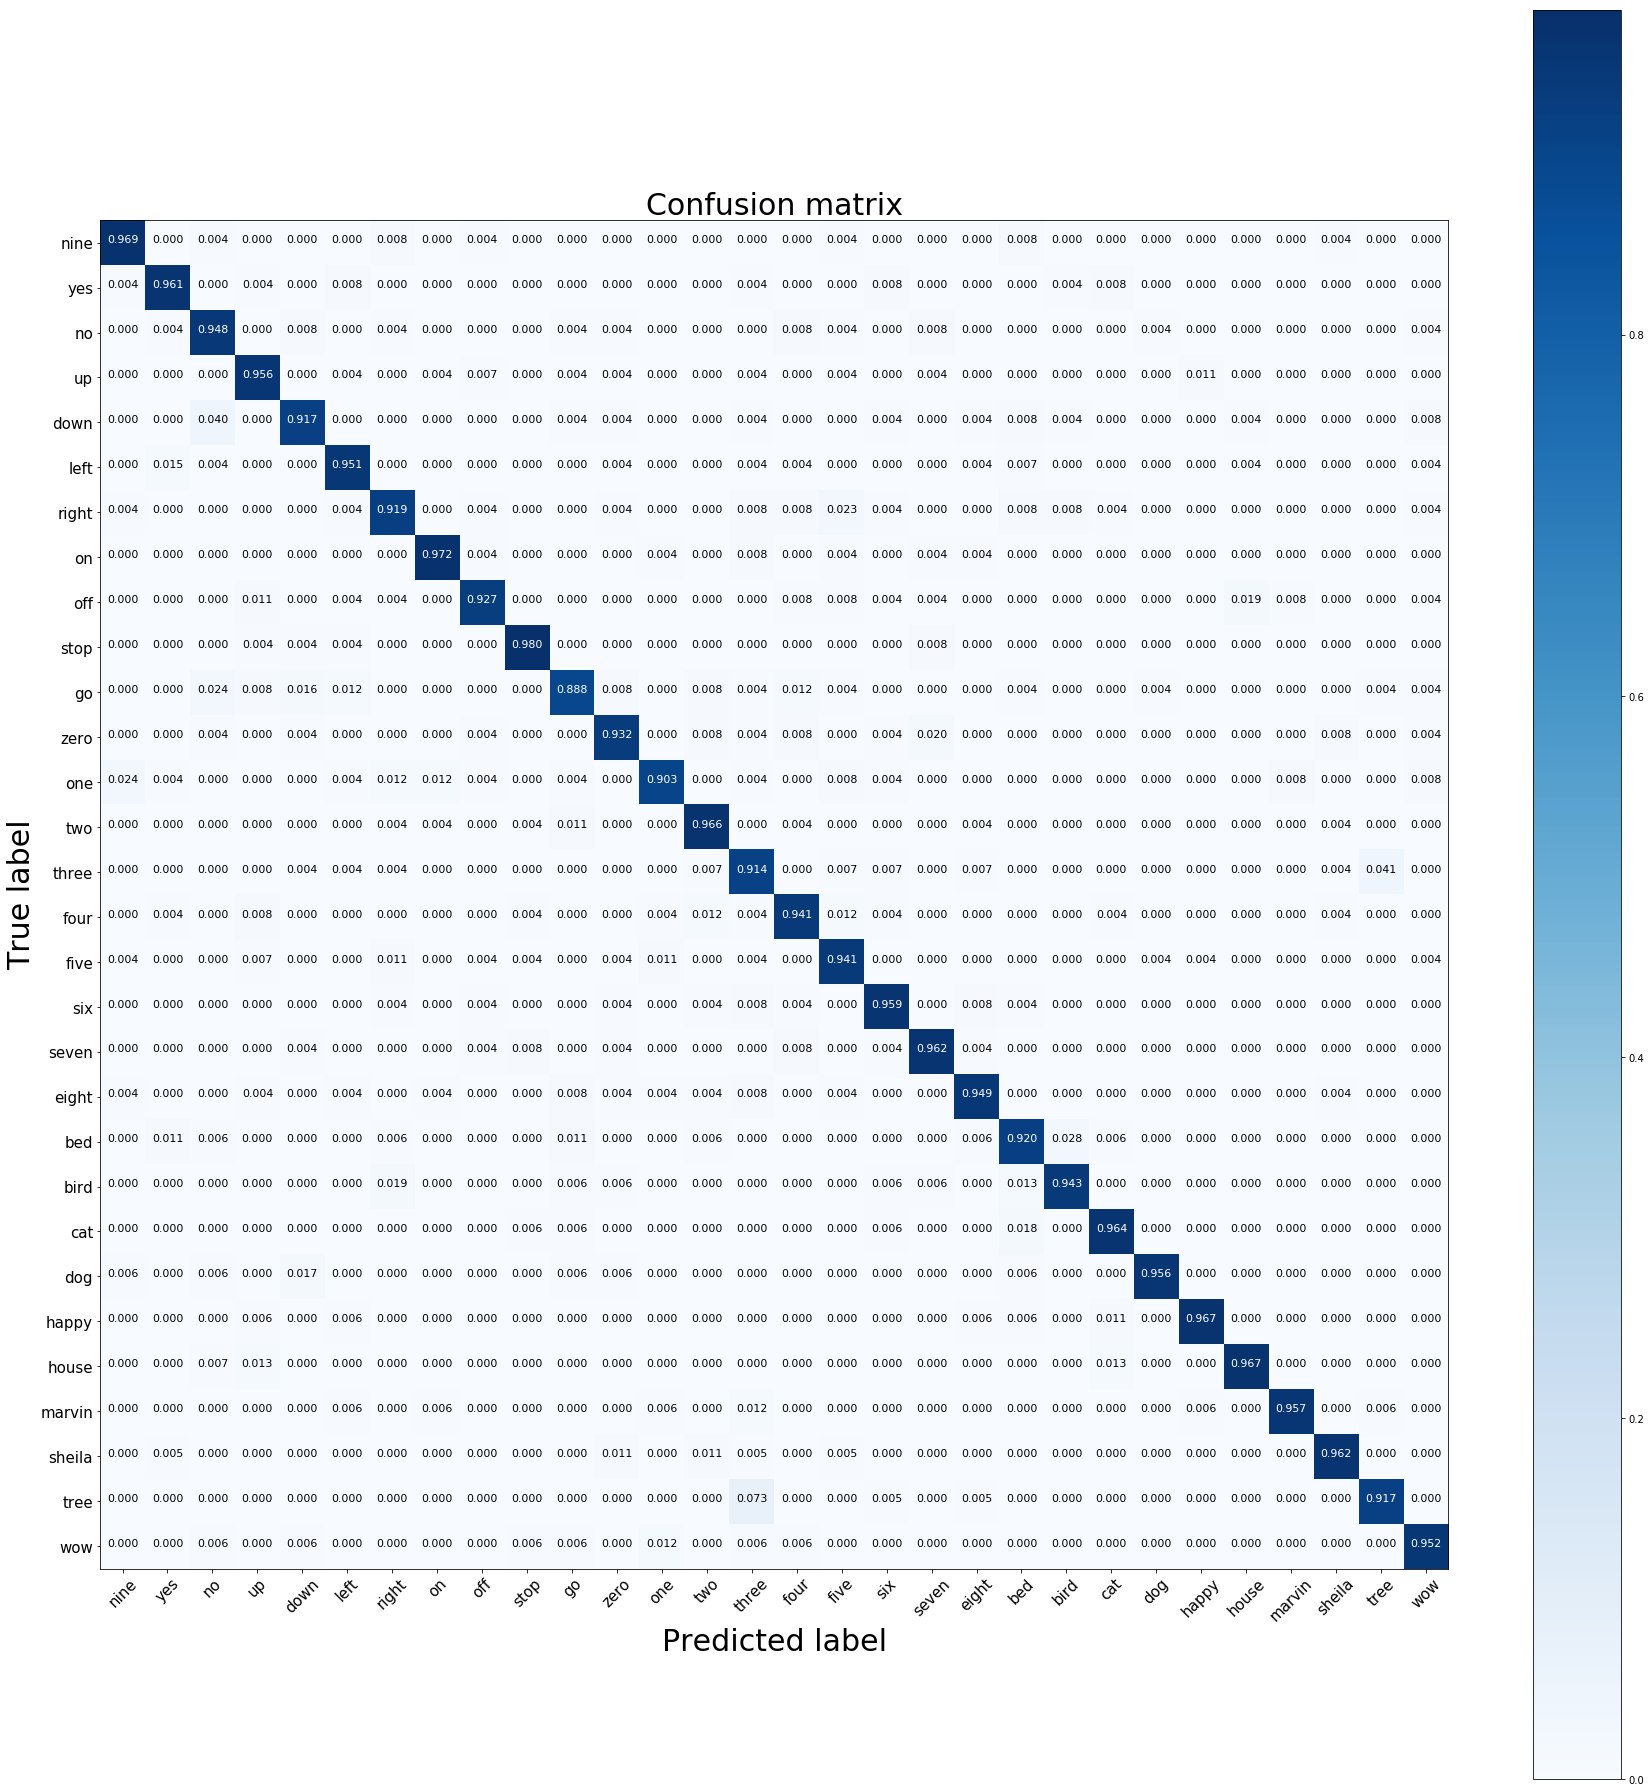

In [81]:
audioUtils.plot_confusion_matrix(cm, classes, normalize=True)